# TESI F1

###### 

## FONTI

[1] https://www.linkedin.com/pulse/f1-analisi-tecnica-dei-dati-fino-30gb-gp-federica-canton/?originalSubdomain=it  
[2] https://docs.fastf1.dev

###### 

## INTRODUZIONE

In un mondo pieno dati lo sport si sta adattando e anno dopo anno li sta usando con lo scopo di raggiungere risultati...  
Uno dei principali mondi in cui la raccolta e l'analisi dei dati è fondamentale è il motorsport, quello più sviluppato è la formula 1...

Lato storico, dal 1950 la prima gara di f1...

(riformulare) L'analisi dei dati è un pilastro fondamentale nel panorama della Formula 1, dove anche la più piccola variazione può determinare la vittoria o la sconfitta. Ogni Gran Premio vede la produzione e la raccolta di oltre 30 gigabyte di dati provenienti da entrambe le vetture dello stesso team, una quantità di informazioni significativa che pone l'analisi dati al centro della strategia.

In Formula 1, l'analisi dei dati viene sfruttata in diversi ambiti, tra cui lo sviluppo di nuove tecnologie destinate a migliorare le prestazioni delle monoposto. Questo implica un'esplorazione approfondita dell'aerodinamica, dei motori e delle sospensioni attraverso l'utilizzo dei dati disponibili. L'analisi è cruciale nel perfezionamento delle vetture esistenti, permettendo ai team di individuare possibili criticità o aree di miglioramento per ottimizzare le strategie di gara.

Un'altra importante applicazione dell'analisi dati è nella preparazione alle gare, dove i team si avvalgono dei dati raccolti per studiare il tracciato e simulare le condizioni di gara, con l'obiettivo di pianificare strategie efficaci. L'analisi dei dati si è quindi rivelata sempre più vitale nell'ambito della Formula 1, dove gli ingegneri dedicano il loro tempo ad analizzare i dati telemetrici delle monoposto, contribuendo così a garantire un costante vantaggio competitivo.

Ogni giro di pista produce 35 megabyte di dati, tradotti in 30 gigabyte di informazioni da analizzare durante un weekend di gara. Questi dati, raccolti attraverso una serie di sensori posizionati sulla monoposto, vengono elaborati mediante software appositi come ATLAS. Tra i parametri monitorati e analizzati vi sono la velocità della vettura, il numero di giri del motore, la pressione e la temperatura dei freni, l'angolo di sterzo, la percentuale di pressione sull'acceleratore, la quantità di benzina rimanente, l'attivazione del DRS (sistema di riduzione della resistenza aerodinamica) e molte altre grandezze fondamentali per l'ottimizzazione della monoposto.

Tutti questi dati vengono trasmessi in tempo reale al team attraverso l'antenna posizionata sul muso della monoposto o tramite le antenne dislocate lungo il circuito, consentendo agli ingegneri di monitorare da remoto le prestazioni della vettura e intervenire tempestivamente durante la gara. [1] 

## CAPITOLO 1: LE FUNZIONI E I DATI

Da: https://docs.fastf1.dev [2] (aggiungere alle fonti) viene usata l'api fastf1

composizione api

Telemetrie e ecc parte dal 2018

- Correlazione
- Regressione: fare regressione tra durata pneumatici/miscele e temperature

In [1]:
# installazione api
!pip install fastf1

In [2]:
pip install --upgrade seaborn

Note: you may need to restart the kernel to use updated packages.


In [3]:
# installazione librerie
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import OLSInfluence

import statsmodels.api as sm
from sklearn.metrics import r2_score

import fastf1
import fastf1.plotting

fastf1.plotting.setup_mpl(misc_mpl_mods=False)

In [4]:
sns.set_style("darkgrid")

###
### 1.1 Definizione delle funzioni:

La funzione "laps_no_dnf(race)" inizialmente seleziona i giri più veloci di un certo limite. La soglia è del 107%, quindi se ad esempio il giro più veloce è durato 100 secondi, non prende in considerazione i giri durati più di 107 secondi. In questo modo vengono eliminati i giri sotto safety car, virtual safety car o giri in cui un pilota ha avuto problemi alla vettura.
Successivamente attraverso un "ciclo for" prendiamo i piloti che non hanno concluso la gara e escludiamo tutti i loro giri da quelli totali.

La funzione mean_time(giri)

In [5]:
# Funzione che prende i giri dei piloti che hanno concluso la gara.
def laps_no_dnf(race):
    Laps = race.laps.pick_quicklaps().pick_not_deleted().pick_wo_box() # prendo i più veloci del 107%, quelli non cancellati e
                                                                       # quelli che non sono ne 'In laps' che 'Out laps'
    drivers = pd.unique(race.laps['Driver']) # Tutti i piloti

    drivers_dnf = []

    for D in drivers:
        Results = race.get_driver(D).dnf # Prende i piloti che non hanno terminato la gara e poi li esclude
        if Results == True:
            drivers_dnf.append(D)
        
    Laps_fin = Laps.loc[~Laps['Driver'].isin(drivers_dnf)]
    return Laps_fin

### 1.2 Definizione DataFrame:

In [ ]:
df_tempi = []
df_tempi = pd.DataFrame(df_tempi)  # Inizializza un DataFrame vuoto

for y in range(2019, 2024):
    for g in range(1, 22):  # per generare valori da 1 a 21
        try:        
            gara = fastf1.get_session(y, g, 'R')
            gara.load(telemetry=False) # NO TELEMETRIE!!
                   
            tempi_tot = laps_no_dnf(gara)  # escludo i piloti dnf
            
            df_tempi_tot = pd.DataFrame(tempi_tot)
            
            # Aggiungi una colonna 'Year' con il valore corrispondente a y
            df_tempi_tot['Year'] = y
            
            event = fastf1.get_event(y, g)
            EventName = event['EventName']
            df_tempi_tot['GP'] = EventName
            
            # Concatena il DataFrame df_giri al DataFrame df_times
            df_tempi = pd.concat([df_tempi, df_tempi_tot], ignore_index=False)       
                        
        except ValueError:
            print('No data')
        
df_tempi = df_tempi.sort_values(by='Team') 

In [ ]:
# CREO FILE EXCELL DEL DATAFRAME
df_tempi.to_csv('df_tempi.csv', sep = ';', index = True)

##
## CAPITOLO 2: ANALISI DESCRITTIVE


### Analisi statistiche:
Quali sono stati i team piu veloci nei diversi GP e nel corso degli stessi. Grazie al trashold sono stati rimossi sia i giri sotto la pioggia, ma mantenute gare totalmente sotto la pioggia!

In [5]:
# CARICO IL FILE
tempi = pd.read_csv('df_tempi.csv', sep = ';')

In [6]:
# Converti la colonna LapTime in un oggetto timedelta
tempi['Sector1Time_timedelta'] = pd.to_timedelta(tempi['Sector1Time'])

# Estrai i secondi dalla colonna LapTime_timedelta
tempi['Sector1Time_s'] = tempi['Sector1Time_timedelta'].dt.total_seconds()

# Converti la colonna LapTime in un oggetto timedelta
tempi['Sector2Time_timedelta'] = pd.to_timedelta(tempi['Sector2Time'])

# Estrai i secondi dalla colonna LapTime_timedelta
tempi['Sector2Time_s'] = tempi['Sector2Time_timedelta'].dt.total_seconds()

# Converti la colonna LapTime in un oggetto timedelta
tempi['Sector3Time_timedelta'] = pd.to_timedelta(tempi['Sector3Time'])

# Estrai i secondi dalla colonna LapTime_timedelta
tempi['Sector3Time_s'] = tempi['Sector3Time_timedelta'].dt.total_seconds()

In [7]:
# Converti anche i tempi dei settori
tempi['LapTime_timedelta'] = pd.to_timedelta(tempi['LapTime'])

# Estrai i secondi dalla colonna LapTime_timedelta
tempi['LapTime_s'] = tempi['LapTime_timedelta'].dt.total_seconds()

In [8]:
# Aggiusto i team
team_mapping = {
    'Alfa Romeo Racing': 'Alfa Romeo',
    'Toro Rosso': 'AlphaTauri',
    'Racing Point': 'Aston Martin',
    'Renault' : 'Alpine'
}

# Effettua la sostituzione dei nomi dei team
tempi['Team'] = tempi['Team'].replace(team_mapping)

In [9]:
team_palette = {
    'Alfa Romeo': '#900000',
    'AlphaTauri': '#2b4562',
    'Alpine': '#0090ff',
    'Aston Martin': '#006f62',
    'Ferrari': '#dc0000',
    'Haas F1 Team': '#ffffff',
    'McLaren': '#ff8700',
    'Mercedes': '#00d2be',
    'Red Bull Racing': '#0600ef',
    'Williams': '#005aff',
}

In [13]:
tempi[['Year', 'GP', 'Driver', 'Team', 'LapTime','LapTime_s', 'LapNumber', 'Stint', 'TyreLife', 'Sector1Time_s', 'Sector2Time_s', 'Sector3Time_s']].sort_values(by='GP').head()

Year                           GP Driver          Team  \
69107  2020  70th Anniversary Grand Prix    RUS      Williams   
52478  2020  70th Anniversary Grand Prix    HUL  Aston Martin   
52477  2020  70th Anniversary Grand Prix    HUL  Aston Martin   
52452  2020  70th Anniversary Grand Prix    HUL  Aston Martin   
52451  2020  70th Anniversary Grand Prix    HUL  Aston Martin   

                      LapTime  LapTime_s  LapNumber  Stint  TyreLife  \
69107  0 days 00:01:33.238000     93.238       14.0    2.0       6.0   
52478  0 days 00:01:31.407000     91.407       28.0    2.0      13.0   
52477  0 days 00:01:31.088000     91.088       29.0    2.0      14.0   
52452  0 days 00:01:31.485000     91.485       41.0    3.0      11.0   
52451  0 days 00:01:30.834000     90.834       32.0    3.0       2.0   

       Sector1Time_s  Sector2Time_s  Sector3Time_s  
69107         29.368         37.977         25.893  
52478         29.083         37.055         25.269  
52477         28.976         36.897         25.215  
52452         28.953         37.277         25.255  
52451         28.918         36.814         25.102

Vengono presi 5 team tra i 10 e vengono esplorati i dati

In [62]:
team_5 = ['Ferrari', 'Mercedes', 'McLaren', 'Red Bull Racing', 'Aston Martin']
tempi_5 = tempi.loc[(tempi['Team'].isin(team_5))  & (tempi['GP'] == 'Qatar Grand Prix') & (tempi['Year'] == 2023)]

In [63]:
tempi_5[['LapTime_timedelta', 'Sector1Time_s','Sector2Time_s', 'Sector3Time_s', 'SpeedST']].describe().round(3)

LapTime_timedelta  Sector1Time_s  Sector2Time_s  Sector3Time_s  \
count                        318        318.000        318.000        318.000   
mean   0 days 00:01:27.392465408         32.224         29.455         25.713   
std    0 days 00:00:01.408120994          0.521          0.463          0.506   
min       0 days 00:01:24.319000         30.765         28.657         24.729   
25%       0 days 00:01:26.255250         31.819         29.109         25.337   
50%       0 days 00:01:27.206000         32.231         29.386         25.648   
75%       0 days 00:01:28.530250         32.617         29.806         26.098   
max       0 days 00:01:30.137000         33.738         31.263         27.148   

       SpeedST  
count  253.000  
mean   308.763  
std      9.930  
min    287.000  
25%    302.000  
50%    306.000  
75%    311.000  
max    342.000

In [64]:
# numero di giri
print('Total number of laps: ', max(tempi_5['LapNumber']))

# LapTime_s
# Top 5
top_5 = tempi_5.nsmallest(5, 'LapTime_timedelta')

# Stampa i risultati
print('LapTime')
print("Top 5:")
print(top_5[['Team', 'Driver', 'LapNumber', 'LapTime_timedelta']])

# Sector1
# Top 5
top_5 = tempi_5.nsmallest(5, 'Sector1Time_s')

# Stampa i risultati
print('Sector1')
print("Top 5:")
print(top_5[['Team', 'Driver', 'LapNumber', 'Sector1Time_s']])

# Sector2
# Top 5
top_5 = tempi_5.nsmallest(5, 'Sector2Time_s')

# Stampa i risultati
print('Sector2')
print("Top 5:")
print(top_5[['Team', 'Driver', 'LapNumber', 'Sector2Time_s']])

# Sector3
# Top 5
top_5 = tempi_5.nsmallest(5, 'Sector3Time_s')

# Stampa i risultati
print('Sector3')
print("Top 5:")
print(top_5[['Team', 'Driver', 'LapNumber', 'Sector3Time_s']])

# SpeedST
# Top 5
top_5 = tempi_5.nlargest(5, 'SpeedST')

# Stampa i risultati
print('SpeedST')
print("Top 5:")
print(top_5[['Team', 'Driver', 'LapNumber', 'SpeedST']])

Total number of laps:  57.0
LapTime
Top 5:
                  Team Driver  LapNumber      LapTime_timedelta
56184  Red Bull Racing    VER       56.0 0 days 00:01:24.319000
36766          McLaren    NOR       47.0 0 days 00:01:24.842000
36767          McLaren    NOR       46.0 0 days 00:01:24.881000
37088          McLaren    PIA       48.0 0 days 00:01:24.921000
22633          Ferrari    LEC       57.0 0 days 00:01:24.992000
Sector1
Top 5:
                  Team Driver  LapNumber  Sector1Time_s
56184  Red Bull Racing    VER       56.0         30.765
37088          McLaren    PIA       48.0         31.204
37087          McLaren    PIA       49.0         31.249
36768          McLaren    NOR       43.0         31.281
37082          McLaren    PIA       54.0         31.292
Sector2
Top 5:
                  Team Driver  LapNumber  Sector2Time_s
36767          McLaren    NOR       46.0         28.657
56186  Red Bull Racing    VER       54.0         28.662
49305         Mercedes    RUS       53.

### Distribuzioni dei tempi sui giri e degli stint:

In [66]:
order_team = ['McLaren', 'Mercedes', 'Ferrari', 'Red Bull Racing', 'Aston Martin']

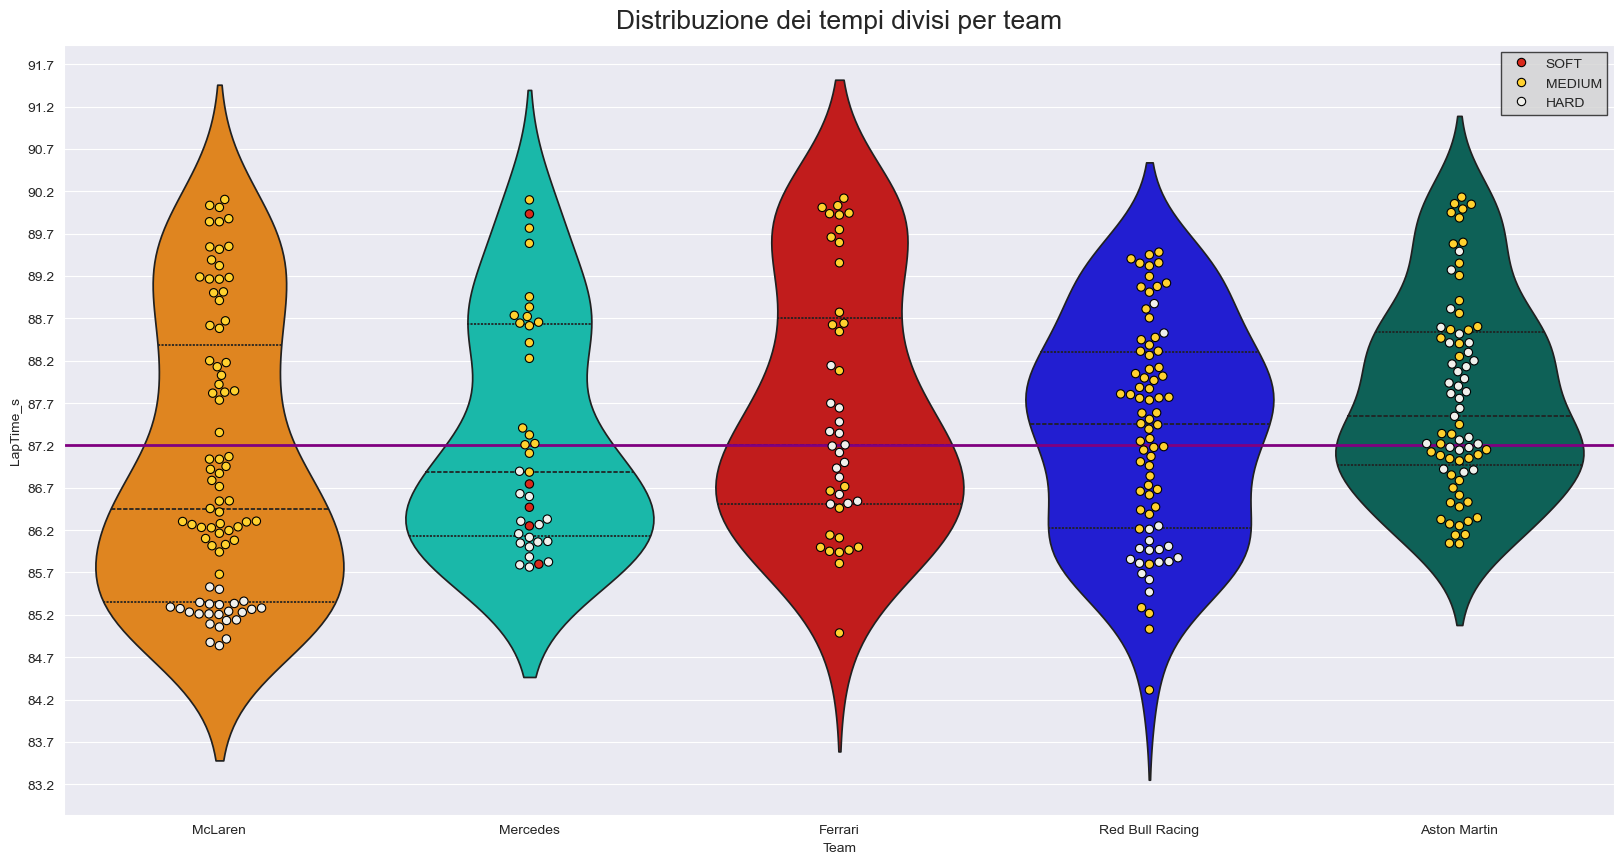

In [67]:
fig, ax = plt.subplots(figsize=(20, 10))

sns.violinplot(data=tempi_5.sort_values(by='Driver'),
               x="Team",
               y="LapTime_s",
               hue="Team",
               inner='quart',  # Imposta il tipo di visualizzazione interna
               density_norm="area",
               order=order_team,
               palette=team_palette
               )

# Calcola la media di tutti i tempi di giro
overall_median_time = tempi_5['LapTime_s'].median()

y_ticks = np.linspace(overall_median_time - 5, overall_median_time + 5, num=21)
ax.set_yticks(y_ticks)

# Disegna la linea della media complessiva
plt.axhline(y=overall_median_time, color='purple', linestyle='-', linewidth=2)

compound_colors = {'HARD': '#f0f0ec', 'MEDIUM': '#ffd12e', 'SOFT': '#da291c'}

sns.swarmplot(data=tempi_5,
              x="Team",
              y="LapTime_s",
              hue="Compound",
              palette=compound_colors,
              hue_order=["SOFT", "MEDIUM", "HARD"],
              order=order_team,
              linewidth=0.8,
              size=6,
              edgecolor='black'
              )

plt.legend(facecolor='lightgrey')
plt.title('Distribuzione dei tempi divisi per team')
    
plt.show()


### Correlazioni:

In [69]:
correlation_matrix = tempi.loc[tempi['Team'].isin(team_5)].groupby(['Year', 'GP', 'Team']).apply(lambda x: x[['LapNumber', 'LapTime_s']].corr().iloc[0,1])
correlation_matrix = correlation_matrix.unstack()
correlation_matrix.round(2)

Team                           Aston Martin  Ferrari  McLaren  Mercedes  \
Year GP                                                                   
2019 Abu Dhabi Grand Prix             -0.78    -0.70    -0.76     -0.72   
     Australian Grand Prix            -0.57    -0.33    -0.28     -0.77   
     Austrian Grand Prix              -0.62    -0.78    -0.67     -0.62   
     Azerbaijan Grand Prix            -0.87    -0.69    -0.78     -0.82   
     Bahrain Grand Prix               -0.36    -0.40    -0.55     -0.50   
...                                     ...      ...      ...       ...   
2023 Saudi Arabian Grand Prix         -0.89    -0.81    -0.63     -0.91   
     Singapore Grand Prix             -0.64    -0.45    -0.66     -0.69   
     Spanish Grand Prix               -0.89    -0.86    -0.67     -0.87   
     São Paulo Grand Prix             -0.82    -0.85    -0.71     -0.75   
     United States Grand Prix         -0.94    -0.87    -0.66     -0.86   

Team                           Red Bull Racing  
Year GP                                         
2019 Abu Dhabi Grand Prix                -0.66  
     Australian Grand Prix               -0.71  
     Austrian Grand Prix                 -0.67  
     Azerbaijan Grand Prix               -0.75  
     Bahrain Grand Prix                  -0.59  
...                                        ...  
2023 Saudi Arabian Grand Prix            -0.80  
     Singapore Grand Prix                -0.73  
     Spanish Grand Prix                  -0.85  
     São Paulo Grand Prix                -0.81  
     United States Grand Prix            -0.84  

[100 rows x 5 columns]

.apply(lambda x: x[['LapNumber', 'LapTime_s']].corr().iloc[0,1]): Per ogni gruppo creato nel punto precedente, viene applicata una funzione. La funzione seleziona solo le colonne 'LapNumber' e 'LapTime_s' e calcola la correlazione tra di esse utilizzando il metodo .corr(). Infine, viene estratto il valore di correlazione tra queste due colonne e restituito.

correlation_matrix = correlation_matrix.unstack(): Dopo aver applicato la funzione a ciascun gruppo, il risultato viene trasformato in una matrice utilizzando il metodo unstack(). Ciò riorganizza i dati in modo che i valori unici della colonna 'Team' diventino le righe dell'indice della matrice, i valori unici della colonna 'Year' diventino le colonne e i valori delle correlazioni vengano inseriti nelle celle corrispondenti.

In [71]:
correlation_matrix.to_csv('correlation_matrix.csv', sep = ';', index = True)

In [73]:
correlation_matrix = pd.read_csv('correlation_matrix.csv', sep = ';')

In [77]:
correlation_matrix[['Ferrari', 'Mercedes', 'McLaren', 'Red Bull Racing', 'Aston Martin']].median().round(2)

Ferrari           -0.76
Mercedes          -0.72
McLaren           -0.75
Red Bull Racing   -0.74
Aston Martin      -0.74
dtype: float64

##
## CAPITOLO 3: REGRESSIONE TEMPO PER GIRI
Man mano che i giri aumentano i tempi diminuiscono, voglio creare modello di regressione ma devo decidere se dividere i gp, oppure considerarli insieme 

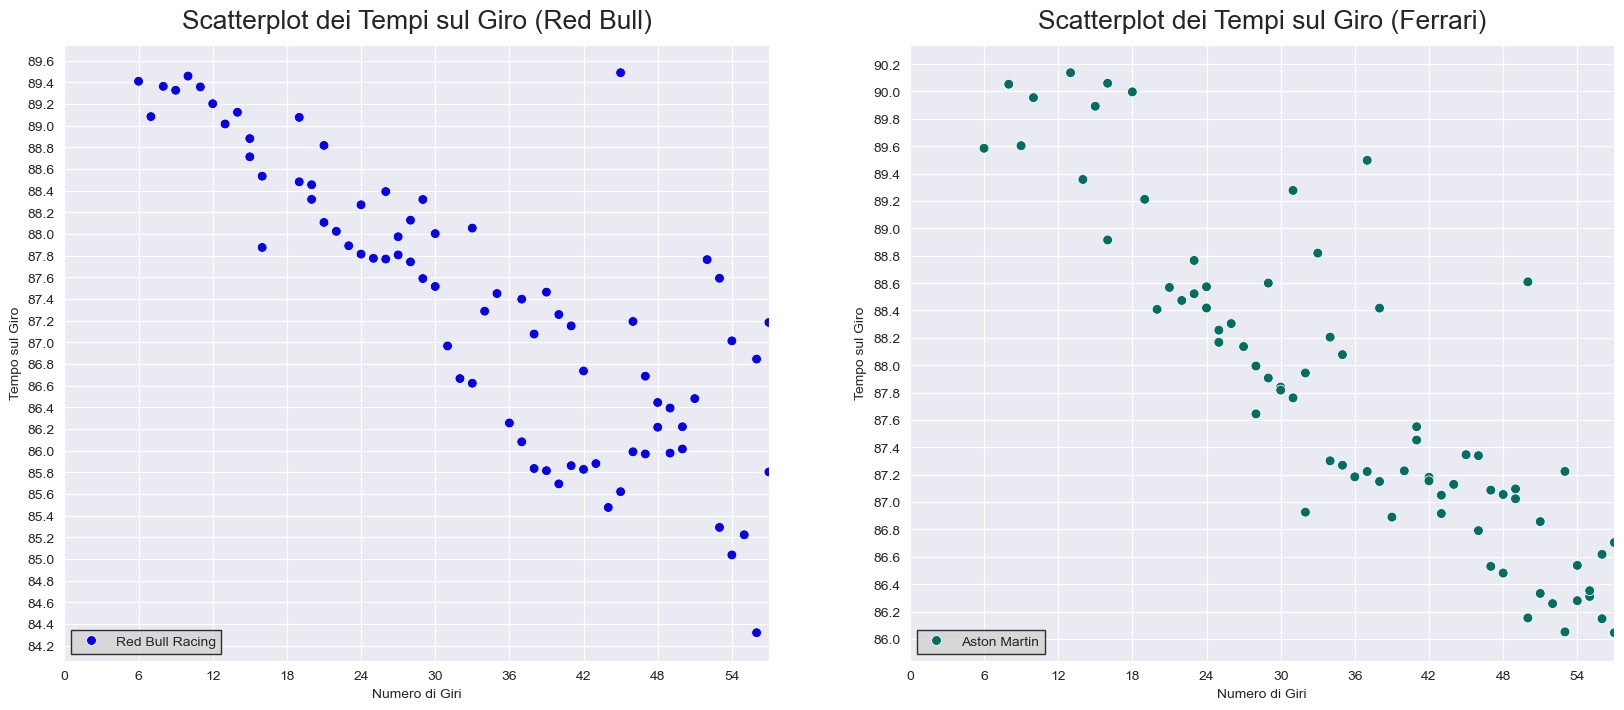

In [85]:
# Creazione di una nuova figura e di due assi affiancati
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Traccia il primo scatterplot sul primo asse
scatterplot1 = sns.scatterplot(data=tempi_5.loc[tempi_5['Team'] == 'Red Bull Racing'],
                               x="LapNumber",
                               y="LapTime_s",
                               hue="Team",
                               palette=team_palette,
                               alpha=1,
                               s=50,
                               ax=ax1)

# Personalizzazione del primo plot
ax1.set_xlabel("Numero di Giri")
ax1.set_ylabel("Tempo sul Giro")
ax1.set_title("Scatterplot dei Tempi sul Giro (Red Bull)")
ax1.set_xlim(0, tempi_5['LapNumber'].max())  # Imposta il limite inferiore a 0
ax1.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax1.yaxis.set_major_locator(plt.MultipleLocator(0.2))
legend1 = scatterplot1.legend(loc='lower left', facecolor='lightgrey', edgecolor='black')

# Traccia il secondo scatterplot sul secondo asse
scatterplot2 = sns.scatterplot(data=tempi_5.loc[tempi_5['Team'] == 'Aston Martin'],
                               x="LapNumber",
                               y="LapTime_s",
                               hue="Team",
                               palette=team_palette,
                               alpha=1,
                               s=50,
                               ax=ax2)

# Personalizzazione del secondo plot
ax2.set_xlabel("Numero di Giri")
ax2.set_ylabel("Tempo sul Giro")
ax2.set_title("Scatterplot dei Tempi sul Giro (Ferrari)")
ax2.set_xlim(0, tempi_5['LapNumber'].max())  # Imposta il limite inferiore a 0
ax2.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax2.yaxis.set_major_locator(plt.MultipleLocator(0.2))
legend2 = scatterplot2.legend(loc='lower left', facecolor='lightgrey', edgecolor='black')

# Mostra i plot
plt.show()

### 3.1 DEFINIZIONE INDICE D-COOK

In [91]:
def Dcook_filter(df):
    
    # Addestramento del modello di regressione
    X = df[['LapNumber']]
    y = df['LapTime_s']
    model = sm.OLS(y, sm.add_constant(X)).fit()
    

    # Calcolo delle distanze di Cook
    influence = model.get_influence()
    cook_d = influence.cooks_distance

    # Valori delle distanze di Cook per ciascuna osservazione
    cook_values = cook_d[0]
    
    # Calcola gli indici delle distanze di Cook
    influence = OLSInfluence(model)
    cook_distances = influence.cooks_distance[0]

    # Definisci una soglia per gli indici significativi
    threshold = 4 / len(df)

    # Filtra le osservazioni con indici delle distanze al di sotto della soglia
    Dcook_filtered = df[cook_distances < threshold]

    return Dcook_filtered

### L'R^2:

In [93]:
from sklearn.metrics import r2_score

# Lista per memorizzare i valori di R² per ogni team
r_squared_values = []
data_filtered = pd.DataFrame()
# Itera su ciascun team
for team in tempi_5['Team'].unique():
    # Filtra i dati per il team corrente
    team_data = tempi_5.loc[tempi_5['Team'] == team]    
    team_data_filtered = Dcook_filter(team_data)  
    data_filtered = pd.concat([data_filtered, team_data_filtered], ignore_index=False)
    
    # Dati di esempio per il team corrente
    X_team = team_data_filtered['LapNumber'].values.reshape(-1, 1)
    y_team = team_data_filtered['LapTime_s'].values
    
    # Crea e addestra un modello di regressione lineare per il team corrente
    model = LinearRegression()
    model.fit(X_team, y_team)
    
    # Previsioni del modello sui dati di addestramento
    y_pred = model.predict(X_team)
    
    # Calcola l'R² per il team corrente
    r_squared = r2_score(y_team, y_pred)
    print(f"Team: {team}, R²: {r_squared.round(2)}")
    
    # Aggiungi il valore di R² alla lista
    r_squared_values.append(r_squared)

Team: Aston Martin, R²: 0.86
Team: Ferrari, R²: 0.93
Team: McLaren, R²: 0.91
Team: Mercedes, R²: 0.77
Team: Red Bull Racing, R²: 0.83


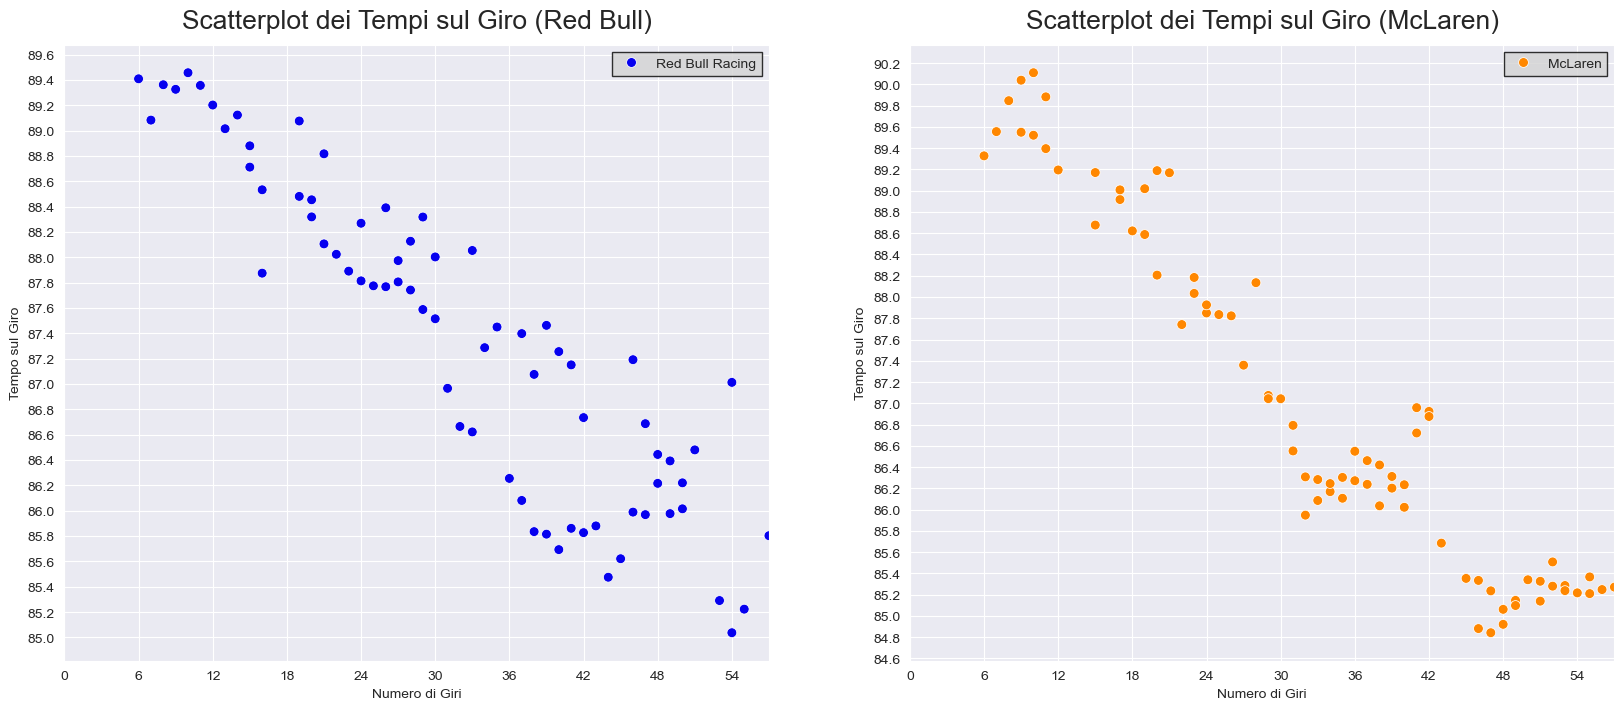

In [94]:
# Creazione di una nuova figura e di due assi affiancati
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Traccia il primo scatterplot sul primo asse
scatterplot1 = sns.scatterplot(data=data_filtered.loc[data_filtered['Team'] == 'Red Bull Racing'],
                               x="LapNumber",
                               y="LapTime_s",
                               hue="Team",
                               palette=team_palette,
                               alpha=1,
                               s=50,
                               ax=ax1)

# Personalizzazione del primo plot
ax1.set_xlabel("Numero di Giri")
ax1.set_ylabel("Tempo sul Giro")
ax1.set_title("Scatterplot dei Tempi sul Giro (Red Bull)")
ax1.set_xlim(0, data_filtered['LapNumber'].max())  # Imposta il limite inferiore a 0
ax1.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax1.yaxis.set_major_locator(plt.MultipleLocator(0.2))
legend1 = scatterplot1.legend(facecolor='lightgrey', edgecolor='black')

# Traccia il secondo scatterplot sul secondo asse
scatterplot2 = sns.scatterplot(data=data_filtered.loc[data_filtered['Team'] == 'McLaren'],
                               x="LapNumber",
                               y="LapTime_s",
                               hue="Team",
                               palette=team_palette,
                               alpha=1,
                               s=50,
                               ax=ax2)

# Personalizzazione del secondo plot
ax2.set_xlabel("Numero di Giri")
ax2.set_ylabel("Tempo sul Giro")
ax2.set_title("Scatterplot dei Tempi sul Giro (McLaren)")
ax2.set_xlim(0, data_filtered['LapNumber'].max())  # Imposta il limite inferiore a 0
ax2.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax2.yaxis.set_major_locator(plt.MultipleLocator(0.2))
legend2 = scatterplot2.legend(facecolor='lightgrey', edgecolor='black')

# Mostra i plot
plt.show()

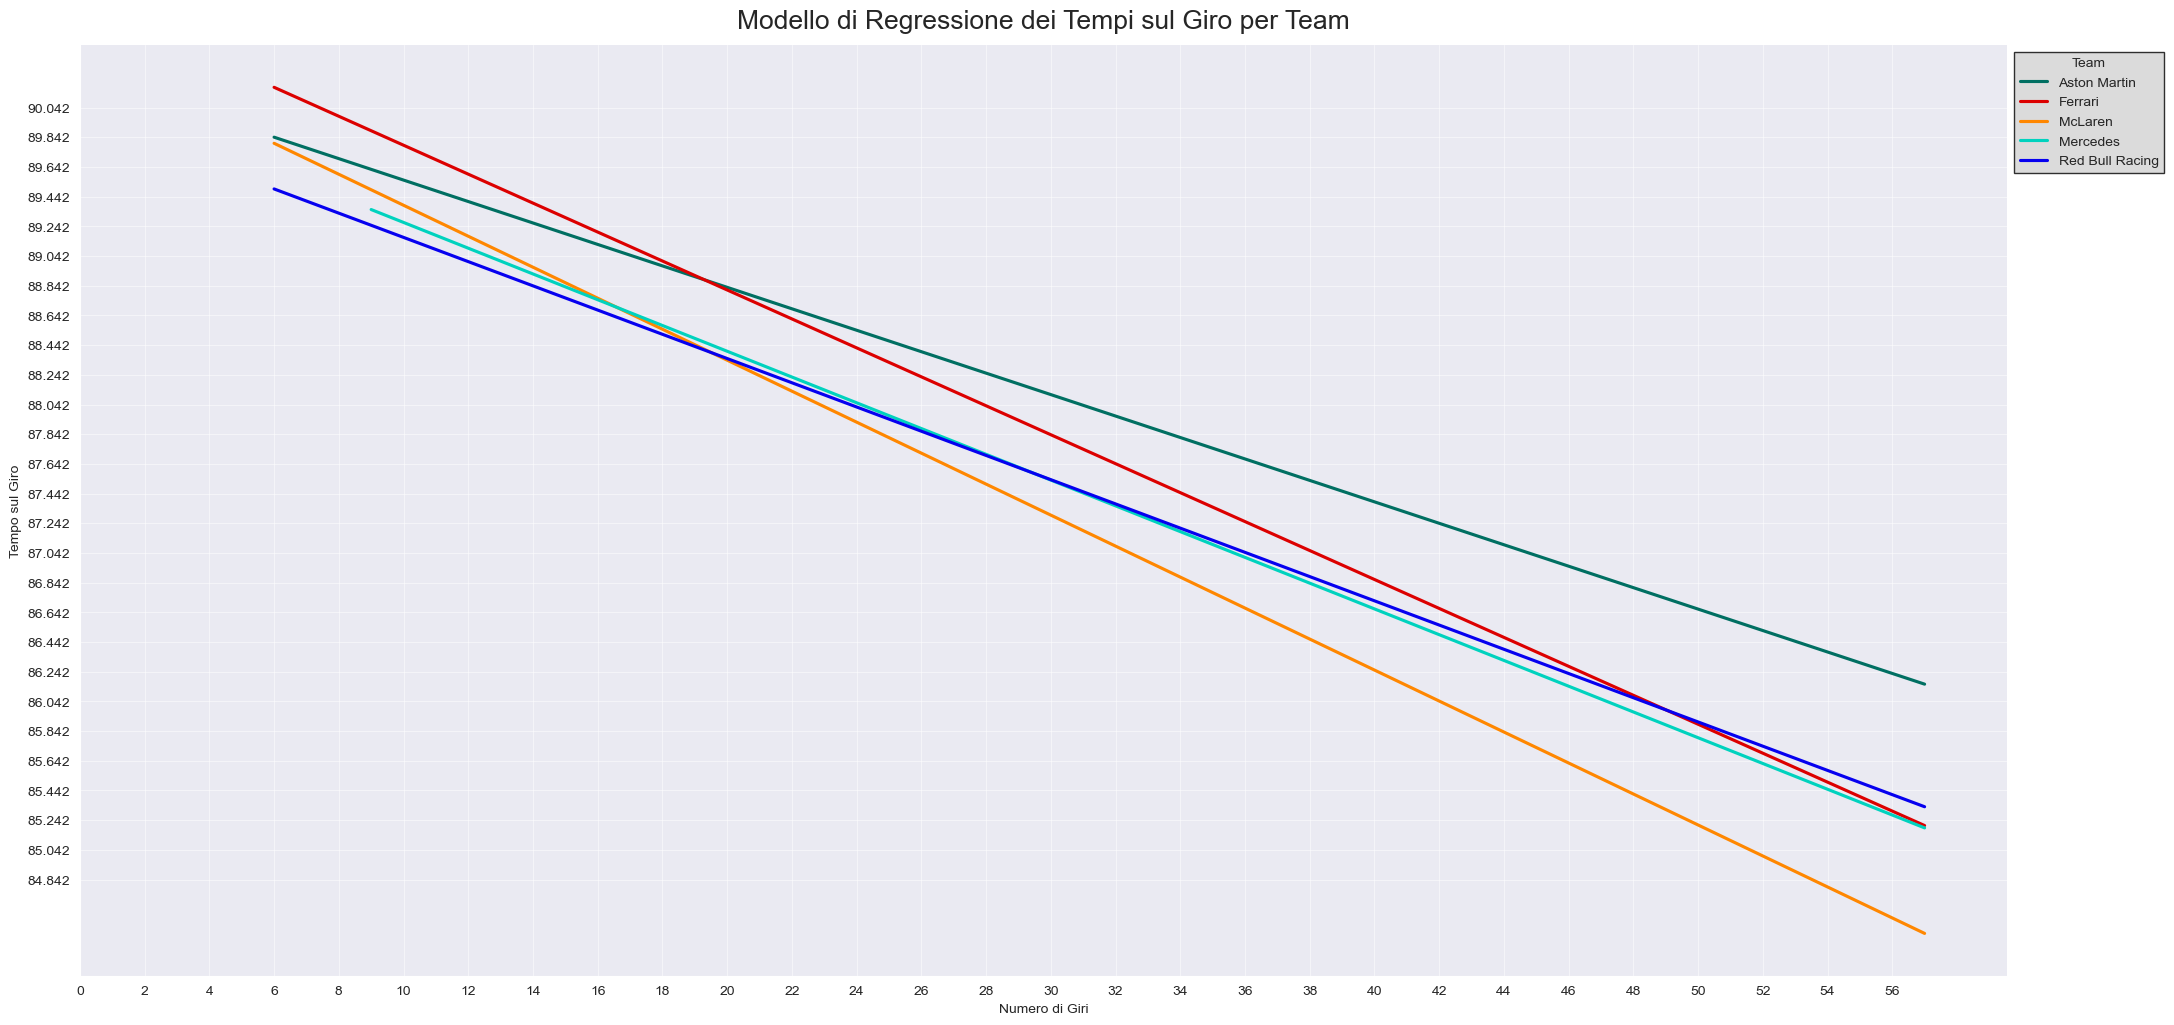

In [95]:
# Creazione del grafico di regressione con sns.lmplot() e impostazione delle dimensioni della figura
sns.lmplot(data=data_filtered,
           x="LapNumber",
           y="LapTime_s",
           hue="Team",
           palette=team_palette,
           scatter=False,
           scatter_kws={"s": 50, "alpha": 0.1},  # Dimensioni e opacità dei punti
           ci=None,  # Rimuove gli intervalli di confidenza dalla retta di regressione
           height=10,  # Altezza della figura
           aspect=2,
           legend = False)  # Rapporto larghezza/altezza della figura

# Personalizzazione dell'aspetto del grafico
plt.xlabel("Numero di Giri")
plt.ylabel("Tempo sul Giro")
plt.title("Modello di Regressione dei Tempi sul Giro per Team")

# Impostazione della scala dell'asse x
plt.xticks(np.arange(0, tempi_5['LapNumber'].max() + 1, 2))

# Aggiunta della griglia
plt.grid(True, alpha=0.5)

plt.yticks(np.arange(data_filtered['LapTime_s'].min(), data_filtered['LapTime_s'].max(), 0.2))

# Aggiunta della legenda
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Team', facecolor='lightgrey', edgecolor='black')

# Mostra il grafico
plt.show()

##
## CAPITOLO 2: ANALISI

Tuttavia, è importante tenere presente che la standardizzazione dei dati può influenzare l'interpretazione dei risultati. Ad esempio, se due team hanno tempi medi molto simili su una certa gomma, ma uno dei due team è standardizzato su una scala più ampia a causa di variazioni più estreme nei tempi dei giri nei diversi Gran Premi, potrebbe sembrare che ci sia una differenza significativa tra i due team quando in realtà potrebbero essere molto simili nelle loro prestazioni effettive.

In [81]:
data_times = pd.read_csv('df_times.csv', sep = ';')

In [82]:
# Converti la colonna LapTime in un oggetto timedelta
data_times['LapTime_timedelta'] = pd.to_timedelta(data_times['LapTime'])

# Estrai i secondi dalla colonna LapTime_timedelta
data_times['LapTime_seconds'] = data_times['LapTime_timedelta'].dt.total_seconds()
data_times

Team Driver Compound                    LapTime  Year  \
0     Alfa Romeo    BOT   MEDIUM  0 days 00:01:17.190818181  2023   
1     Alfa Romeo    BOT     HARD  0 days 00:01:32.673707317  2023   
2     Alfa Romeo    BOT   MEDIUM  0 days 00:01:47.452947368  2023   
3     Alfa Romeo    BOT     HARD  0 days 00:01:48.544476190  2023   
4     Alfa Romeo    ZHO     HARD  0 days 00:01:23.234162790  2023   
...          ...    ...      ...                        ...   ...   
3228    Williams    LAT     HARD  0 days 00:01:35.872571428  2020   
3229    Williams    LAT   MEDIUM  0 days 00:01:37.110105263  2020   
3230    Williams    RUS     HARD  0 days 00:01:36.869352941  2020   
3231    Williams    SAR   MEDIUM     0 days 00:01:49.331000  2023   
3232    Williams    SAR   MEDIUM  0 days 00:01:40.331142857  2023   

                         GP         LapTime_timedelta  LapTime_seconds  
0       Canadian Grand Prix 0 days 00:01:17.190818181        77.190818  
1          Miami Grand Prix 0 days 00:01:32.673707317        92.673707  
2     Azerbaijan Grand Prix 0 days 00:01:47.452947368       107.452947  
3     Azerbaijan Grand Prix 0 days 00:01:48.544476190       108.544476  
4     Australian Grand Prix 0 days 00:01:23.234162790        83.234163  
...                     ...                       ...              ...  
3228     Bahrain Grand Prix 0 days 00:01:35.872571428        95.872571  
3229     Bahrain Grand Prix 0 days 00:01:37.110105263        97.110105  
3230     Bahrain Grand Prix 0 days 00:01:36.869352941        96.869353  
3231  Azerbaijan Grand Prix    0 days 00:01:49.331000       109.331000  
3232   Las Vegas Grand Prix 0 days 00:01:40.331142857       100.331143  

[3233 rows x 8 columns]

In [49]:
# Aggiusto i team
team_mapping = {
    'Alfa Romeo Racing': 'Alfa Romeo',
    'Toro Rosso': 'AlphaTauri',
    'Racing Point': 'Aston Martin',
    'Renault' : 'Alpine'
}

# Effettua la sostituzione dei nomi dei team
data_times['Team'] = data_times['Team'].replace(team_mapping)


In [56]:
teams = pd.unique(data_times['Team'])
teams = teams

In [57]:
team_palette = {
    'Alfa Romeo': '#900000',
    'AlphaTauri': '#2b4562',
    'Alpine': '#0090ff',
    'Aston Martin': '#006f62',
    'Ferrari': '#dc0000',
    'Haas F1 Team': '#ffffff',
    'McLaren': '#ff8700',
    'Mercedes': '#00d2be',
    'Red Bull Racing': '#0600ef',
    'Williams': '#005aff',
}

print(team_palette)

{'Alfa Romeo': '#900000', 'AlphaTauri': '#2b4562', 'Alpine': '#0090ff', 'Aston Martin': '#006f62', 'Ferrari': '#dc0000', 'Haas F1 Team': '#ffffff', 'McLaren': '#ff8700', 'Mercedes': '#00d2be', 'Red Bull Racing': '#0600ef', 'Williams': '#005aff'}


### HARD:

In [60]:
scaler = StandardScaler()

# Adatta lo scaler ai dati e standardizza i dati
hd_times = data_times.loc[data_times['Compound'] == 'HARD'].copy()
hd_times['StandardizedData'] = scaler.fit_transform(hd_times[['LapTime_seconds']])

In [45]:
# Ordiniamo i team in base al valore della mediana.
team_order = (
    hd_times
    .groupby("Team")
    .median()['StandardizedData']
    .sort_values()
    .index
)
print(team_order)

Index(['Alfa Romeo', 'Williams', 'Aston Martin', 'Ferrari', 'Mercedes',
       'McLaren', 'Alpine', 'Red Bull Racing', 'AlphaTauri', 'Haas F1 Team'],
      dtype='object', name='Team')


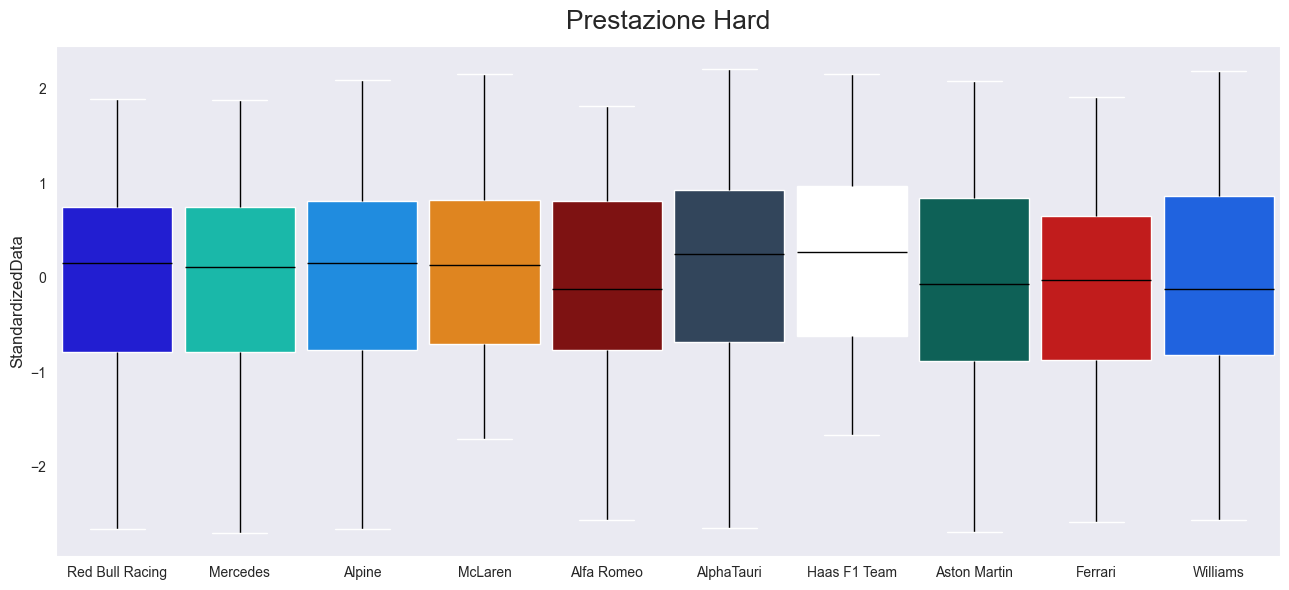

In [62]:
fig, ax = plt.subplots(figsize=(13, 6))
sns.boxplot(
    data=hd_times,
    x="Team",
    y="StandardizedData",
    hue="Team",
    order=team_order,
    palette=team_palette,
    whiskerprops=dict(color="black"),
    boxprops=dict(edgecolor="white"),
    medianprops=dict(color="black"),
    capprops=dict(color="white"),
    #dodge = True,
    width = 0.9
)

plt.title("Prestazione Hard")
plt.grid(visible=False)

# x-label is redundant
ax.set(xlabel=None)
plt.tight_layout()
plt.show()

###  
### MEDIUM:

In [52]:
# Adatta lo scaler ai dati e standardizza i dati
md_times = data_times.loc[data_times['Compound'] == 'MEDIUM'].copy()
md_times['StandardizedData'] = scaler.fit_transform(md_times[['LapTime_seconds']])

In [53]:
# Ordiniamo i team in base al valore della mediana.
team_order = (
    md_times
    .groupby("Team")
    .median()['StandardizedData']
    .sort_values()
    .index
)
print(team_order)

Index(['Alpine', 'McLaren', 'Mercedes', 'Red Bull Racing', 'Aston Martin',
       'Haas F1 Team', 'Alfa Romeo', 'AlphaTauri', 'Williams', 'Ferrari'],
      dtype='object', name='Team')


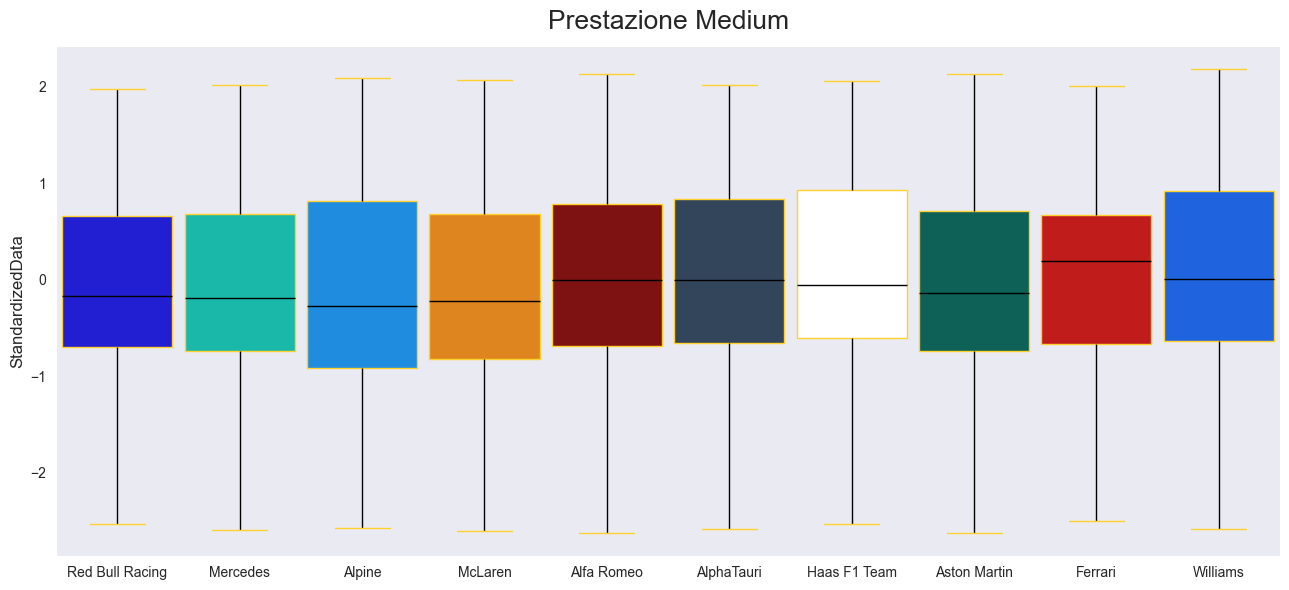

In [63]:
fig, ax = plt.subplots(figsize=(13, 6))
sns.boxplot(
    data=md_times,
    x="Team",
    y="StandardizedData",
    hue="Team",
    order=team_order,
    palette=team_palette,
    whiskerprops=dict(color='black'),
    boxprops=dict(edgecolor='#ffd12e'),
    medianprops=dict(color="black"),
    capprops=dict(color='#ffd12e'),
    #dodge = True,
    width = 0.9
)

plt.title("Prestazione Medium")
plt.grid(visible=False)

# x-label is redundant
ax.set(xlabel=None)
plt.tight_layout()
plt.show()

###
### SOFT:

In [57]:
# Adatta lo scaler ai dati e standardizza i dati
sf_times = data_times.loc[data_times['Compound'] == 'SOFT'].copy()
sf_times['StandardizedData'] = scaler.fit_transform(sf_times[['LapTime_seconds']])

In [58]:
# Ordiniamo i team in base al valore della mediana.
team_order = (
    sf_times
    .groupby("Team")
    .median()['StandardizedData']
    .sort_values()
    .index
)
print(team_order)

Index(['Red Bull Racing', 'Mercedes', 'Alpine', 'McLaren', 'Alfa Romeo',
       'AlphaTauri', 'Haas F1 Team', 'Aston Martin', 'Ferrari', 'Williams'],
      dtype='object', name='Team')


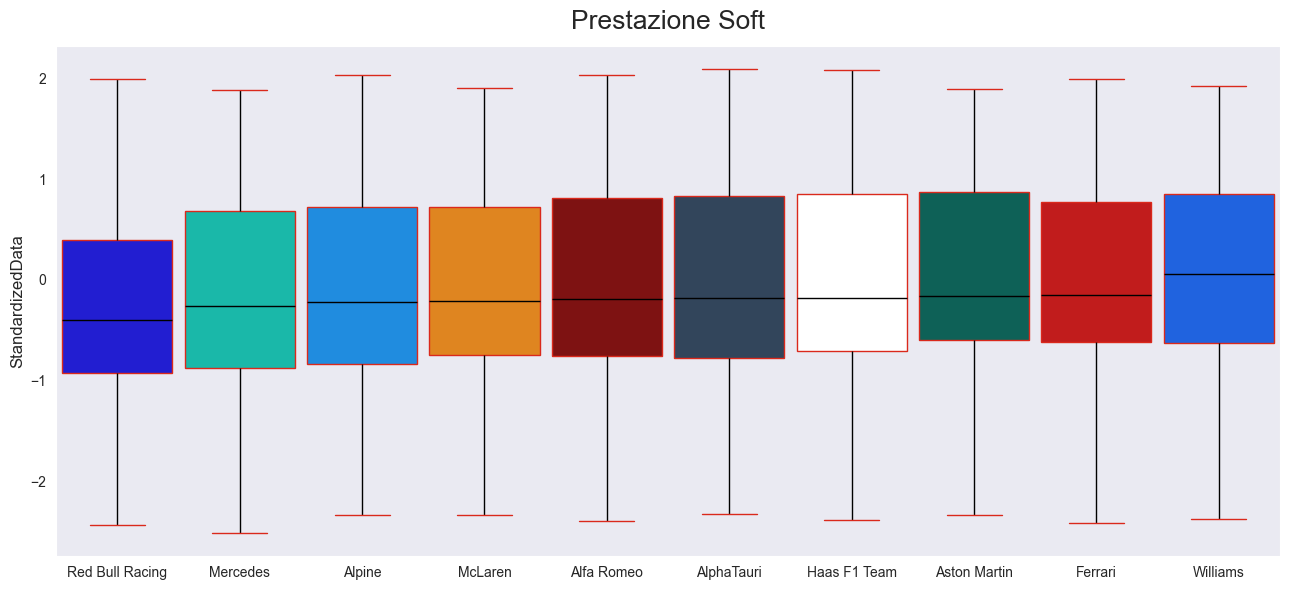

In [64]:
fig, ax = plt.subplots(figsize=(13, 6))
sns.boxplot(
    data=sf_times,
    x="Team",
    y="StandardizedData",
    hue="Team",
    order=team_order,
    palette=team_palette,
    whiskerprops=dict(color='black'),
    boxprops=dict(edgecolor='#da291c'),
    medianprops=dict(color="black"),
    capprops=dict(color='#da291c'),
    #dodge = True,
    width = 0.9
)

plt.title("Prestazione Soft")
plt.grid(visible=False)

# x-label is redundant
ax.set(xlabel=None)
plt.tight_layout()
plt.show()

##
## CAPITOLO 3: CRESCITA

In particolare l'analisi dei dati è fondamentale nella scelta degli pneumatici.
(Scrivi da qua: https://sport.virgilio.it/le-mescole-delle-gomme-f1-i-colori-le-caratteristiche-e-il-regolamento-790062 e inserisci nelle fonti) oppure qua: https://rtrsports.com/blog/come-funzionano-le-qualifiche-di-formula-1/

C'è solo un fornitore delle gomme

Vogliamo fare il plot dei tempi medi standardizzazi di anno in anno per vedere l'andamento delle prestazioni dei diversi team

Nel 2022 sono state introdotte le nuove vetture, rivoluzione disegni

In [57]:
# Lettura del DataFrame da file CSV
data_mean_times = pd.read_csv('df_times.csv', sep=';')

In [59]:
# Aggiusto i team
team_mapping = {
    'Alfa Romeo Racing': 'Alfa Romeo',
    'Toro Rosso': 'AlphaTauri',
    'Racing Point': 'Aston Martin',
    'Renault' : 'Alpine'
}

# Effettua la sostituzione dei nomi dei team
data_mean_times['Team'] = data_mean_times['Team'].replace(team_mapping)

In [61]:
team_palette = {
    'Alfa Romeo': '#900000',
    'AlphaTauri': '#2b4562',
    'Alpine': '#0090ff',
    'Aston Martin': '#006f62',
    'Ferrari': '#dc0000',
    'Haas F1 Team': '#ffffff',
    'McLaren': '#ff8700',
    'Mercedes': '#00d2be',
    'Red Bull Racing': '#0600ef',
    'Williams': '#005aff',
}

print(team_palette)

{'Alfa Romeo': '#900000', 'AlphaTauri': '#2b4562', 'Alpine': '#0090ff', 'Aston Martin': '#006f62', 'Ferrari': '#dc0000', 'Haas F1 Team': '#ffffff', 'McLaren': '#ff8700', 'Mercedes': '#00d2be', 'Red Bull Racing': '#0600ef', 'Williams': '#005aff'}


In [63]:
# Converti la colonna LapTime in un oggetto timedelta
tempi_5['LapTime_timedelta'] = pd.to_timedelta(data_mean_times['LapTime'])

# Estrai i secondi dalla colonna LapTime_timedelta
data_mean_times['LapTime_seconds'] = data_mean_times['LapTime_timedelta'].dt.total_seconds()

# Calcola la media dei tempi per ogni team, anno, GP e compound
team_mean_times = data_mean_times.groupby(['Team', 'Year','GP', 'Compound'], as_index=False)['LapTime_seconds'].mean()

# Stampa il DataFrame
team_mean_times.head()

C:\Users\lavigi\AppData\Local\Temp\ipykernel_9812\3037563355.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tempi_5['LapTime_timedelta'] = pd.to_timedelta(data_mean_times['LapTime'])


KeyError: 'LapTime_timedelta'

### HARD:

In [ ]:
scaler = StandardScaler()

# Adatta lo scaler ai dati e standardizza i dati
hd_tempi = tempi.loc[(tempi['Compound'] == 'HARD') & (tempi['Team'].isin(team_5))].copy()
hd_tempi
#hd_mean_times['StandardizedData'] = scaler.fit_transform(hd_mean_times[['LapTime_seconds']])

In [ ]:
hd_growth = hd_tempi.groupby(['Team', 'Year'], as_index=False).median()
hd_growth.head()

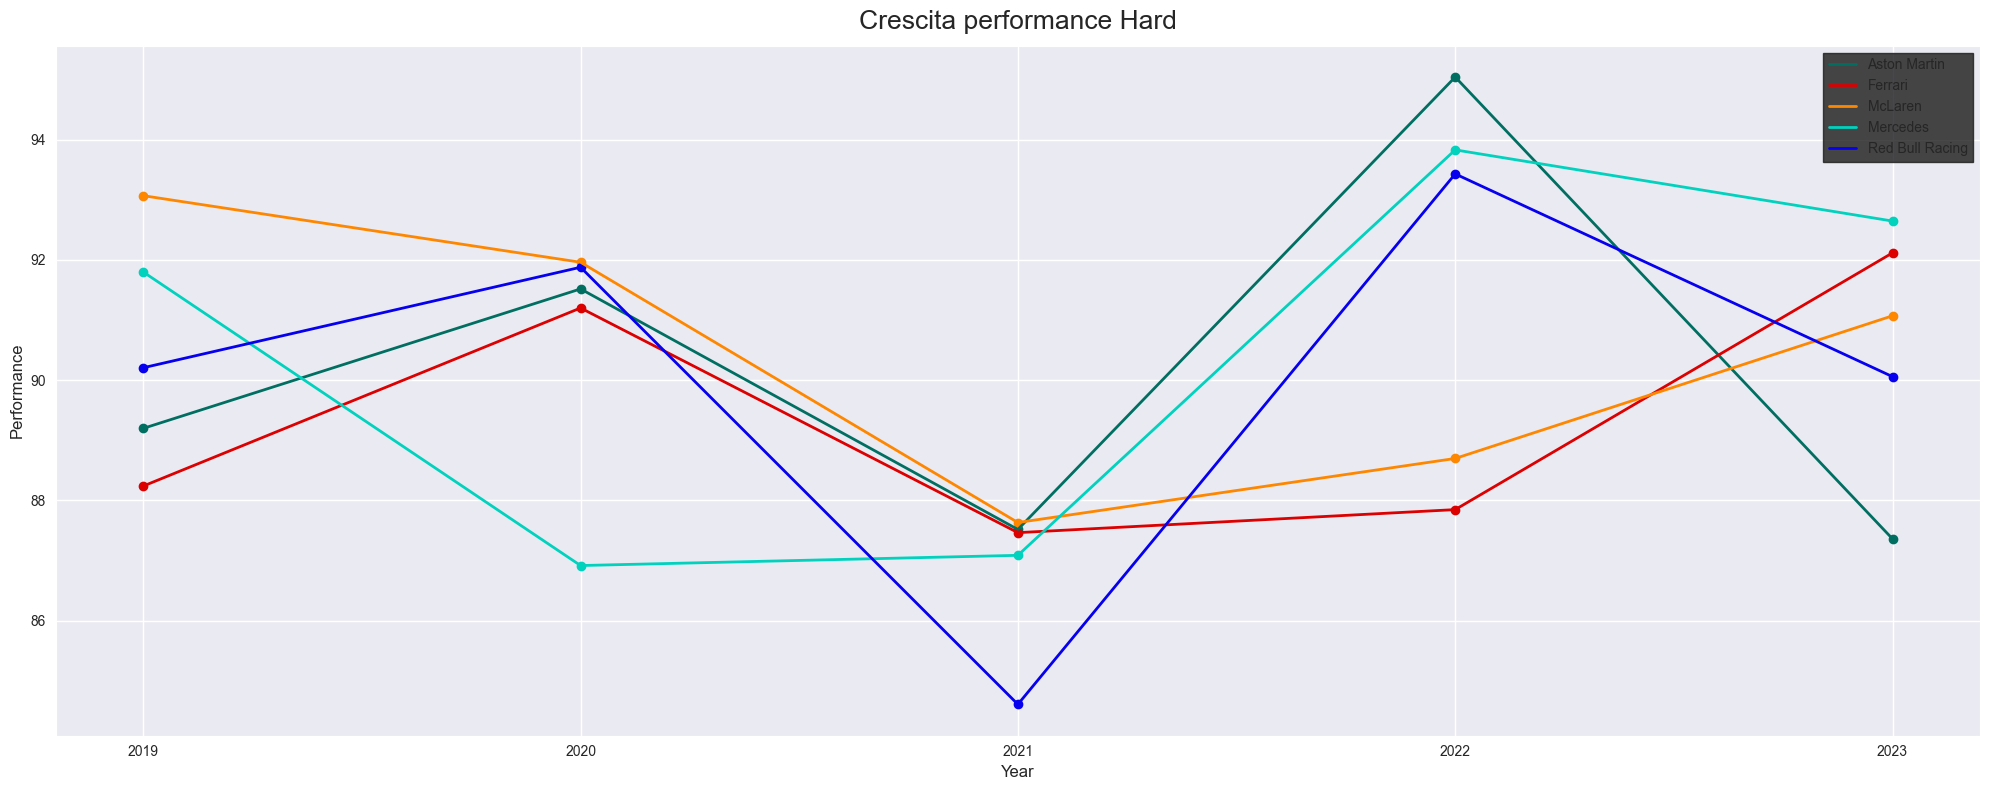

In [93]:
# Grafico con punti
fig, ax = plt.subplots(figsize=(20, 8))

for team in pd.unique(hd_growth['Team']):
    team_laps = hd_growth.loc[hd_growth['Team'] == team]
    abb = team_laps['Team'].iloc[0]
    color = team_palette[team]

    ax.plot(team_laps['Year'], team_laps['LapTime_seconds'],
            label=abb, color=color)
    
    # Aggiungi i punti per ogni anno
    ax.scatter(team_laps['Year'], team_laps['LapTime_seconds'], color=color)
    
    
ax.set_xlabel('Year')
ax.set_ylabel('Performance')
ax.set_title('Crescita performance Hard')
    
ax.legend(bbox_to_anchor=(1.0, 1.0))

# Imposta l'asse x con una scala di 1
plt.xticks(np.arange(min(hd_growth['Year']), max(hd_growth['Year'])+1, 1))

plt.tight_layout()
plt.show()


In [92]:
# Calcola la deviazione standard per i tempi di giro per ogni team
std_deviation_by_team = hd_growth.groupby('Team')['LapTime_seconds'].std()

# Stampa la deviazione standard per ogni team
print("Deviazione standard dei tempi di giro per team:")
print(std_deviation_by_team)

# Calcola la deviazione standard per i tempi di giro per ogni anno
std_deviation_by_year = hd_growth.groupby('Year')['LapTime_seconds'].std()

# Stampa la deviazione standard per ogni anno
print("\nDeviazione standard dei tempi di giro per anno:")
print(std_deviation_by_year)

Deviazione standard dei tempi di giro per team:
Team
Aston Martin       3.218996
Ferrari            2.129711
McLaren            2.266089
Mercedes           3.236231
Red Bull Racing    3.333091
Name: LapTime_seconds, dtype: float64

Deviazione standard dei tempi di giro per anno:
Year
2019    1.948623
2020    2.134291
2021    1.276659
2022    3.261967
2023    2.091672
Name: LapTime_seconds, dtype: float64


###  
### MEDIUM:

In [32]:
scaler = StandardScaler()

# Adatta lo scaler ai dati e standardizza i dati
md_mean_times = data_mean_times.loc[data_mean_times['Compound'] == 'MEDIUM'].copy()
md_mean_times['StandardizedData'] = scaler.fit_transform(md_mean_times[['LapTime_seconds']])

In [33]:
md_growth = md_mean_times.groupby(['Team', 'Year'], as_index=False).mean()
md_growth.head()

Team  Year  LapTime_seconds  StandardizedData
0  Alfa Romeo  2019        93.674718          0.339856
1  Alfa Romeo  2020        86.684471         -0.234966
2  Alfa Romeo  2021        88.691190         -0.069949
3  Alfa Romeo  2022        88.242790         -0.106822
4  Alfa Romeo  2023        92.278082          0.225008

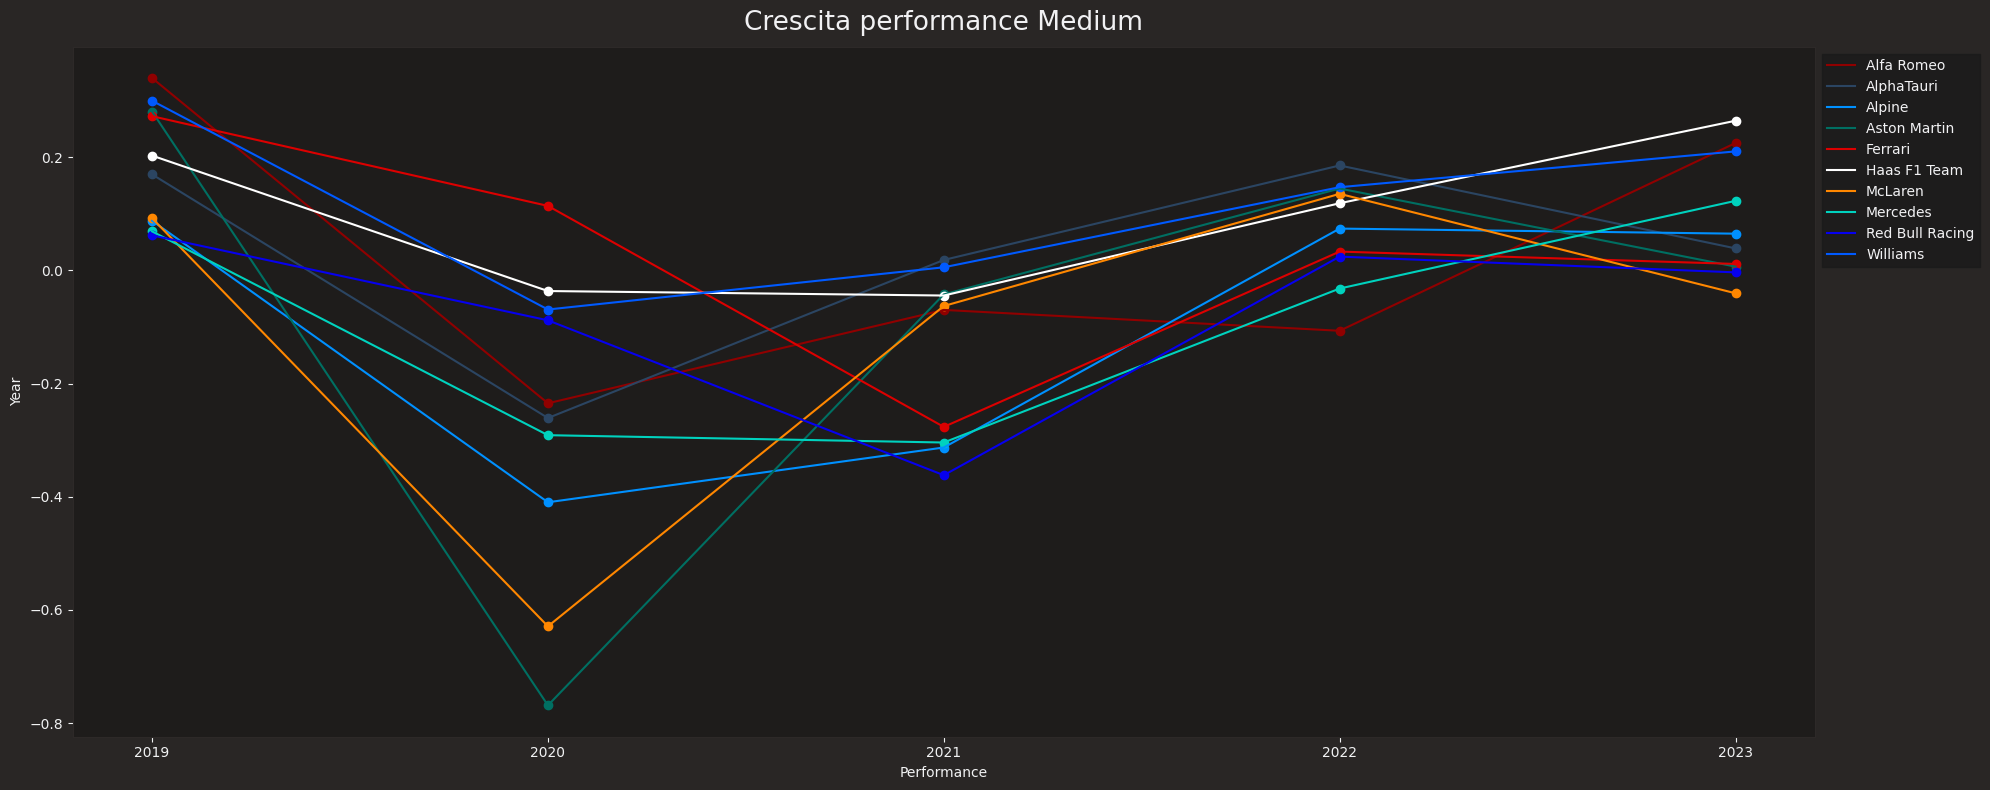

In [34]:
# Grafico con punti
fig, ax = plt.subplots(figsize=(20, 8))

for team in pd.unique(md_growth['Team']):
    team_laps = md_growth.loc[md_growth['Team'] == team]
    abb = team_laps['Team'].iloc[0]
    color = team_palette[team]

    ax.plot(team_laps['Year'], team_laps['StandardizedData'],
            label=abb, color=color)
    
    # Aggiungi i punti per ogni anno
    ax.scatter(team_laps['Year'], team_laps['StandardizedData'], color=color)
    
    
ax.set_xlabel('Performance')
ax.set_ylabel('Year')
ax.set_title('Crescita performance Medium')
    
ax.legend(bbox_to_anchor=(1.0, 1.0))

# Imposta l'asse x con una scala di 1
plt.xticks(np.arange(min(md_growth['Year']), max(md_growth['Year'])+1, 1))

plt.tight_layout()
plt.show()


###
### SOFT:

In [35]:
scaler = StandardScaler()

# Adatta lo scaler ai dati e standardizza i dati
sf_mean_times = data_mean_times.loc[data_mean_times['Compound'] == 'SOFT'].copy()
sf_mean_times['StandardizedData'] = scaler.fit_transform(sf_mean_times[['LapTime_seconds']])

In [36]:
sf_growth = sf_mean_times.groupby(['Team', 'Year'], as_index=False).mean()
sf_growth.head()

Team  Year  LapTime_seconds  StandardizedData
0  Alfa Romeo  2019        89.398827          0.085579
1  Alfa Romeo  2020        79.262996         -0.716683
2  Alfa Romeo  2021        89.756472          0.113887
3  Alfa Romeo  2022        90.735886          0.191409
4  Alfa Romeo  2023        93.519129          0.411706

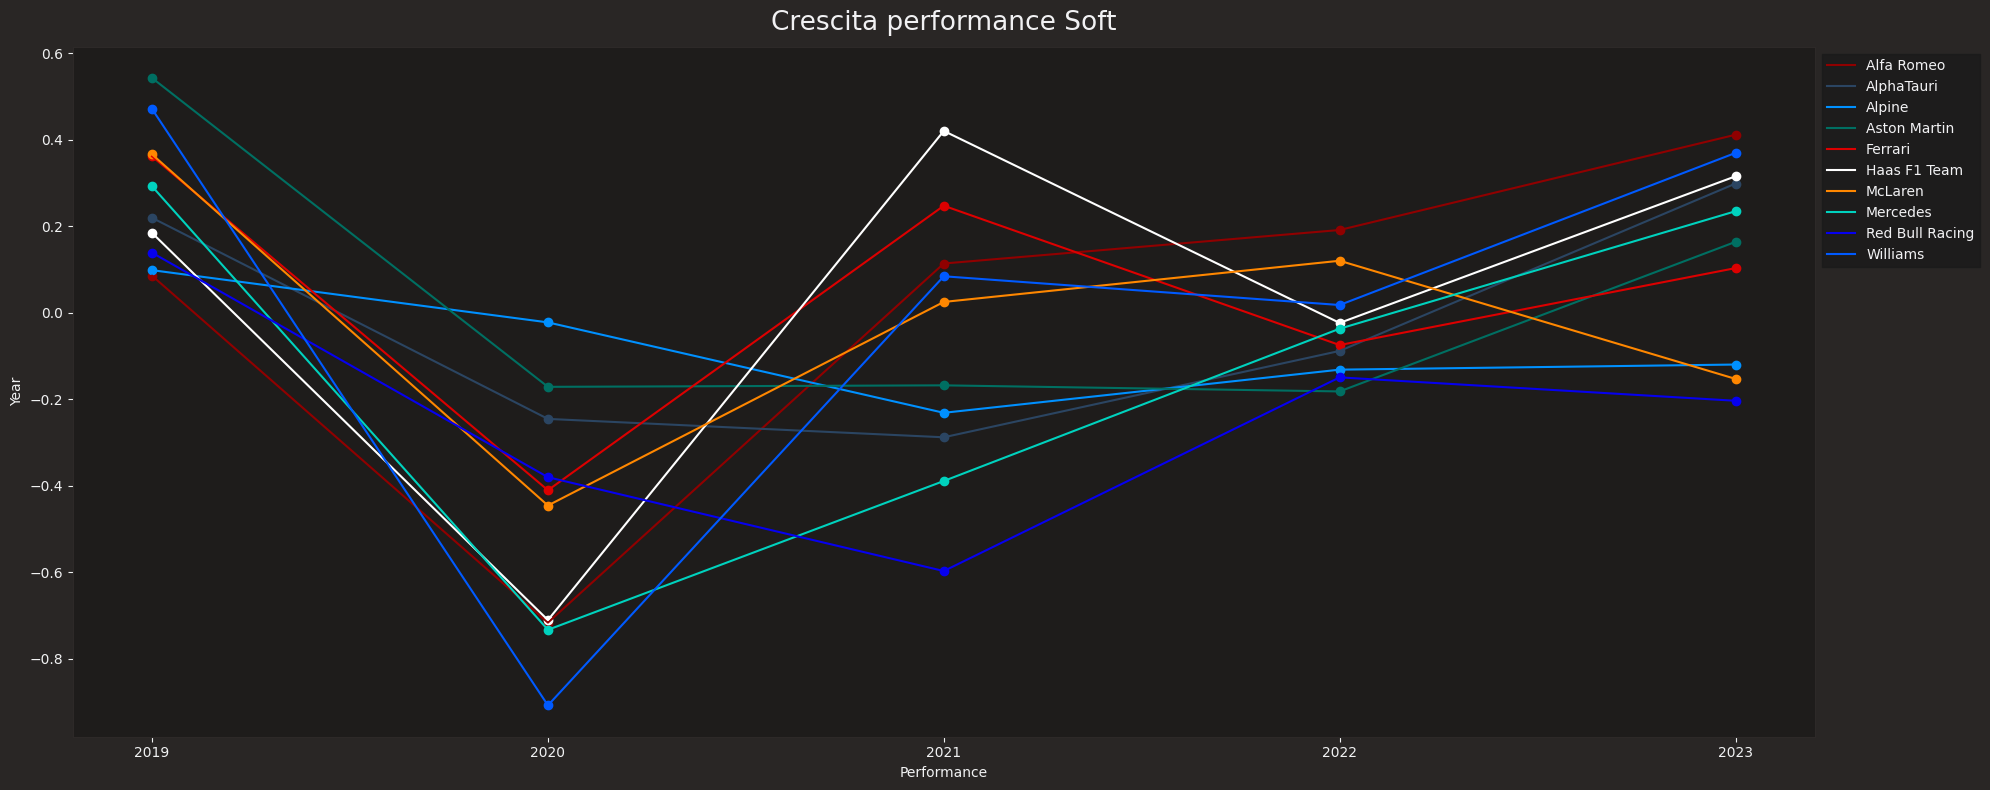

In [37]:
# Grafico con punti
fig, ax = plt.subplots(figsize=(20, 8))

for team in pd.unique(md_growth['Team']):
    team_laps = sf_growth.loc[sf_growth['Team'] == team]
    abb = team_laps['Team'].iloc[0]
    color = team_palette[team]

    ax.plot(team_laps['Year'], team_laps['StandardizedData'],
            label=abb, color=color)
    
    # Aggiungi i punti per ogni anno
    ax.scatter(team_laps['Year'], team_laps['StandardizedData'], color=color)
    
    
ax.set_xlabel('Performance')
ax.set_ylabel('Year')
ax.set_title('Crescita performance Soft')
    
ax.legend(bbox_to_anchor=(1.0, 1.0))

# Imposta l'asse x con una scala di 1
plt.xticks(np.arange(min(sf_growth['Year']), max(sf_growth['Year'])+1, 1))

plt.tight_layout()
plt.show()


## CAPITOLO 4: PRESTAZIONI SULLE DIVERSE MESCOLE
Vengono presi per ogni gp la media dei tempi raggruppati per mescolta di tutti i team, viene calcolata la media dei tempi per team e confrontata con la media totale.

In [49]:
team_5 = ['Ferrari', 'Mercedes', 'McLaren', 'Red Bull Racing', 'Aston Martin']
Performance_5 = tempi.loc[(tempi['Team'].isin(team_5))  & (tempi['GP'] == 'Qatar Grand Prix') & (tempi['Year'] == 2023)]

In [298]:
team_palette = {
    'Alfa Romeo': '#900000',
    'AlphaTauri': '#2b4562',
    'Alpine': '#0090ff',
    'Aston Martin': '#006f62',
    'Ferrari': '#dc0000',
    'Haas F1 Team': 'black',
    'McLaren': '#ff8700',
    'Mercedes': '#00d2be',
    'Red Bull Racing': '#0600ef',
    'Williams': '#005aff',
}

print(team_palette)

team_5 = ['Ferrari', 'Mercedes', 'McLaren', 'Red Bull Racing', 'Aston Martin']

tempi2023 = tempi.loc[(tempi['Team'].isin(team_5)) & (tempi['Year'] == 2023)]

{'Alfa Romeo': '#900000', 'AlphaTauri': '#2b4562', 'Alpine': '#0090ff', 'Aston Martin': '#006f62', 'Ferrari': '#dc0000', 'Haas F1 Team': 'black', 'McLaren': '#ff8700', 'Mercedes': '#00d2be', 'Red Bull Racing': '#0600ef', 'Williams': '#005aff'}


NameError: name 'tempi' is not defined

In [99]:
mean_gp_compound = tempi2023.groupby(['GP', 'Compound'])['LapTime_s'].mean().reset_index()

mean_gp_team_compound = tempi2023.groupby(['GP', 'Team', 'Compound'])['LapTime_s'].mean().reset_index()

C:\Users\lavigi\AppData\Local\Temp\ipykernel_5964\2084996710.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_compound, x='GP', y='LapTime_s', hue='Team', style='Team', ci=None)


NameError: name 'media_generale_per_gp' is not defined

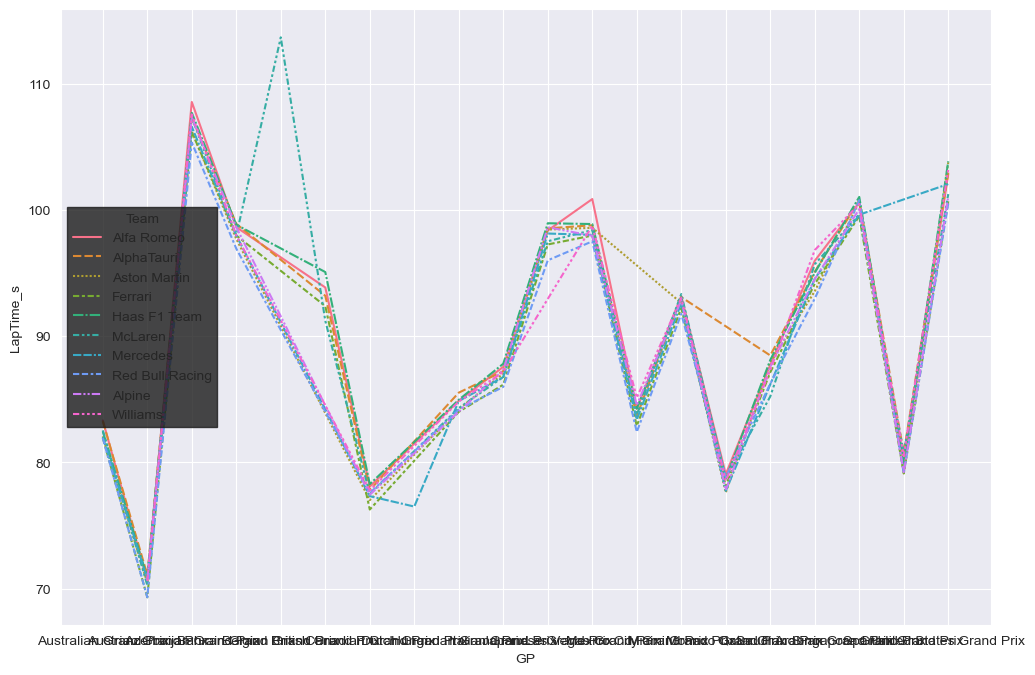

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crea un grafico per ciascun compound
for Compound in mean_gp_compound['Compound'].unique():
    plt.figure(figsize=(12, 8))
    
    # Seleziona i dati solo per il compound corrente
    df_compound = mean_gp_compound[mean_gp_compound['Compound'] == Compound]
    
    # Plotta il trend dei tempi divisi per team
    sns.lineplot(data=df_compound, x='GP', y='LapTime_s', hue='Team', style='Team', ci=None)
    
    # Plotta la media generale per compound e GP come linea tratteggiata
    for gp in mean_gp_compound['GP'].unique():
        media_gp = mean_gp_compound[(media_generale_per_gp['Compound'] == compound) & (media_generale_per_gp['GP'] == gp)]
        plt.plot(media_gp['GP'], media_gp['LapTime_s'], linestyle='--', color='grey', linewidth=1)
    
    plt.title(f'Trend dei tempi per il compound {compound}')
    plt.xlabel('Anno')
    plt.ylabel('Tempo sul giro (secondi)')
    plt.legend(title='Team', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()


In [101]:
mean_gp_hd = mean_gp_compound.loc[mean_gp_compound['Compound'] == 'HARD']
mean_gp_team_hd = mean_gp_team_compound[mean_gp_team_compound['Compound'] == 'HARD']

In [103]:
mean_gp_team_hd

GP             Team Compound   LapTime_s
0       Australian Grand Prix     Aston Martin     HARD   82.070537
2       Australian Grand Prix          Ferrari     HARD   81.959366
4       Australian Grand Prix          McLaren     HARD   82.539195
6       Australian Grand Prix         Mercedes     HARD   82.008341
8       Australian Grand Prix  Red Bull Racing     HARD   81.923337
..                        ...              ...      ...         ...
209  United States Grand Prix     Aston Martin     HARD  103.758647
211  United States Grand Prix          Ferrari     HARD  100.678737
213  United States Grand Prix          McLaren     HARD  101.247714
215  United States Grand Prix         Mercedes     HARD  102.043500
217  United States Grand Prix  Red Bull Racing     HARD  100.507081

[87 rows x 4 columns]

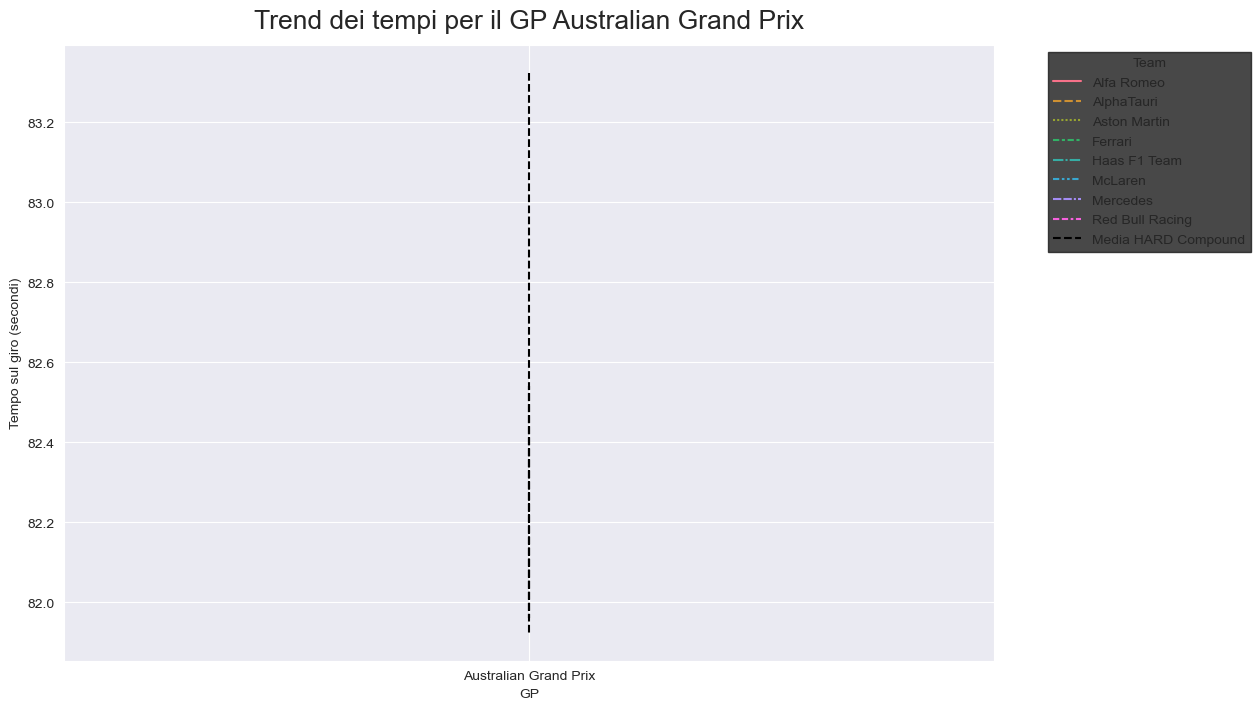

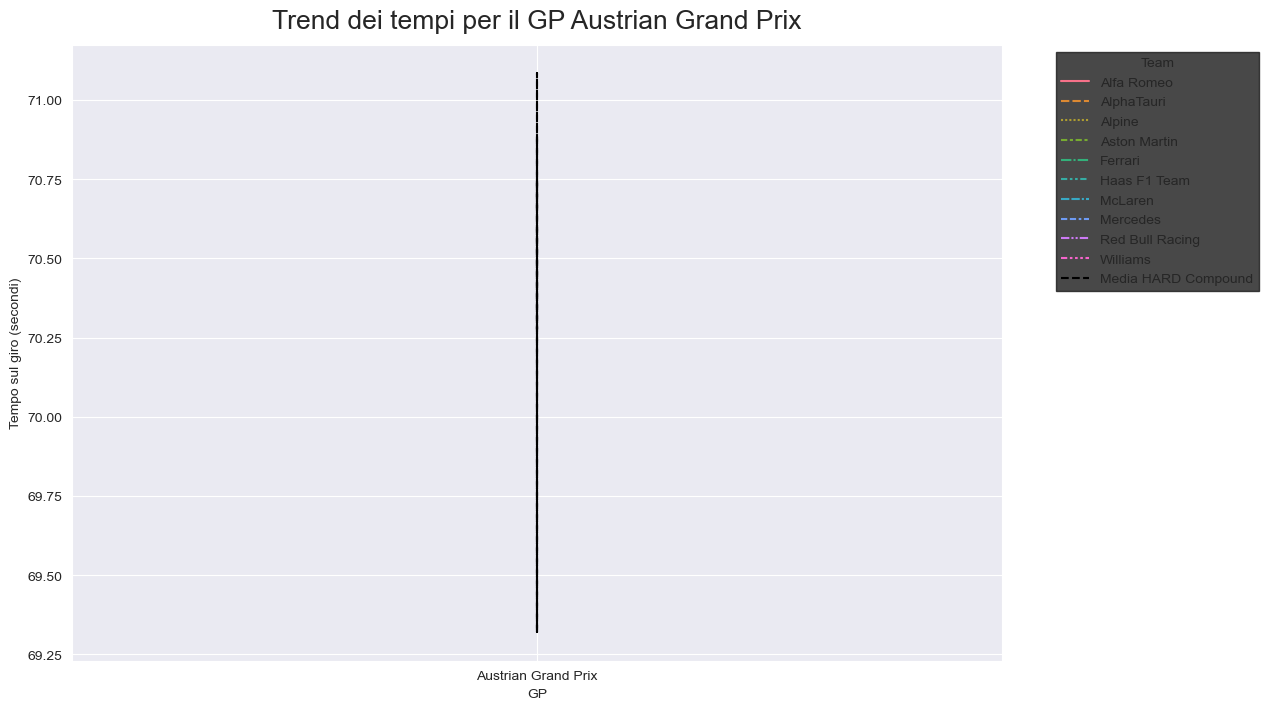

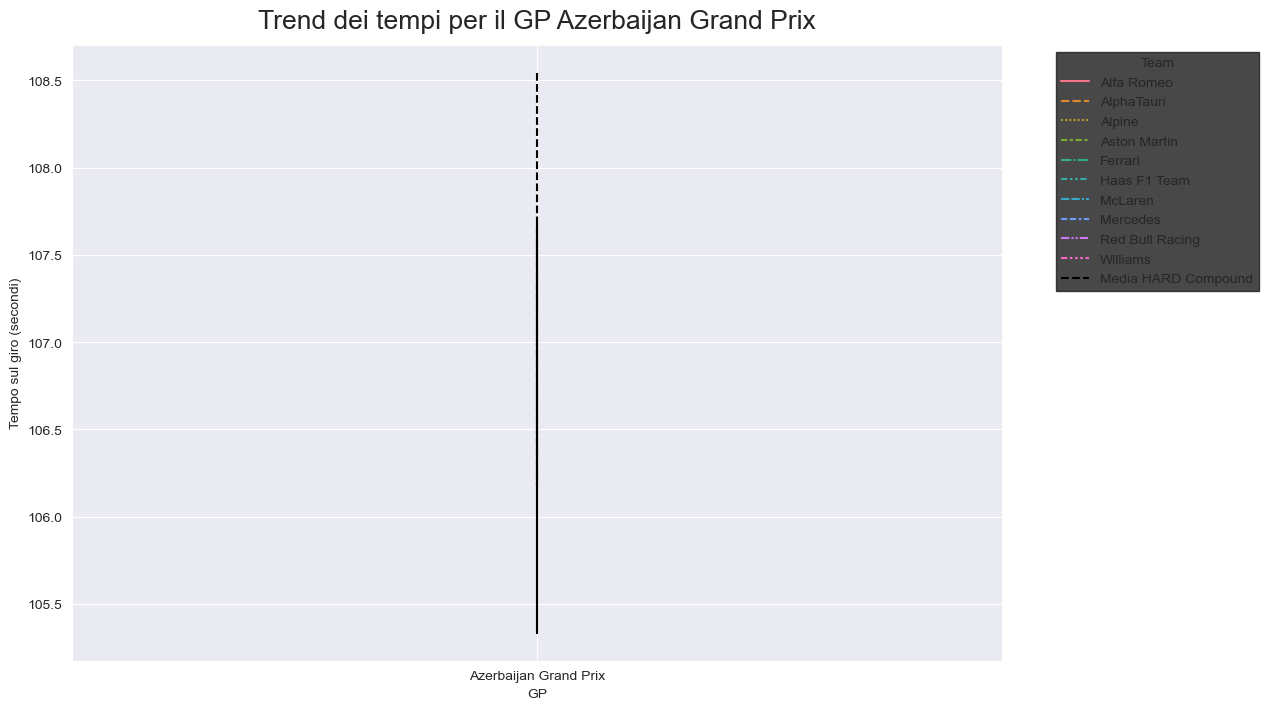

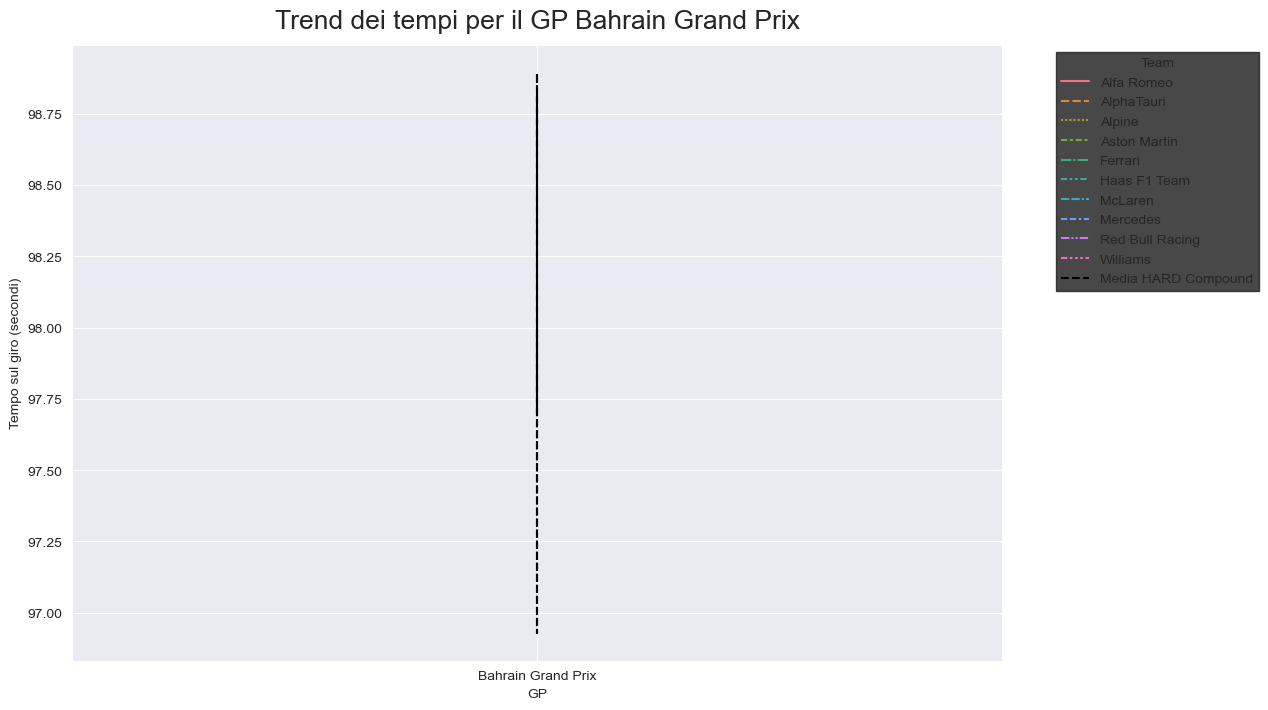

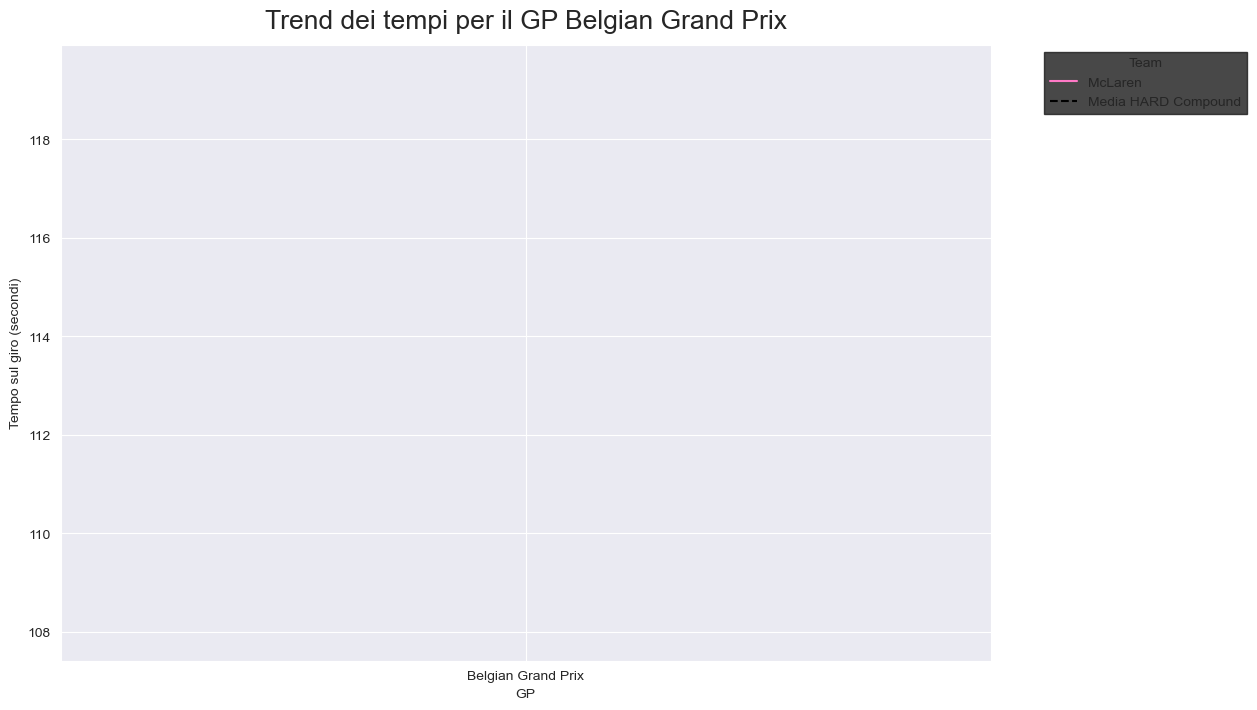

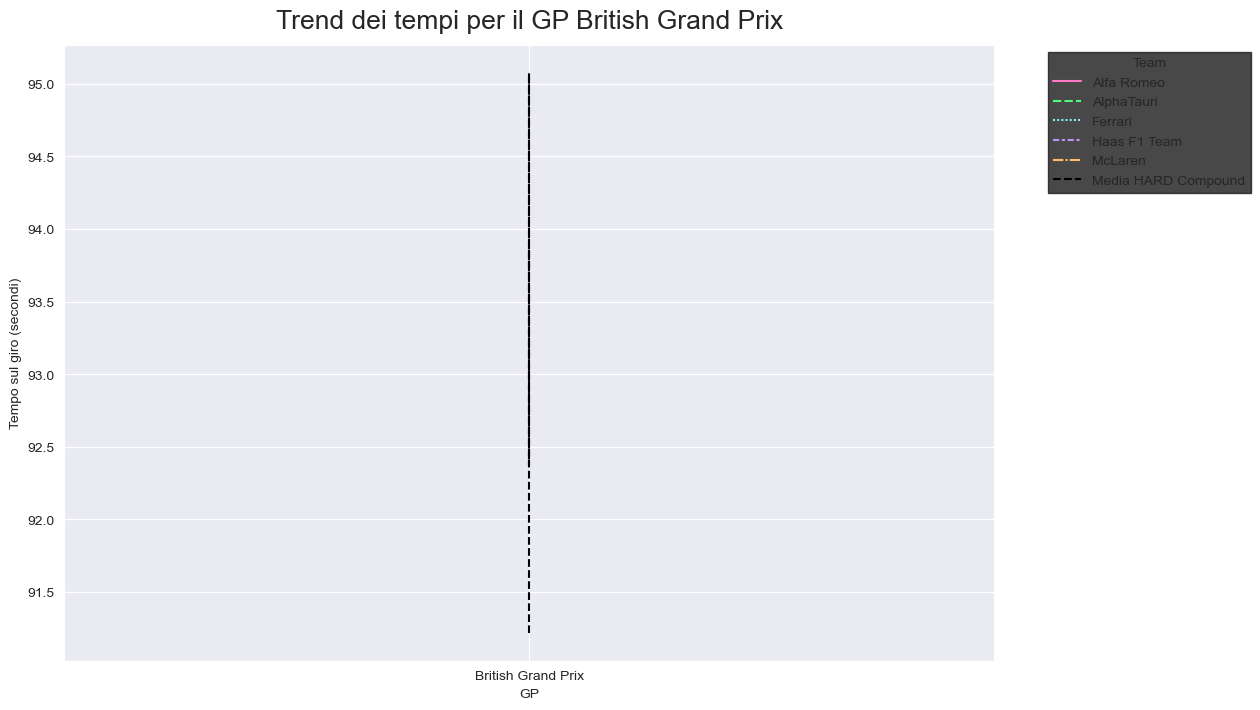

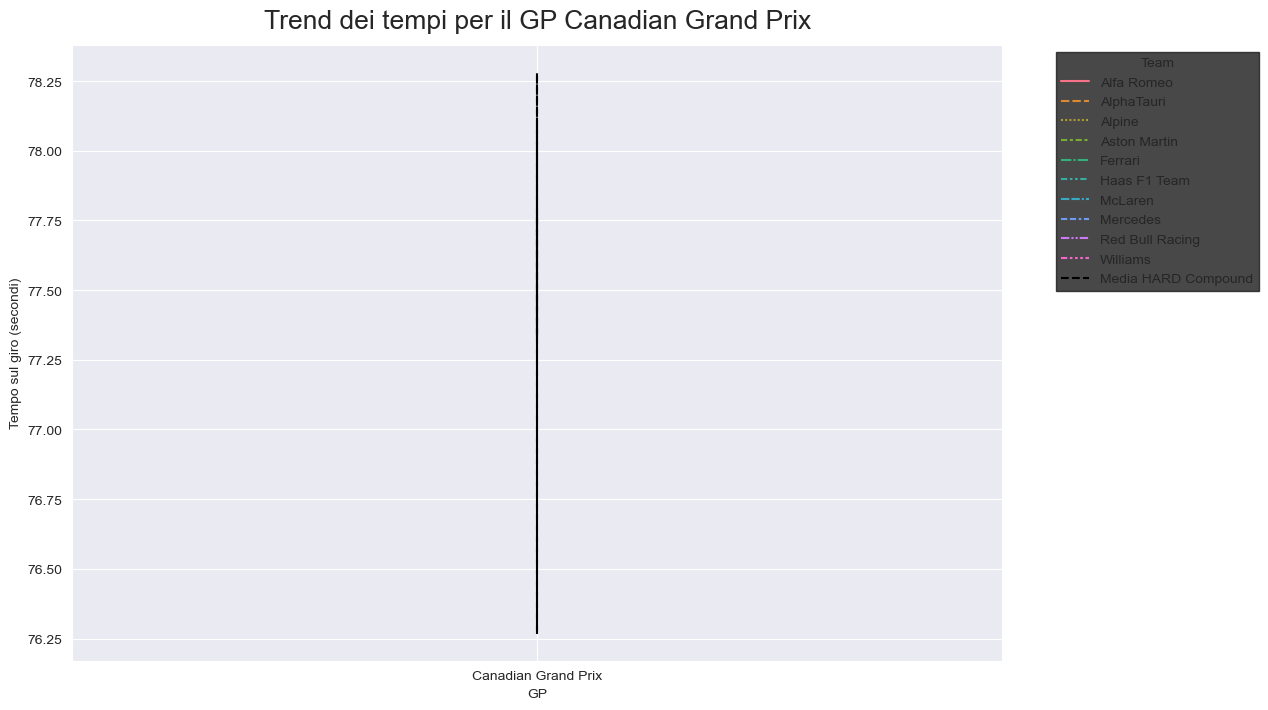

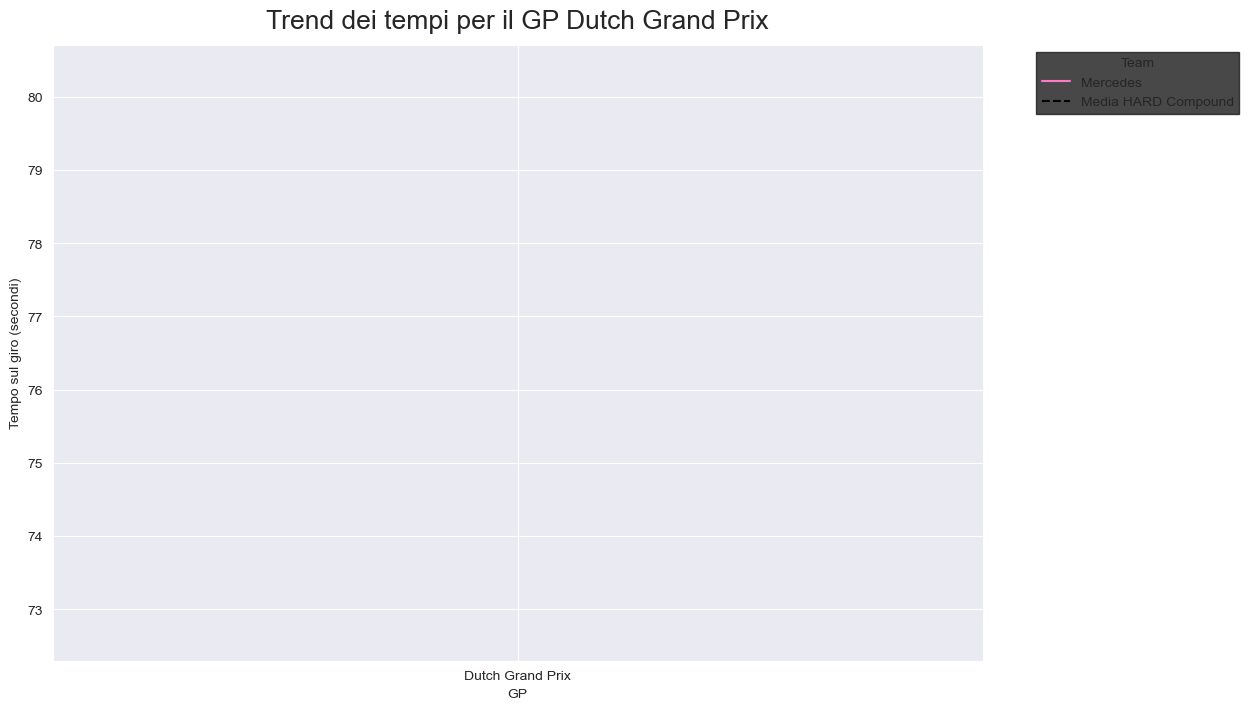

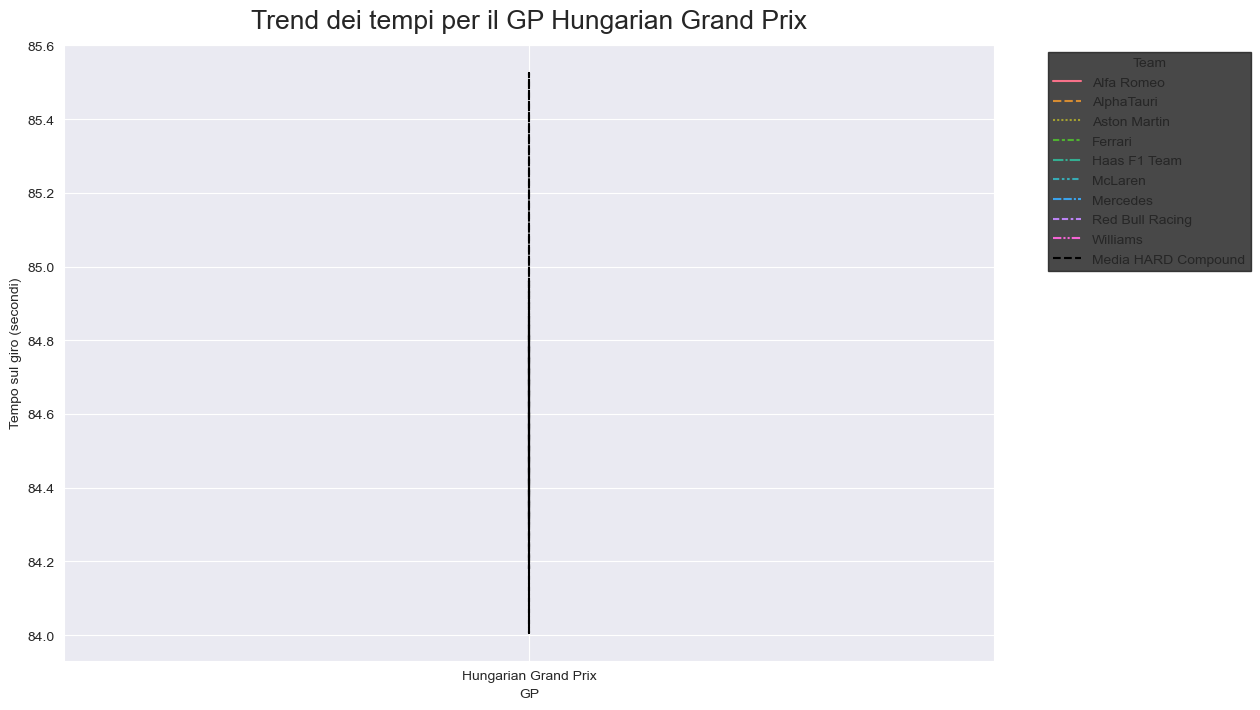

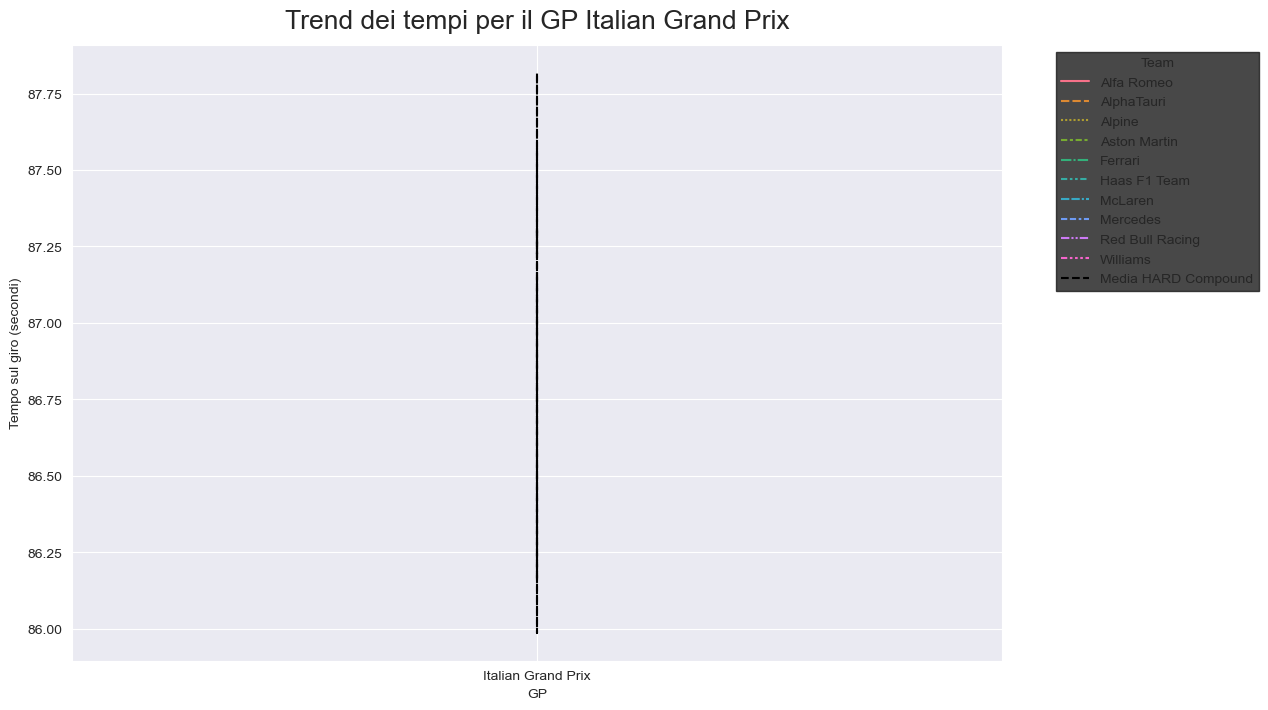

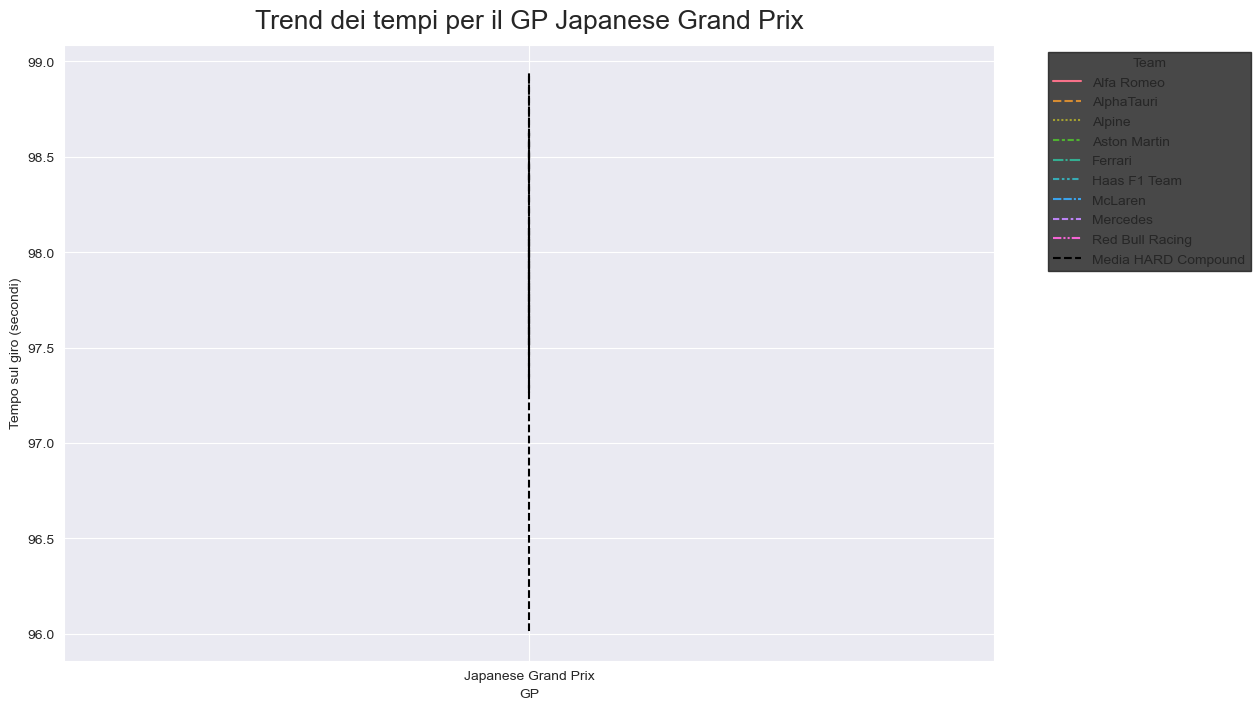

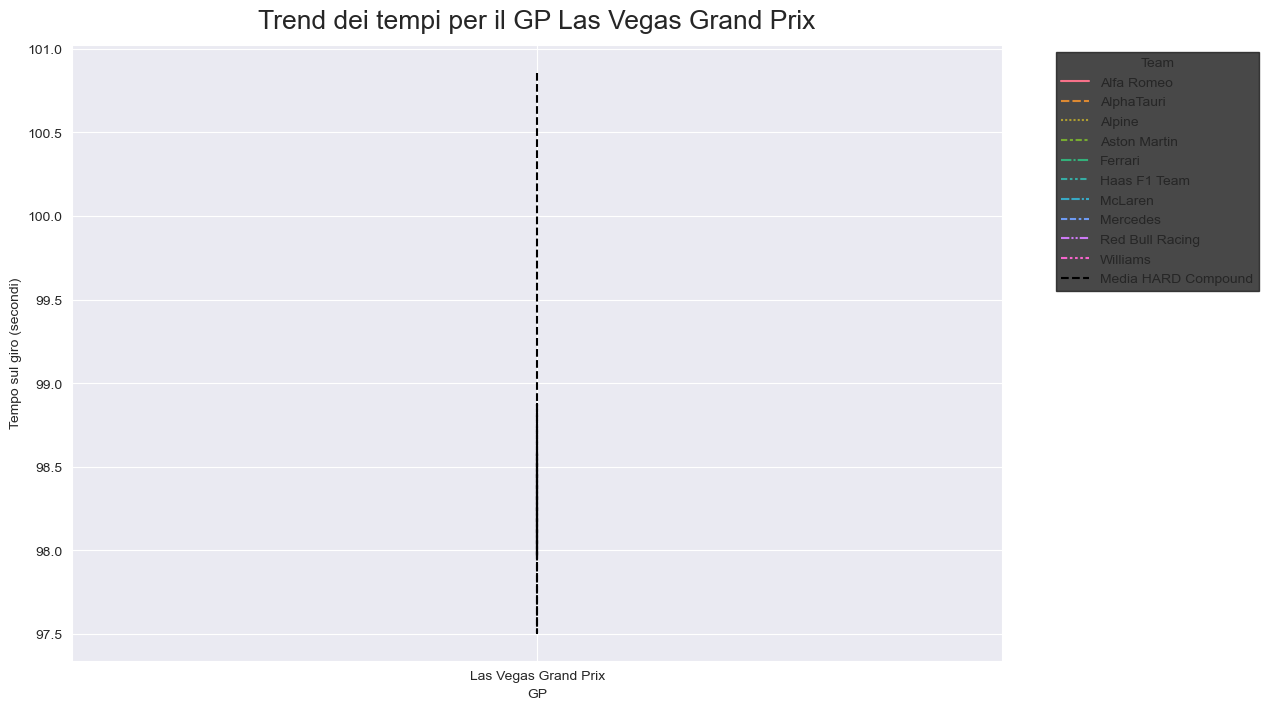

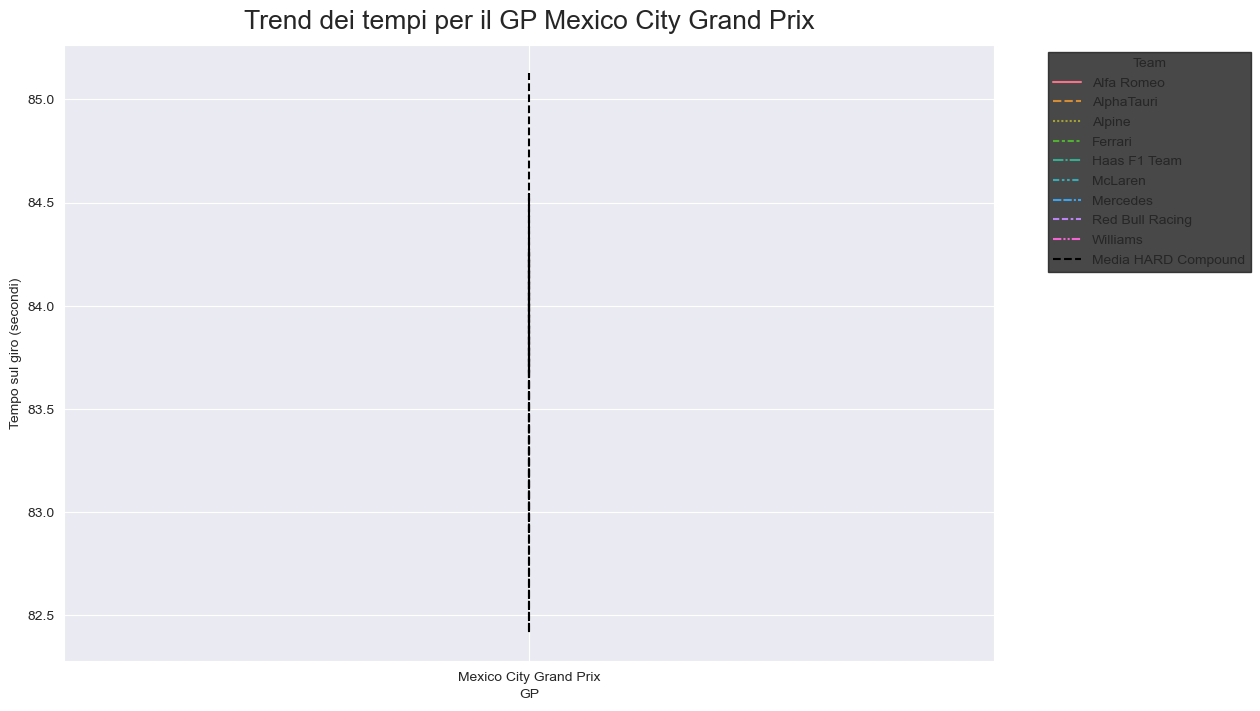

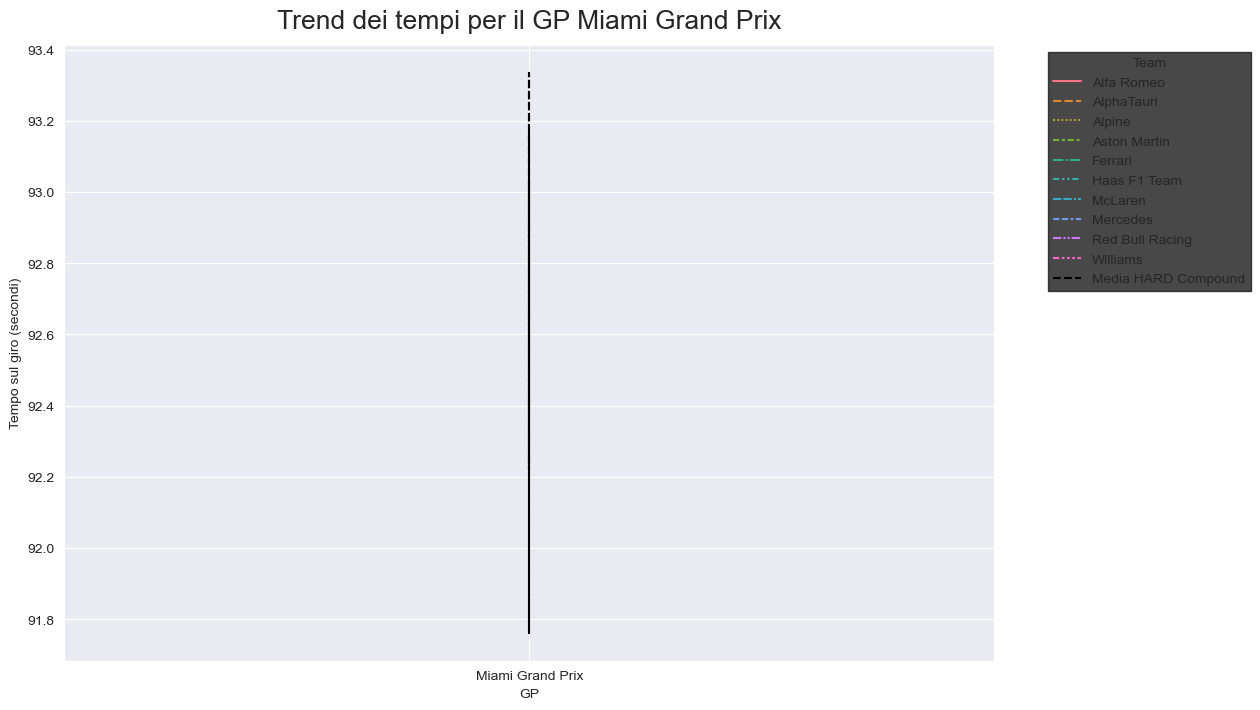

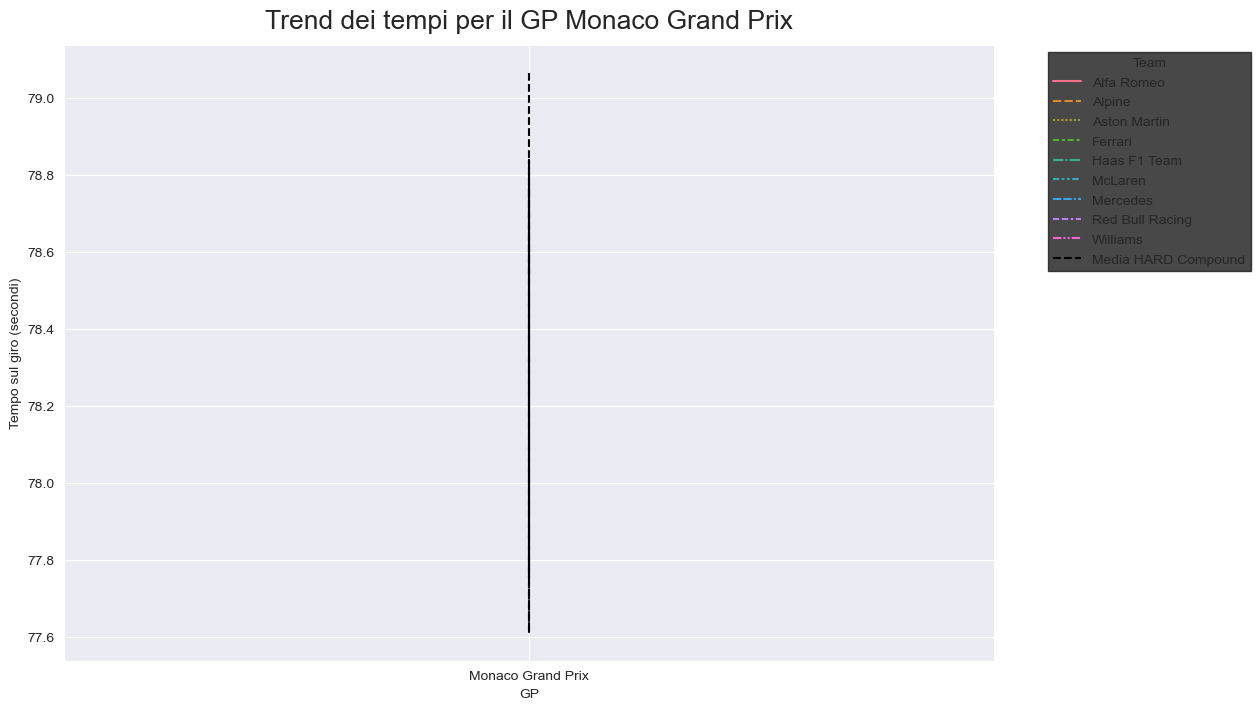

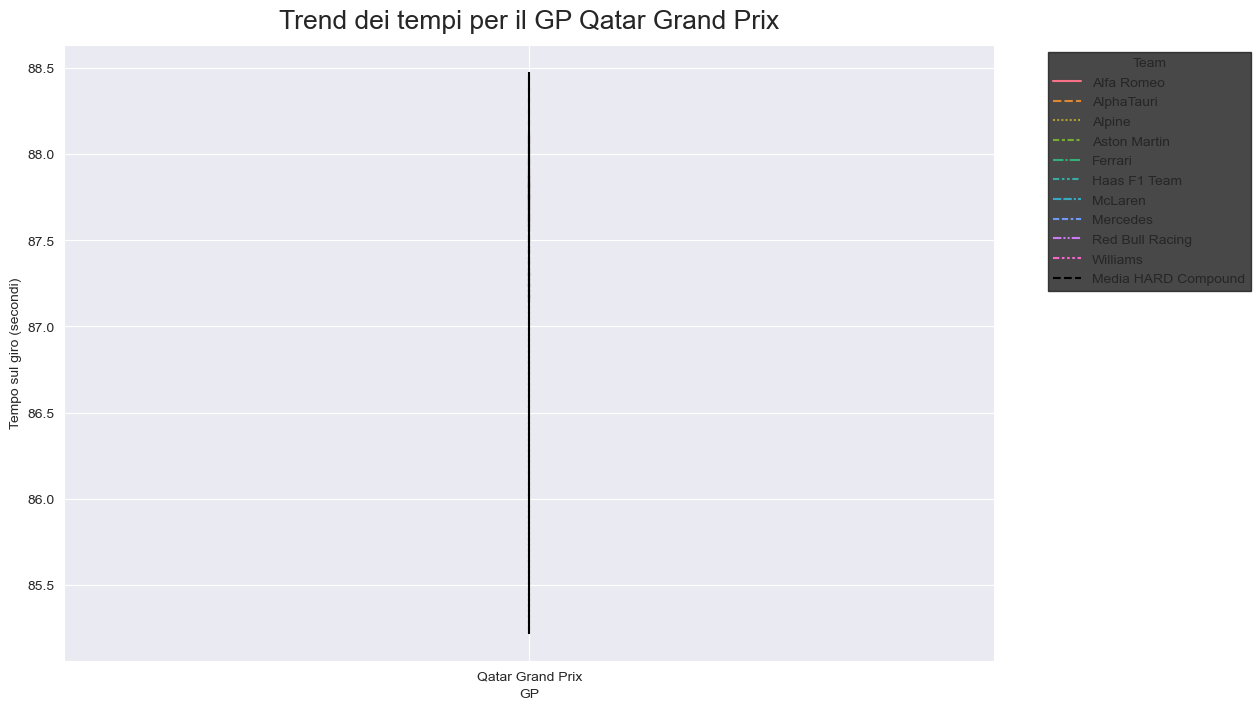

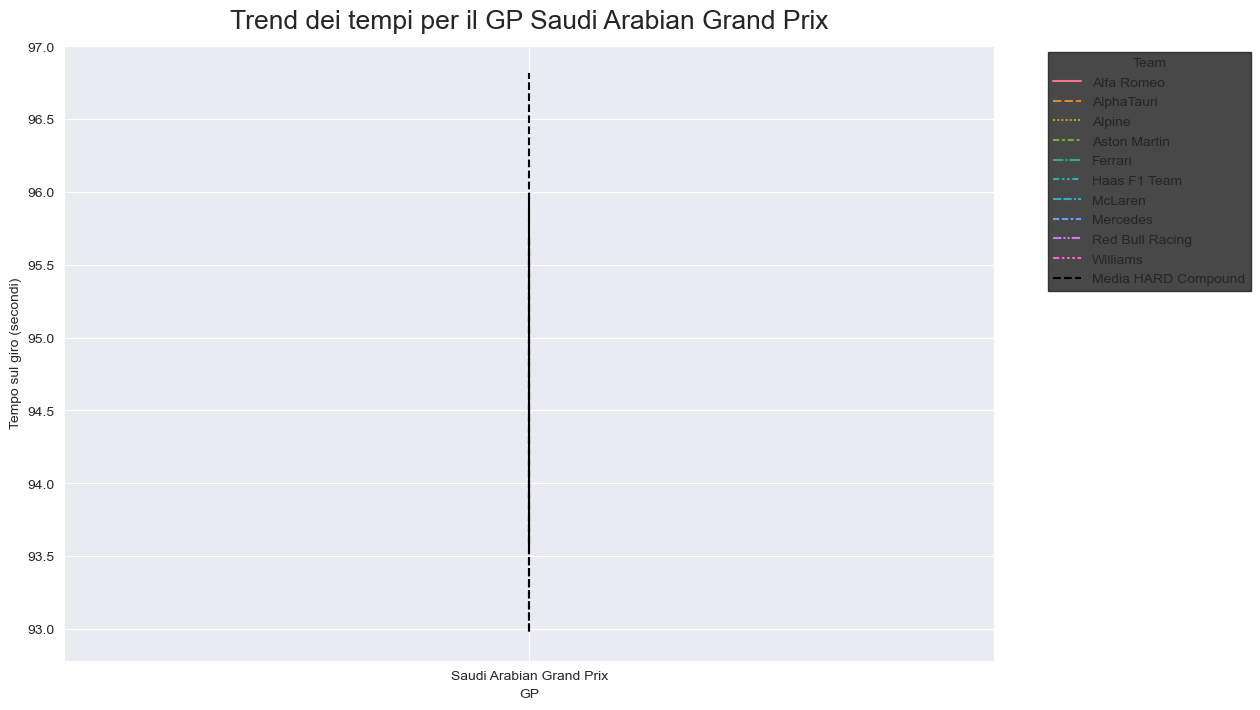

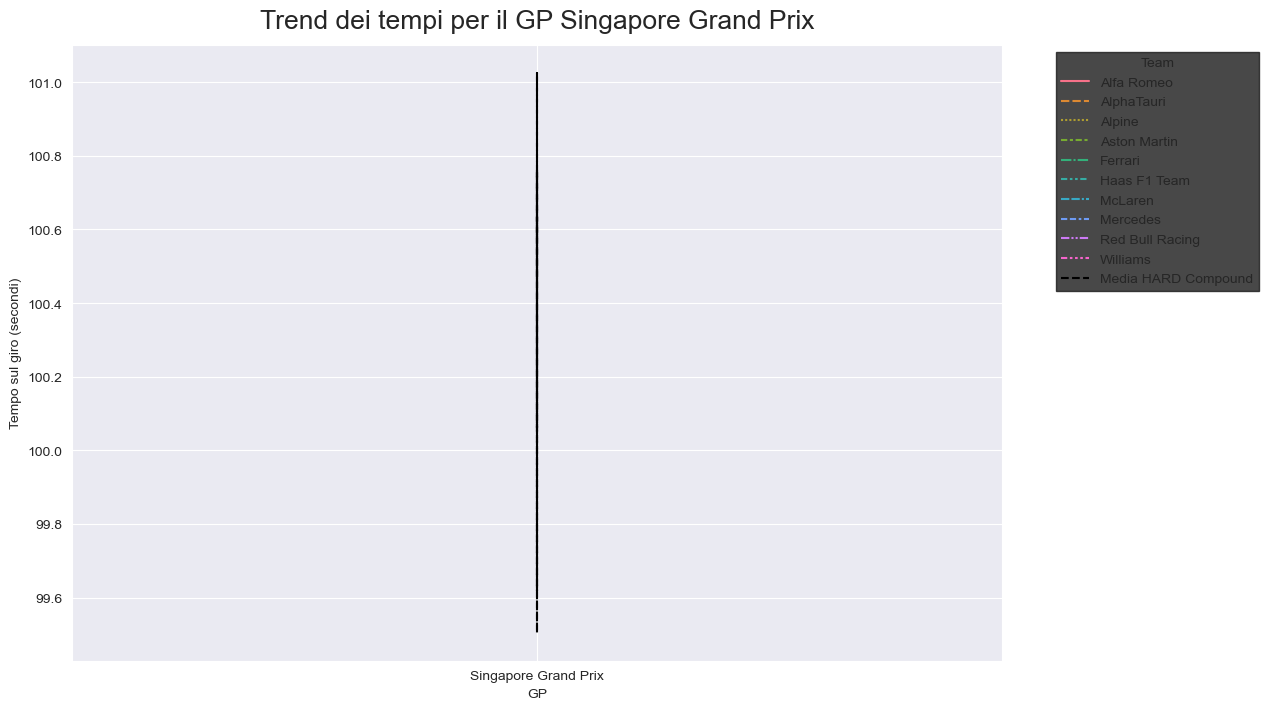

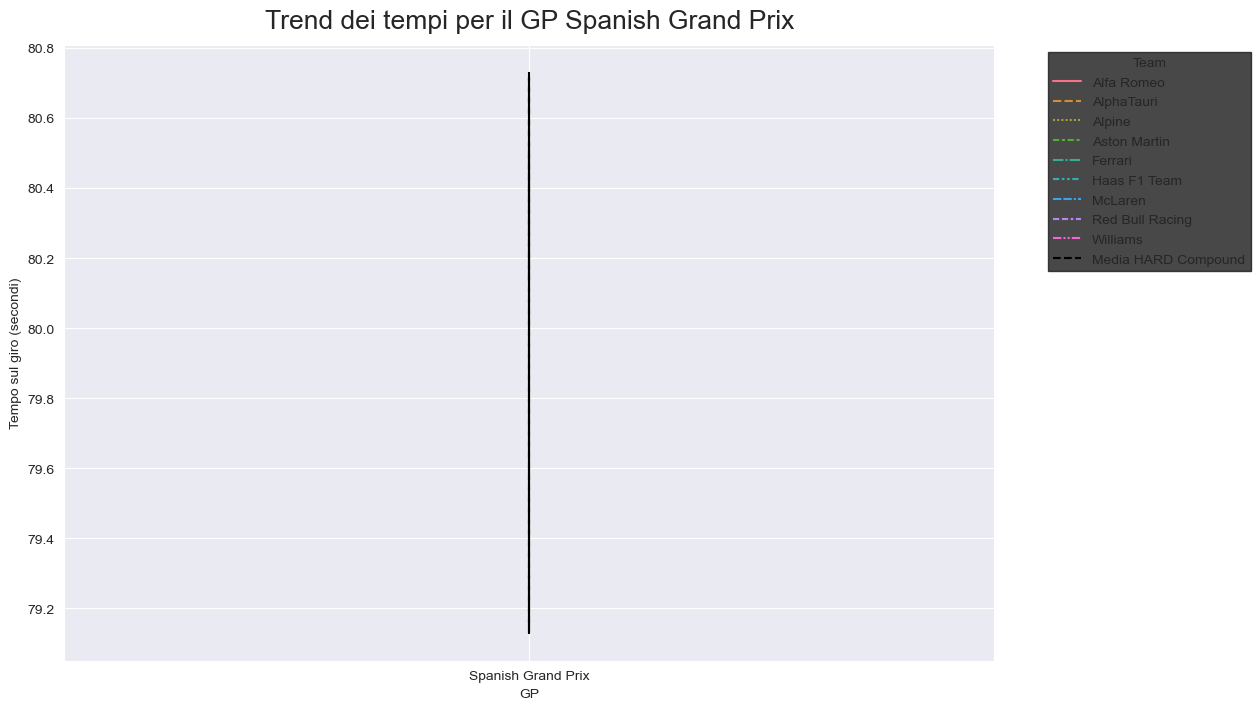

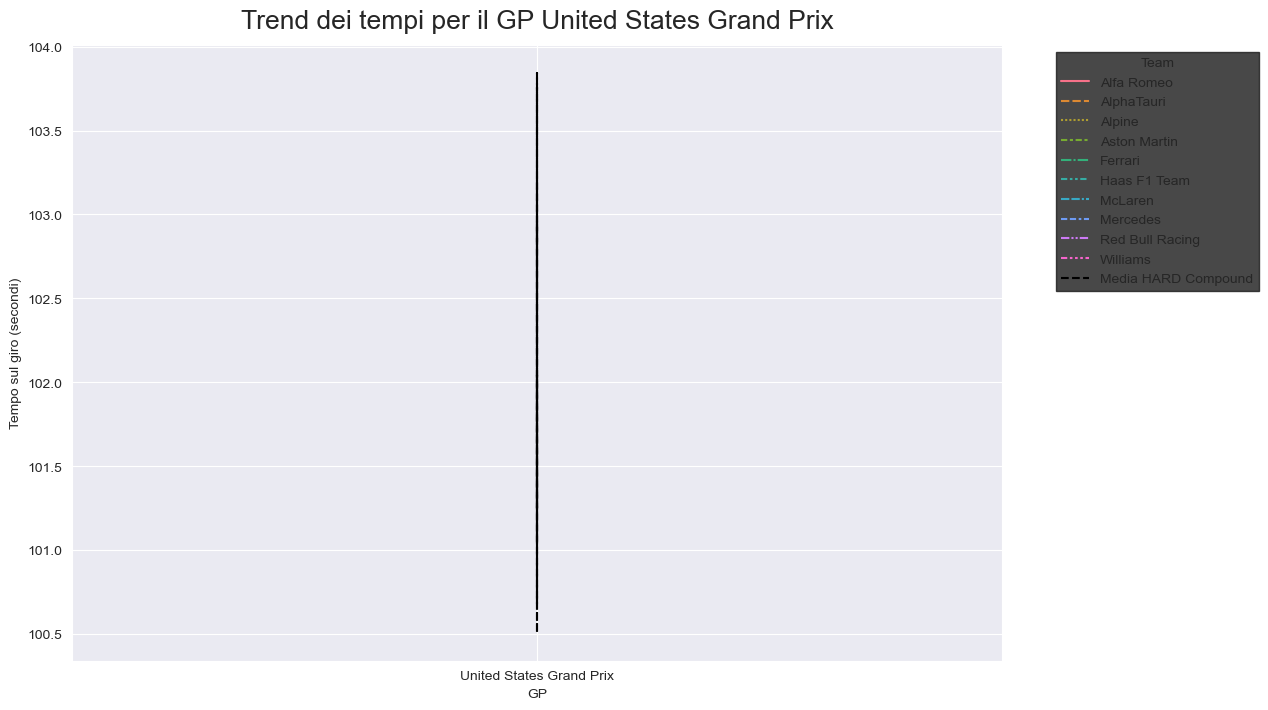

In [85]:
for gp in mean_gp_team_hd['GP'].unique():
    plt.figure(figsize=(12, 8))
    
    # Seleziona i dati solo per il GP corrente
    df_gp = mean_gp_team_hd[mean_gp_team_hd['GP'] == gp]
    
    # Plotta il trend dei tempi divisi per team
    sns.lineplot(data=df_gp, x='GP', y='LapTime_s', hue='Team', style='Team', errorbar=None)
    
    # Plotta la sesta linea per la media generale del compound 'HARD'
    df_gp = mean_gp_hd.loc[mean_gp_compound['GP'] == gp]
    plt.plot(df_gp['GP'], df_gp['LapTime_s'], linestyle='--', color='black', label='Media HARD Compound')
    
    plt.title(f'Trend dei tempi per il GP {gp}')
    plt.xlabel('GP')
    plt.ylabel('Tempo sul giro (secondi)')
    plt.legend(title='Team', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()

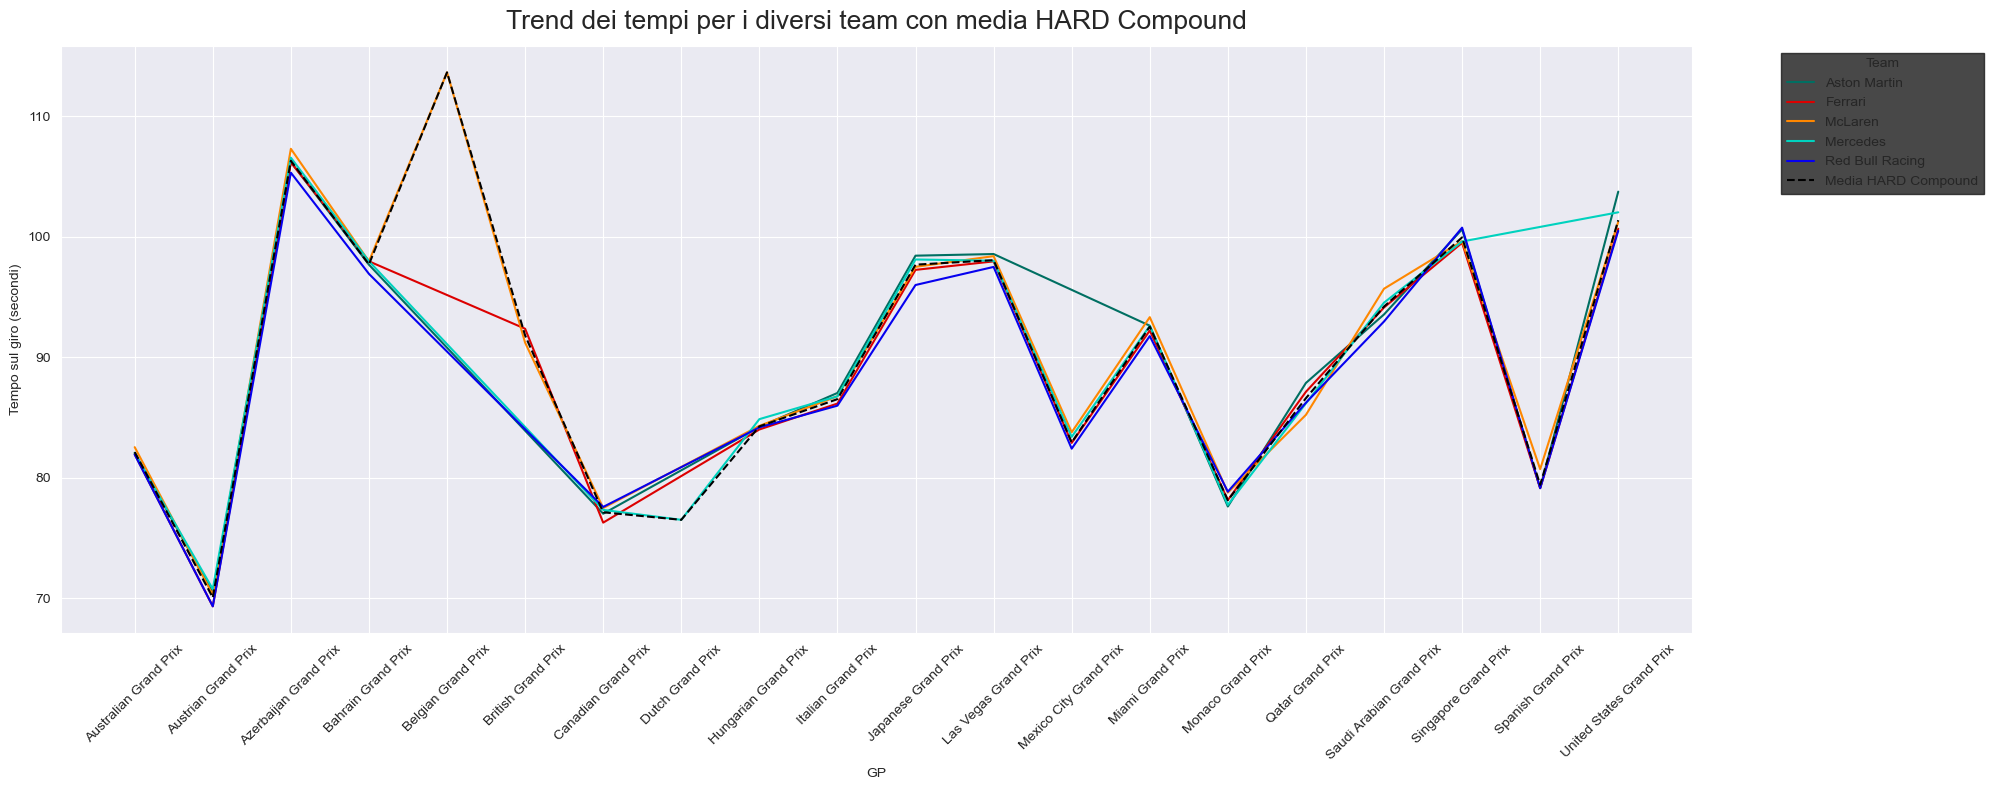

In [115]:
# Creazione del grafico
plt.figure(figsize=(20, 8))

# Plotta i trend dei tempi divisi per team
sns.lineplot(data=mean_gp_team_hd, x='GP', y='LapTime_s', hue='Team', errorbar=None, palette=team_palette)

# Plotta la sesta linea per la media generale del compound 'HARD'
sns.lineplot(data=mean_gp_hd, x='GP', y='LapTime_s', color='black', linestyle='--', label='Media HARD Compound')

# Impostazioni del grafico
plt.title('Trend dei tempi per i diversi team con media HARD Compound')
plt.xlabel('GP')
plt.ylabel('Tempo sul giro (secondi)')
plt.legend(title='Team', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.xticks(rotation=45)  # Ruota le etichette sull'asse x per una migliore leggibilità
plt.tight_layout()
plt.show()

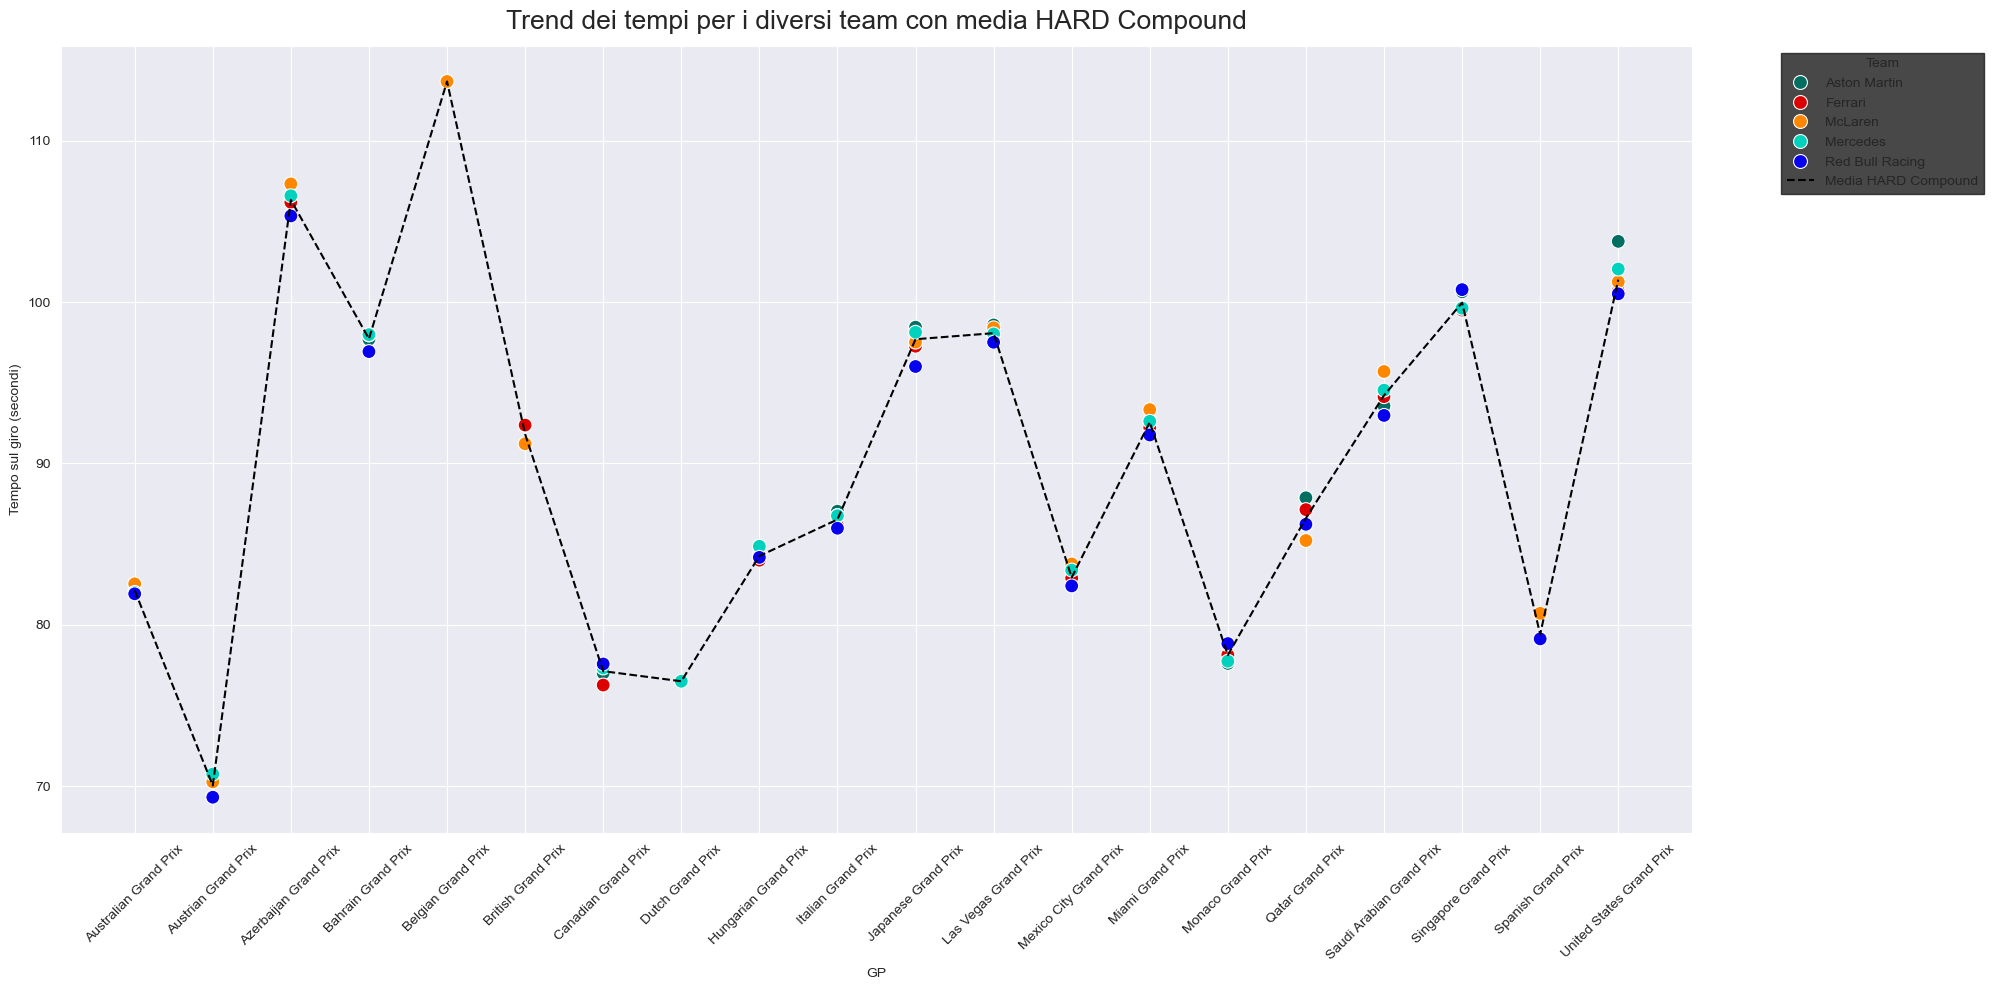

In [117]:
# Creazione del grafico
plt.figure(figsize=(20, 10))

# Plotta i punti dei tempi divisi per team
sns.scatterplot(data=mean_gp_team_hd, x='GP', y='LapTime_s', hue='Team', palette=team_palette, s=100)

# Plotta la sesta linea per la media generale del compound 'HARD'
sns.lineplot(data=mean_gp_hd, x='GP', y='LapTime_s', color='black', linestyle='--', label='Media HARD Compound')

# Impostazioni del grafico
plt.title('Trend dei tempi per i diversi team con media HARD Compound')
plt.xlabel('GP')
plt.ylabel('Tempo sul giro (secondi)')
plt.legend(title='Team', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.xticks(rotation=45)  # Ruota le etichette sull'asse x per una migliore leggibilità
plt.tight_layout()
plt.show()


In [ ]:
Senno fare team pace comparison di tutti i team con i boxplot

## CAPITOLO 4: TELEMETRIE GIRI PIU VELOCI:

In [175]:
gara = fastf1.get_session(2023, 'Qatar Grand Prix', 'R')
gara.load()

req         WARNING 	DEFAULT CACHE ENABLED! (297.36 MB) C:\Users\lavigi\AppData\Local\Temp\fastf1
core           INFO 	Loading data for Qatar Grand Prix - Race [v3.3.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 55
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 55)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_me

In [176]:
# Supponendo che `gara` sia un oggetto FastF1 che hai già caricato
giri_tot = gara.laps

df_tel_tot = pd.DataFrame()

# Ottieni i driver unici correttamente
drivers = giri_tot['Driver'].unique()

# Itera sui driver unici
for drv in drivers:
    # Ottieni i dati telemetrici per ogni driver e aggiungi la distanza
    tel_drv = giri_tot.pick_driver(drv).get_car_data().add_distance()
    
    # Concatena i dati telemetrici al DataFrame totale
    df_tel_tot = pd.concat([df_tel_tot, tel_drv])

df_tel_tot

Date    RPM  Speed  nGear  Throttle  Brake  DRS Source  \
0   2023-10-08 17:03:33.950  10071      0      1        14   True    1    car   
1   2023-10-08 17:03:34.190  10008      0      1        14  False    1    car   
2   2023-10-08 17:03:34.470   8328     11      1        14  False    1    car   
3   2023-10-08 17:03:34.670   6928     18      1        14  False    1    car   
4   2023-10-08 17:03:34.950   4968     25      1        20  False    1    car   
..                      ...    ...    ...    ...       ...    ...  ...    ...   
410 2023-10-08 17:05:21.470      0      0      0       104   True    1    car   
411 2023-10-08 17:05:21.870      0      0      0       104   True    1    car   
412 2023-10-08 17:05:22.110      0      0      0       104   True    1    car   
413 2023-10-08 17:05:22.430      0      0      0       104   True    1    car   
414 2023-10-08 17:05:22.710      0      0      0       104   True    1    car   

                      Time            SessionTime    Distance  
0   0 days 00:00:00.174000 0 days 01:02:33.945000    0.000000  
1   0 days 00:00:00.414000 0 days 01:02:34.185000    0.000000  
2   0 days 00:00:00.694000 0 days 01:02:34.465000    0.855556  
3   0 days 00:00:00.894000 0 days 01:02:34.665000    1.855556  
4   0 days 00:00:01.174000 0 days 01:02:34.945000    3.800000  
..                     ...                    ...         ...  
410 0 days 00:01:47.694000 0 days 01:04:21.465000  572.749722  
411 0 days 00:01:48.094000 0 days 01:04:21.865000  572.749722  
412 0 days 00:01:48.334000 0 days 01:04:22.105000  572.749722  
413 0 days 00:01:48.654000 0 days 01:04:22.425000  572.749722  
414 0 days 00:01:48.934000 0 days 01:04:22.705000  572.749722  

[354746 rows x 11 columns]

In [189]:
df_tel_tot['Distance'].max()

306483.8113888908

In [191]:
ver_lap = gara.laps.pick_driver('VER').pick_fastest()
nor_lap = gara.laps.pick_driver('NOR').pick_fastest()
lec_lap = gara.laps.pick_driver('LEC').pick_fastest()
rus_lap = gara.laps.pick_driver('RUS').pick_fastest()
alo_lap = gara.laps.pick_driver('ALO').pick_fastest()

In [193]:
ver_tel = ver_lap.get_car_data().add_distance()
nor_tel = nor_lap.get_car_data().add_distance()
lec_tel = lec_lap.get_car_data().add_distance()
rus_tel = rus_lap.get_car_data().add_distance()
alo_tel =alo_lap.get_car_data().add_distance()

In [199]:
ver_tel['Distance'].max()

5355.084722222222

In [29]:
circuit_info = gara.get_circuit_info()

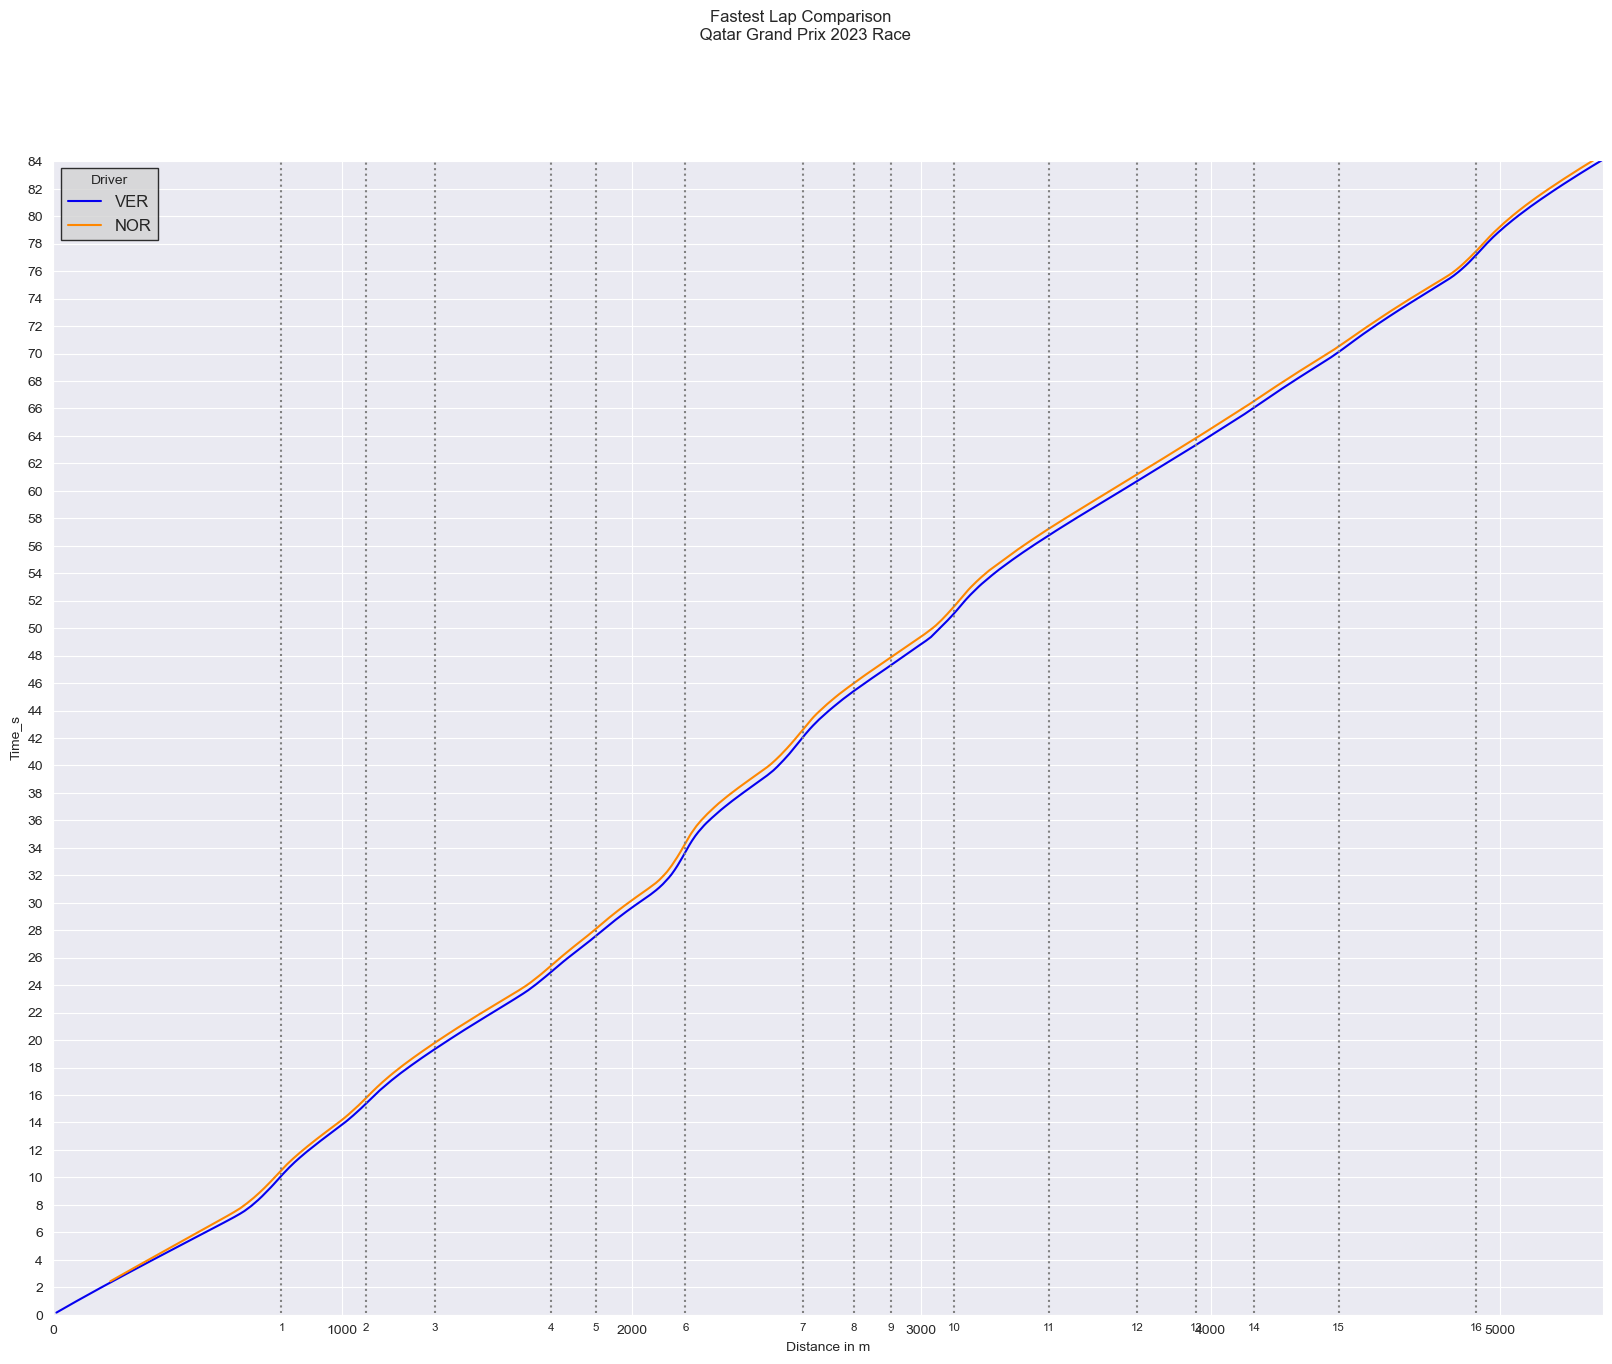

In [110]:
from matplotlib.ticker import MultipleLocator

mcl_color = fastf1.plotting.team_color('MCL')

# Converti anche i tempi
ver_tel['Time_timedelta'] = pd.to_timedelta(ver_tel['Time'])
nor_tel['Time_timedelta'] = pd.to_timedelta(nor_tel['Time'])

# Estrai i secondi dalla colonna Time_timedelta
ver_tel['Time_s'] = ver_tel['Time_timedelta'].dt.total_seconds()
nor_tel['Time_s'] = nor_tel['Time_timedelta'].dt.total_seconds()

fig, ax = plt.subplots(figsize=(20, 15))
ax.plot(ver_tel['Distance'], ver_tel['Time_s'], color='#0600ef', label='VER')
ax.plot(nor_tel['Distance'], nor_tel['Time_s'], color=mcl_color, label='NOR')

v_min = ver_tel['Time_s'].min()
v_max = ver_tel['Time_s'].max()

ax.vlines(x=circuit_info.corners['Distance'], ymin=v_min, ymax=v_max,
          linestyles='dotted', colors='grey')

for _, corner in circuit_info.corners.iterrows():
    txt = f"{corner['Number']}{corner['Letter']}"
    ax.text(corner['Distance'], v_min - 1, txt,
            va='center_baseline', ha='center', size='small')

ax.yaxis.set_major_locator(MultipleLocator(2))

# Imposta l'origine degli assi a 0
ax.set_xlim(0, ver_tel['Distance'].max())
ax.set_ylim(0, v_max)

ax.set_xlabel('Distance in m')
ax.set_ylabel('Time_s')

plt.legend(loc='upper left', bbox_to_anchor=(0, 1), title='Driver', facecolor='lightgrey', edgecolor='black', fontsize='large')
plt.suptitle(f"Fastest Lap Comparison \n "
             f"{gara.event['EventName']} {gara.event.year} Race")

plt.show()

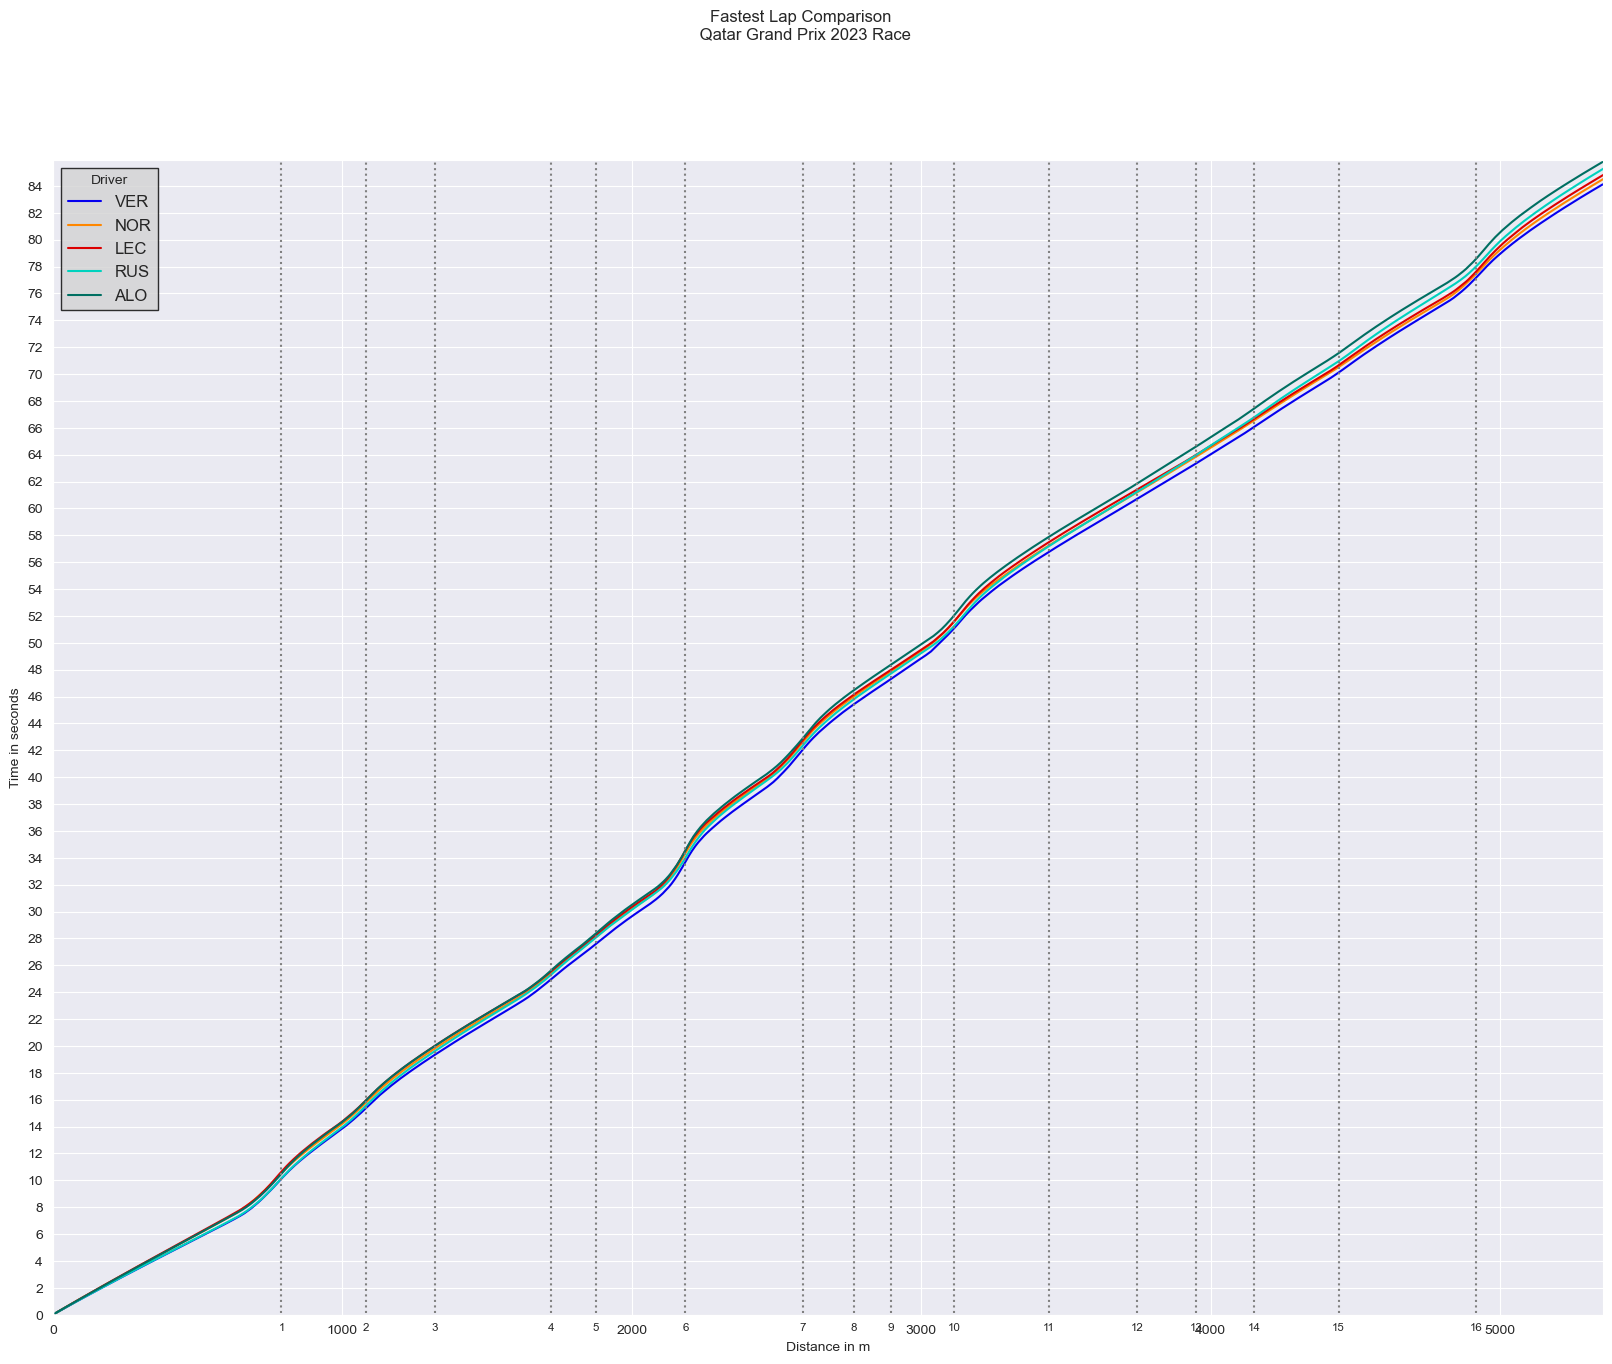

In [249]:
import fastf1
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.ticker import MultipleLocator

# Assuming `gara` and `circuit_info` are already loaded
mcl_color = fastf1.plotting.team_color('MCL')

# Convert the 'Time' columns to 'Time_timedelta'
ver_tel['Time_timedelta'] = pd.to_timedelta(ver_tel['Time'])
nor_tel['Time_timedelta'] = pd.to_timedelta(nor_tel['Time'])
lec_tel['Time_timedelta'] = pd.to_timedelta(lec_tel['Time'])
rus_tel['Time_timedelta'] = pd.to_timedelta(rus_tel['Time'])
alo_tel['Time_timedelta'] = pd.to_timedelta(alo_tel['Time'])

# Convert 'Time_timedelta' to seconds and store in 'Time_s'
ver_tel['Time_s'] = ver_tel['Time_timedelta'].dt.total_seconds()
nor_tel['Time_s'] = nor_tel['Time_timedelta'].dt.total_seconds()
lec_tel['Time_s'] = lec_tel['Time_timedelta'].dt.total_seconds()
rus_tel['Time_s'] = rus_tel['Time_timedelta'].dt.total_seconds()
alo_tel['Time_s'] = alo_tel['Time_timedelta'].dt.total_seconds()

fig, ax = plt.subplots(figsize=(20, 15))

# Plot the data for each driver
ax.plot(ver_tel['Distance'], ver_tel['Time_s'], color='#0600ef', label='VER')
ax.plot(nor_tel['Distance'], nor_tel['Time_s'], color=mcl_color, label='NOR')
ax.plot(lec_tel['Distance'], lec_tel['Time_s'], color='#dc0000', label='LEC')
ax.plot(rus_tel['Distance'], rus_tel['Time_s'], color='#00d2be', label='RUS')
ax.plot(alo_tel['Distance'], alo_tel['Time_s'], color='#006f62', label='ALO')

# Determine min and max values for vertical lines
v_min = min(ver_tel['Time_s'].min(), nor_tel['Time_s'].min(), lec_tel['Time_s'].min(), rus_tel['Time_s'].min(), alo_tel['Time_s'].min())
v_max = max(ver_tel['Time_s'].max(), nor_tel['Time_s'].max(), lec_tel['Time_s'].max(), rus_tel['Time_s'].max(), alo_tel['Time_s'].max())

# Add vertical lines at the corners
ax.vlines(x=circuit_info.corners['Distance'], ymin=v_min, ymax=v_max, linestyles='dotted', colors='grey')

# Annotate corners
for _, corner in circuit_info.corners.iterrows():
    txt = f"{corner['Number']}{corner['Letter']}"
    ax.text(corner['Distance'], v_min - 1, txt, va='center_baseline', ha='center', size='small')

# Configure y-axis ticks
ax.yaxis.set_major_locator(MultipleLocator(2))

# Set axis limits
ax.set_xlim(0, ver_tel['Distance'].max())
ax.set_ylim(0, v_max)

# Set axis labels
ax.set_xlabel('Distance in m')
ax.set_ylabel('Time in seconds')

# Add legend and title
plt.legend(loc='upper left', bbox_to_anchor=(0, 1), title='Driver', facecolor='lightgrey', edgecolor='black', fontsize='large')
plt.suptitle(f"Fastest Lap Comparison \n {gara.event['EventName']} {gara.event.year} Race")

# Show plot
plt.show()


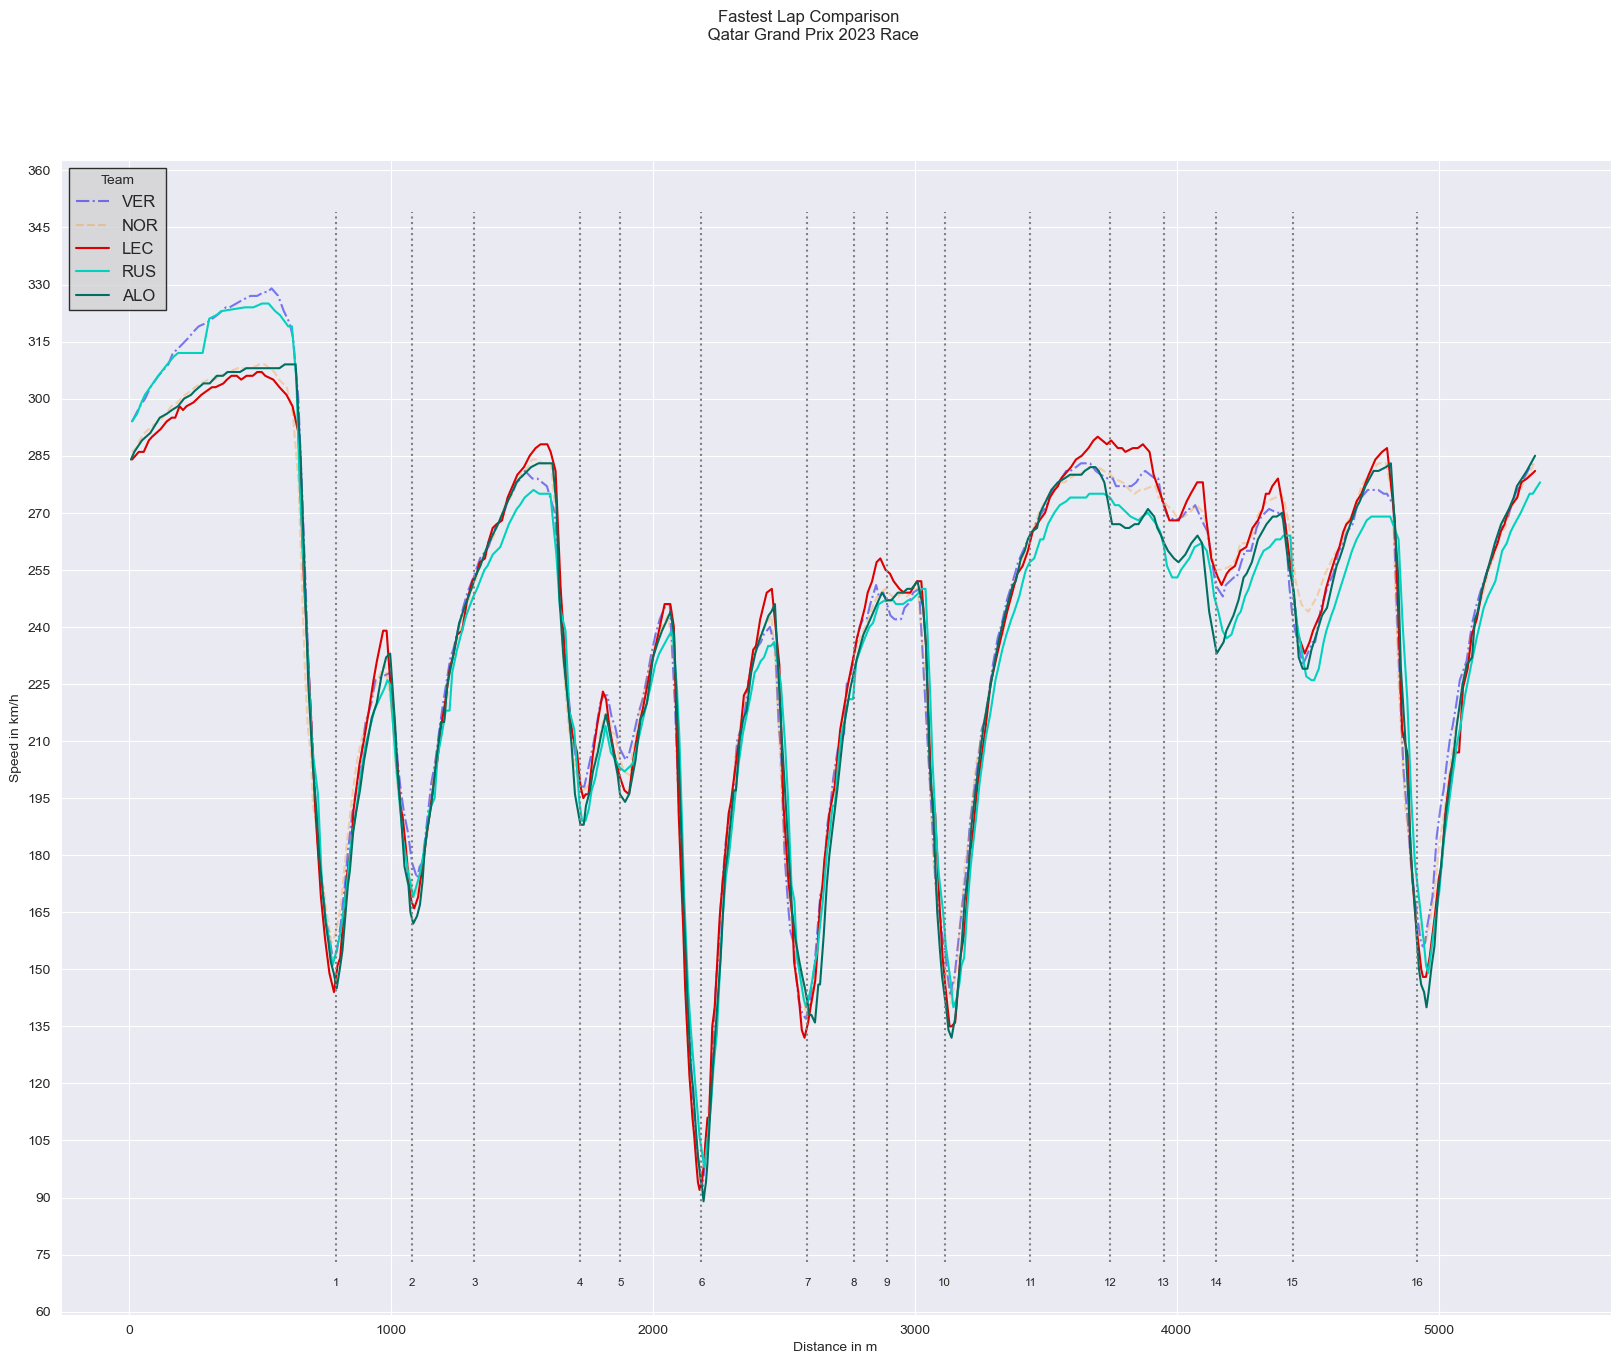

In [269]:
mcl_color = fastf1.plotting.team_color('MCL')

fig, ax = plt.subplots(figsize=(20, 15))
ax.plot(ver_tel['Distance'], ver_tel['Speed'], color='#0600ef', linestyle='-.', alpha=0.5, label='VER')
ax.plot(nor_tel['Distance'], nor_tel['Speed'], color=mcl_color, linestyle='--', alpha=0.3, label='NOR')
ax.plot(lec_tel['Distance'], lec_tel['Speed'], color='#dc0000', linestyle='-', label='LEC')
ax.plot(rus_tel['Distance'], rus_tel['Speed'], color='#00d2be', linestyle='-', label='RUS')
ax.plot(alo_tel['Distance'], alo_tel['Speed'], color='#006f62', linestyle='-', label='ALO')

v_min = ver_tel['Speed'].min()
v_max = ver_tel['Speed'].max()

ax.vlines(x=circuit_info.corners['Distance'], ymin=v_min-20, ymax=v_max+20,
          linestyles='dotted', colors='grey')

for _, corner in circuit_info.corners.iterrows():
    txt = f"{corner['Number']}{corner['Letter']}"
    ax.text(corner['Distance'], v_min-25, txt,
            va='center_baseline', ha='center', size='small')

ax.yaxis.set_major_locator(MultipleLocator(15))
    
ax.set_xlabel('Distance in m')
ax.set_ylabel('Speed in km/h')

plt.legend(loc='upper left', bbox_to_anchor=(0, 1), title='Team', facecolor='lightgrey', edgecolor='black', fontsize='large')
plt.suptitle(f"Fastest Lap Comparison \n "
             f"{gara.event['EventName']} {gara.event.year} Race")

plt.show()

core           INFO 	Loading data for Qatar Grand Prix - Race [v3.3.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 55
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 55)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '81', '4', '63', '16', '14

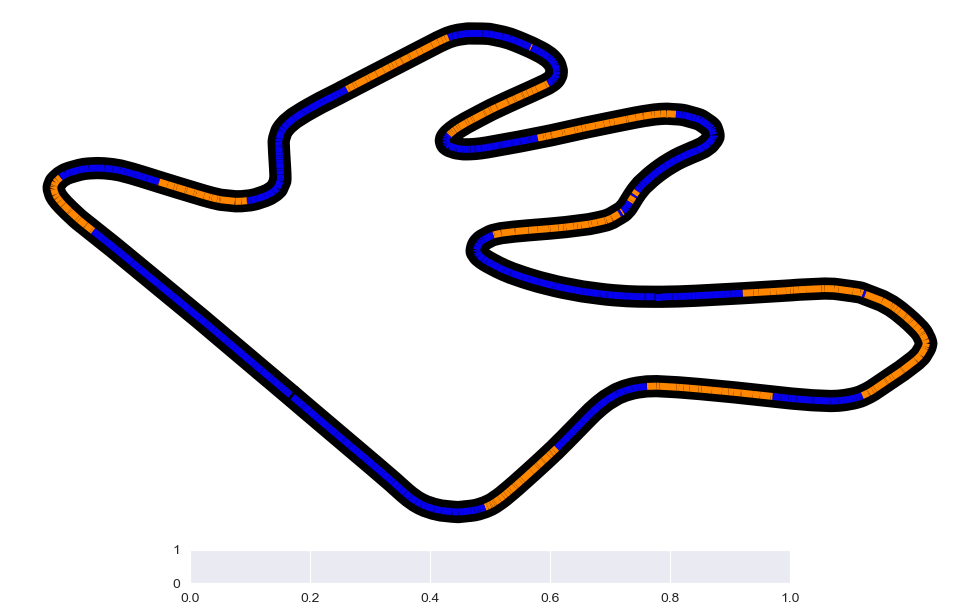

In [170]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import fastf1 as ff1
import fastf1.plotting

# Carica i dati della sessione
year = 2023
wknd = 'Qatar Grand Prix'
ses = 'R'
driver_norris = 'NOR'
driver_verstappen = 'VER'

session = ff1.get_session(year, wknd, ses)
gara = session.event
session.load()

driver_norris = 'NOR'
driver_verstappen = 'VER'

# Get fastest laps
lap_norris = session.laps.pick_driver(driver_norris).pick_fastest()
lap_verstappen = session.laps.pick_driver(driver_verstappen).pick_fastest()

# Get telemetry data
x_norris = lap_norris.telemetry['X']
y_norris = lap_norris.telemetry['Y']
speed_norris = lap_norris.telemetry['Speed']

x_verstappen = lap_verstappen.telemetry['X']
y_verstappen = lap_verstappen.telemetry['Y']
speed_verstappen = lap_verstappen.telemetry['Speed']

# Interpolate Verstappen's telemetry to match Norris's telemetry points
speed_verstappen_interp = np.interp(np.linspace(0, len(speed_norris) - 1, len(speed_norris)), 
                                    np.linspace(0, len(speed_verstappen) - 1, len(speed_verstappen)), 
                                    speed_verstappen)

# Calculate speed difference
speed_diff = speed_verstappen_interp - speed_norris

# Create the points and segments
points = np.array([x_norris, y_norris]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create the plot
fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(12, 6.75))
# fig.suptitle(f'{weekend.name} {year} - Speed Difference (Verstappen vs Norris)', size=24, y=0.97)

# Adjust margins and turn off axis
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.12)
ax.axis('off')

# Background track line
ax.plot(x_norris, y_norris, color='black', linestyle='-', linewidth=16, zorder=0)

# Create a discrete colormap for blue and orange
cmap = mpl.colors.ListedColormap(['#ff8700', '#0600ef'])
boundaries = [-np.inf, 0, np.inf]
norm = mpl.colors.BoundaryNorm(boundaries, cmap.N)

# Create LineCollection
lc = LineCollection(segments, cmap=cmap, norm=norm, linestyle='-', linewidth=5)
lc.set_array(speed_diff)

# Add LineCollection to plot
line = ax.add_collection(lc)

# Create colorbar as a legend
cbaxes = fig.add_axes([0.25, 0.05, 0.5, 0.05])
# normlegend = mpl.colors.BoundaryNorm(boundaries, cmap.N)
# legend = mpl.colorbar.ColorbarBase(cbaxes, norm=normlegend, cmap=cmap,
#                                    orientation="horizontal")

# # Set custom labels for the legend
# legend.set_ticks([0, 1])
# legend.set_ticklabels(['Verstappen Faster', 'Norris Faster'])

# Show the plot
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import fastf1 as ff1
import fastf1.plotting

# Carica i dati della sessione
year = 2023
wknd = 'Qatar Grand Prix'
ses = 'R'
driver_norris = 'NOR'
driver_verstappen = 'VER'

session = ff1.get_session(year, wknd, ses)
gara = session.event
session.load()

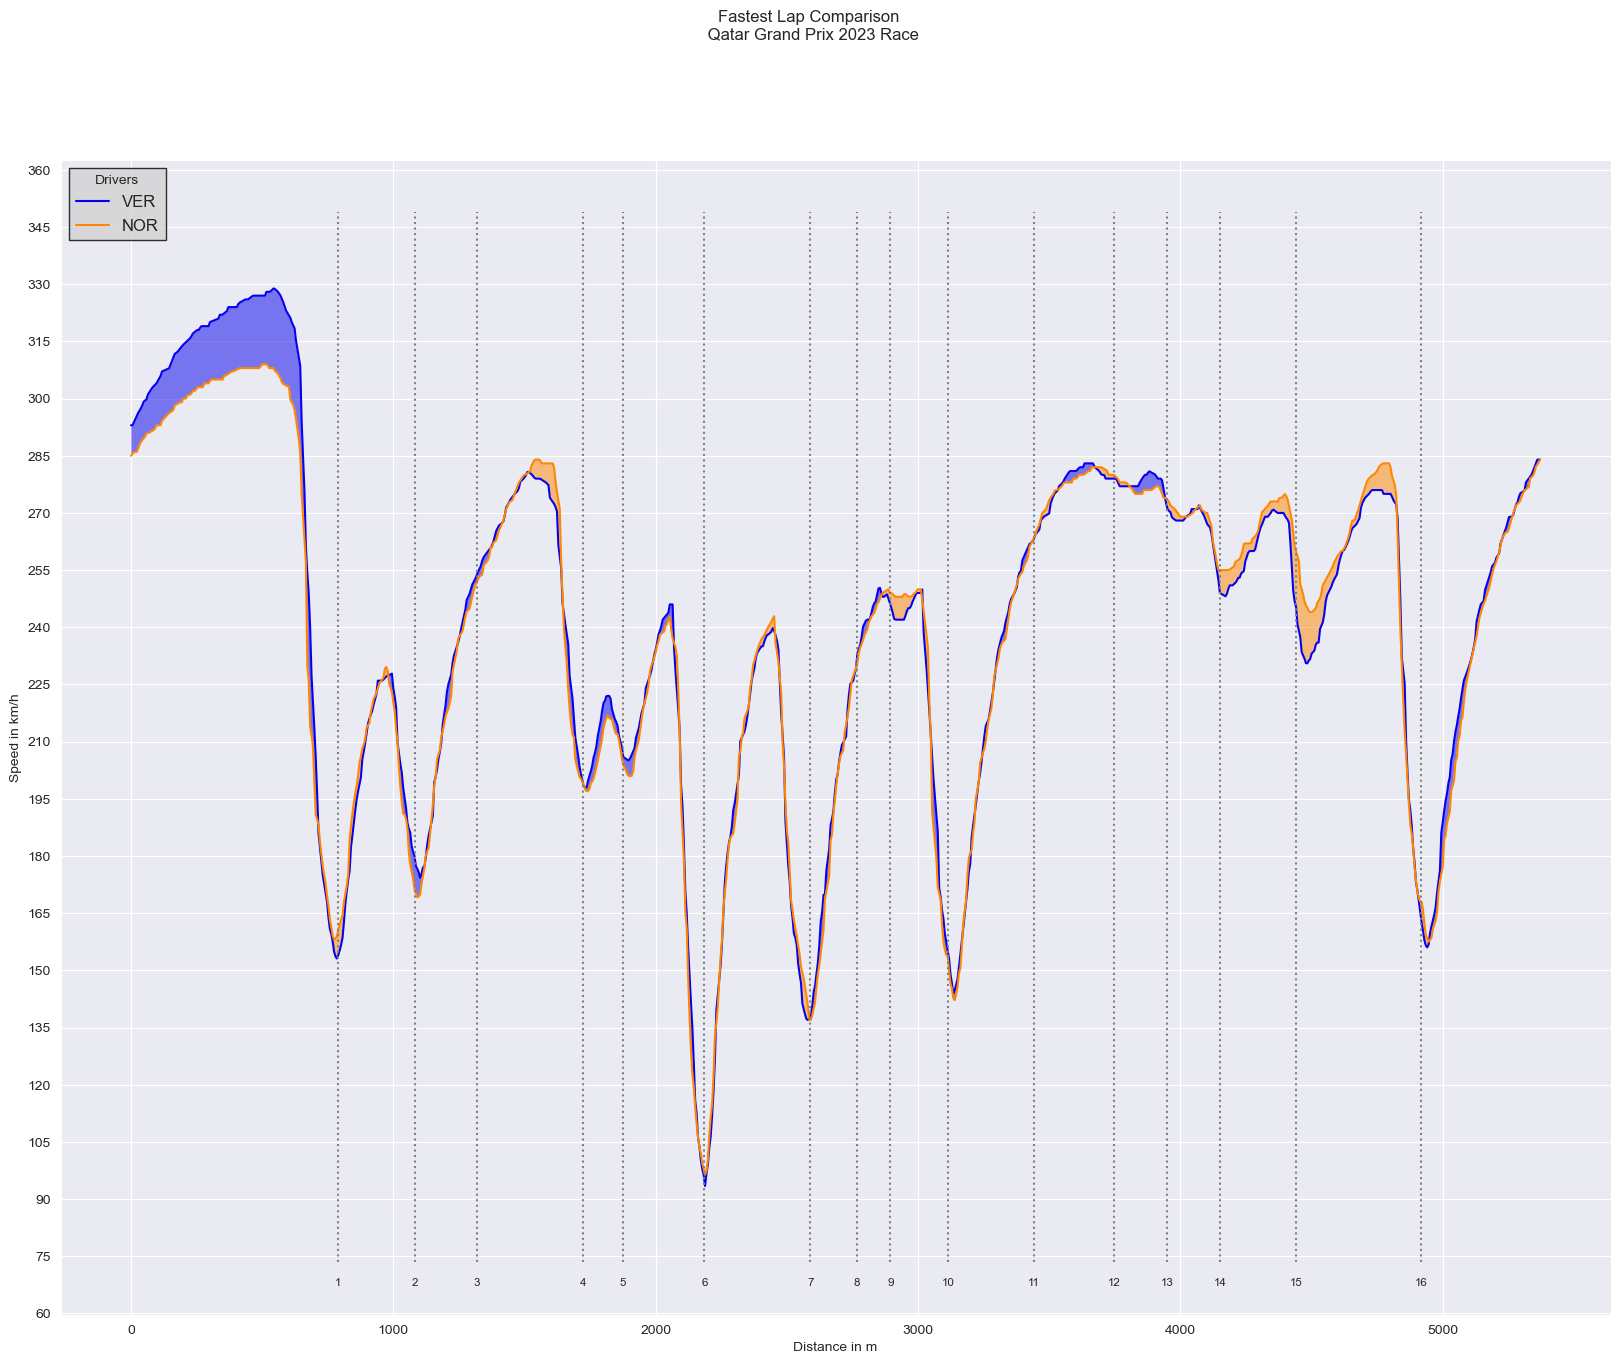

In [176]:
# Ottieni i giri più veloci
lap_norris = session.laps.pick_driver(driver_norris).pick_fastest()
lap_verstappen = session.laps.pick_driver(driver_verstappen).pick_fastest()

# Ottieni i dati di telemetria
nor_tel = lap_norris.get_telemetry()
ver_tel = lap_verstappen.get_telemetry()

# Interpola i dati di velocità di Norris e Verstappen per corrispondere alla stessa scala di distanze
common_distance = np.linspace(0, min(nor_tel['Distance'].max(), ver_tel['Distance'].max()), 1000)
ver_speed_interp = np.interp(common_distance, ver_tel['Distance'], ver_tel['Speed'])
nor_speed_interp = np.interp(common_distance, nor_tel['Distance'], nor_tel['Speed'])

# Colori
mcl_color = fastf1.plotting.team_color('MCL')
red_bull_color = '#0600ef'

# Crea il grafico
fig, ax = plt.subplots(figsize=(20, 15))
ax.plot(common_distance, ver_speed_interp, color=red_bull_color, label='VER')
ax.plot(common_distance, nor_speed_interp, color=mcl_color, label='NOR')

# Aggiungi area colorata tra le due linee
ax.fill_between(common_distance, ver_speed_interp, nor_speed_interp, 
                where=(ver_speed_interp >= nor_speed_interp), 
                facecolor=red_bull_color, alpha=0.5, interpolate=True, label='VER Faster')
ax.fill_between(common_distance, ver_speed_interp, nor_speed_interp, 
                where=(ver_speed_interp < nor_speed_interp), 
                facecolor= mcl_color, alpha=0.5, interpolate=True, label='NOR Faster')

# Aggiungi linee verticali per le curve
v_min = min(ver_speed_interp.min(), nor_speed_interp.min())
v_max = max(ver_speed_interp.max(), nor_speed_interp.max())

# Supponendo che circuit_info.corners contenga le informazioni sulle curve
circuit_info = session.get_circuit_info()  # Assicurati di avere circuit_info
ax.vlines(x=circuit_info.corners['Distance'], ymin=v_min-20, ymax=v_max+20,
          linestyles='dotted', colors='grey')

for _, corner in circuit_info.corners.iterrows():
    txt = f"{corner['Number']}{corner['Letter']}"
    ax.text(corner['Distance'], v_min-25, txt,
            va='center_baseline', ha='center', size='small')

# Configura gli assi
ax.yaxis.set_major_locator(MultipleLocator(15))
ax.set_xlabel('Distance in m')
ax.set_ylabel('Speed in km/h')

# Aggiungi legenda con solo i piloti
plt.legend(['VER', 'NOR'], loc='upper left', bbox_to_anchor=(0, 1), title='Drivers', facecolor='lightgrey', edgecolor='black', fontsize='large')
plt.suptitle(f"Fastest Lap Comparison \n {gara['EventName']} {gara.year} Race")

# Mostra il grafico
plt.show()


## CAPITOLO 5: DEGRADO MESCOLE

In [21]:
df_weather = pd.read_csv('df_weather.csv', sep = ';')
df_tempi = pd.read_csv('df_tempi.csv', sep = ';')

In [126]:
df_weather.columns

Index(['Unnamed: 0', 'index', 'Team', 'Year', 'GP', 'Compound',
       'LapTime_seconds', 'AirTemp', 'Humidity', 'Pressure', 'TrackTemp',
       'WindSpeed'],
      dtype='object')

In [171]:
columns_of_interest = ['LapTime_seconds', 'AirTemp', 'Humidity', 'Pressure', 'TrackTemp', 'WindSpeed']
correlation_matrix = df_weather.groupby('Compound')[columns_of_interest].corr()

In [173]:
correlation_matrix

LapTime_seconds   AirTemp  Humidity  Pressure  \
Compound                                                                      
HARD         LapTime_seconds         1.000000  0.123490  0.131533  0.256458   
             AirTemp                 0.123490  1.000000 -0.249776  0.060441   
             Humidity                0.131533 -0.249776  1.000000  0.280085   
             Pressure                0.256458  0.060441  0.280085  1.000000   
             TrackTemp              -0.134454  0.617380 -0.488662 -0.288641   
             WindSpeed               0.189114 -0.032645 -0.017918  0.142850   
INTERMEDIATE LapTime_seconds         1.000000  0.037991 -0.197532  0.954181   
             AirTemp                 0.037991  1.000000  0.971806  0.320181   
             Humidity               -0.197532  0.971806  1.000000  0.087786   
             Pressure                0.954181  0.320181  0.087786  1.000000   
             TrackTemp               0.117442  0.996793  0.949822  0.394965   
             WindSpeed               0.985909  0.173253 -0.063846  0.988502   
MEDIUM       LapTime_seconds         1.000000  0.109177  0.125426  0.241070   
             AirTemp                 0.109177  1.000000 -0.344305  0.065495   
             Humidity                0.125426 -0.344305  1.000000  0.282482   
             Pressure                0.241070  0.065495  0.282482  1.000000   
             TrackTemp              -0.121598  0.658830 -0.525308 -0.280764   
             WindSpeed               0.135544  0.021063 -0.067346  0.147186   
SOFT         LapTime_seconds         1.000000 -0.002273  0.015615  0.218344   
             AirTemp                -0.002273  1.000000 -0.463150  0.017415   
             Humidity                0.015615 -0.463150  1.000000  0.207270   
             Pressure                0.218344  0.017415  0.207270  1.000000   
             TrackTemp              -0.212449  0.655347 -0.482640 -0.313134   
             WindSpeed               0.055418 -0.049045 -0.021380  0.077195   
WET          LapTime_seconds         1.000000       NaN       NaN       NaN   
             AirTemp                      NaN       NaN       NaN       NaN   
             Humidity                     NaN       NaN       NaN       NaN   
             Pressure                     NaN       NaN       NaN       NaN   
             TrackTemp                    NaN       NaN       NaN       NaN   
             WindSpeed                    NaN       NaN       NaN       NaN   

                              TrackTemp  WindSpeed  
Compound                                            
HARD         LapTime_seconds  -0.134454   0.189114  
             AirTemp           0.617380  -0.032645  
             Humidity         -0.488662  -0.017918  
             Pressure         -0.288641   0.142850  
             TrackTemp         1.000000  -0.121655  
             WindSpeed        -0.121655   1.000000  
INTERMEDIATE LapTime_seconds   0.117442   0.985909  
             AirTemp           0.996793   0.173253  
             Humidity          0.949822  -0.063846  
             Pressure          0.394965   0.988502  
             TrackTemp         1.000000   0.251511  
             WindSpeed         0.251511   1.000000  
MEDIUM       LapTime_seconds  -0.121598   0.135544  
             AirTemp           0.658830   0.021063  
             Humidity         -0.525308  -0.067346  
             Pressure         -0.280764   0.147186  
             TrackTemp         1.000000  -0.082318  
             WindSpeed        -0.082318   1.000000  
SOFT         LapTime_seconds  -0.212449   0.055418  
             AirTemp           0.655347  -0.049045  
             Humidity         -0.482640  -0.021380  
             Pressure         -0.313134   0.077195  
             TrackTemp         1.000000  -0.139375  
             WindSpeed        -0.139375   1.000000  
WET          LapTime_seconds        NaN        NaN  
             AirTemp                NaN        NaN  
             Humi


## PRESTAZIONE TEAM DIVISA PER MESCOLA

In [138]:
df_tempi = pd.read_csv('df_tempi.csv', sep = ';')

In [139]:
# Conversione in secondi:
df_tempi['LapTime_timedelta'] = pd.to_timedelta(df_tempi['LapTime'])

# Estrai i secondi dalla colonna LapTime_timedelta
df_tempi['LapTime_s'] = df_tempi['LapTime_timedelta'].dt.total_seconds()

In [140]:
# Con la group by PER IL MIN
best_lap = df_tempi.groupby(['Year', 'GP', 'Stint', 'Compound'])['LapTime_s'].min()

best_lap = best_lap.rename('BestLap')

df_tempi = df_tempi.merge(best_lap, on = ['Year', 'GP', 'Stint', 'Compound'])

df_tempi['Ratio_to_min'] = (df_tempi['LapTime_s'] / df_tempi['BestLap'] - 1) * 100

# Con la group by per la MEAN
mean_lap = df_tempi.groupby(['Year', 'GP', 'Stint', 'Compound'])['LapTime_s'].mean()

mean_lap = mean_lap.rename('MeanLap')

df_tempi = df_tempi.merge(mean_lap, on = ['Year', 'GP', 'Stint', 'Compound'])

df_tempi['Ratio_to_mean'] = (df_tempi['LapTime_s'] / df_tempi['MeanLap'] - 1) * 100

In [341]:
# Aggiusto i team
team_mapping = {
    'Alfa Romeo Racing': 'Alfa Romeo',
    'Toro Rosso': 'AlphaTauri',
    'Racing Point': 'Aston Martin',
    'Renault' : 'Alpine'
}

# Effettua la sostituzione dei nomi dei team
df_tempi['Team'] = df_tempi['Team'].replace(team_mapping)

team_palette = {
    'Alfa Romeo': '#900000',
    'AlphaTauri': '#2b4562',
    'Alpine': '#0090ff',
    'Aston Martin': '#006f62',
    'Ferrari': '#dc0000',
    'Haas F1 Team': 'black',
    'McLaren': '#ff8700',
    'Mercedes': '#00d2be',
    'Red Bull Racing': '#0600ef',
    'Williams': '#005aff',
}

###
### Hard

In [304]:
df_tempi_hd = df_tempi.loc[df_tempi['Compound'] == 'HARD']

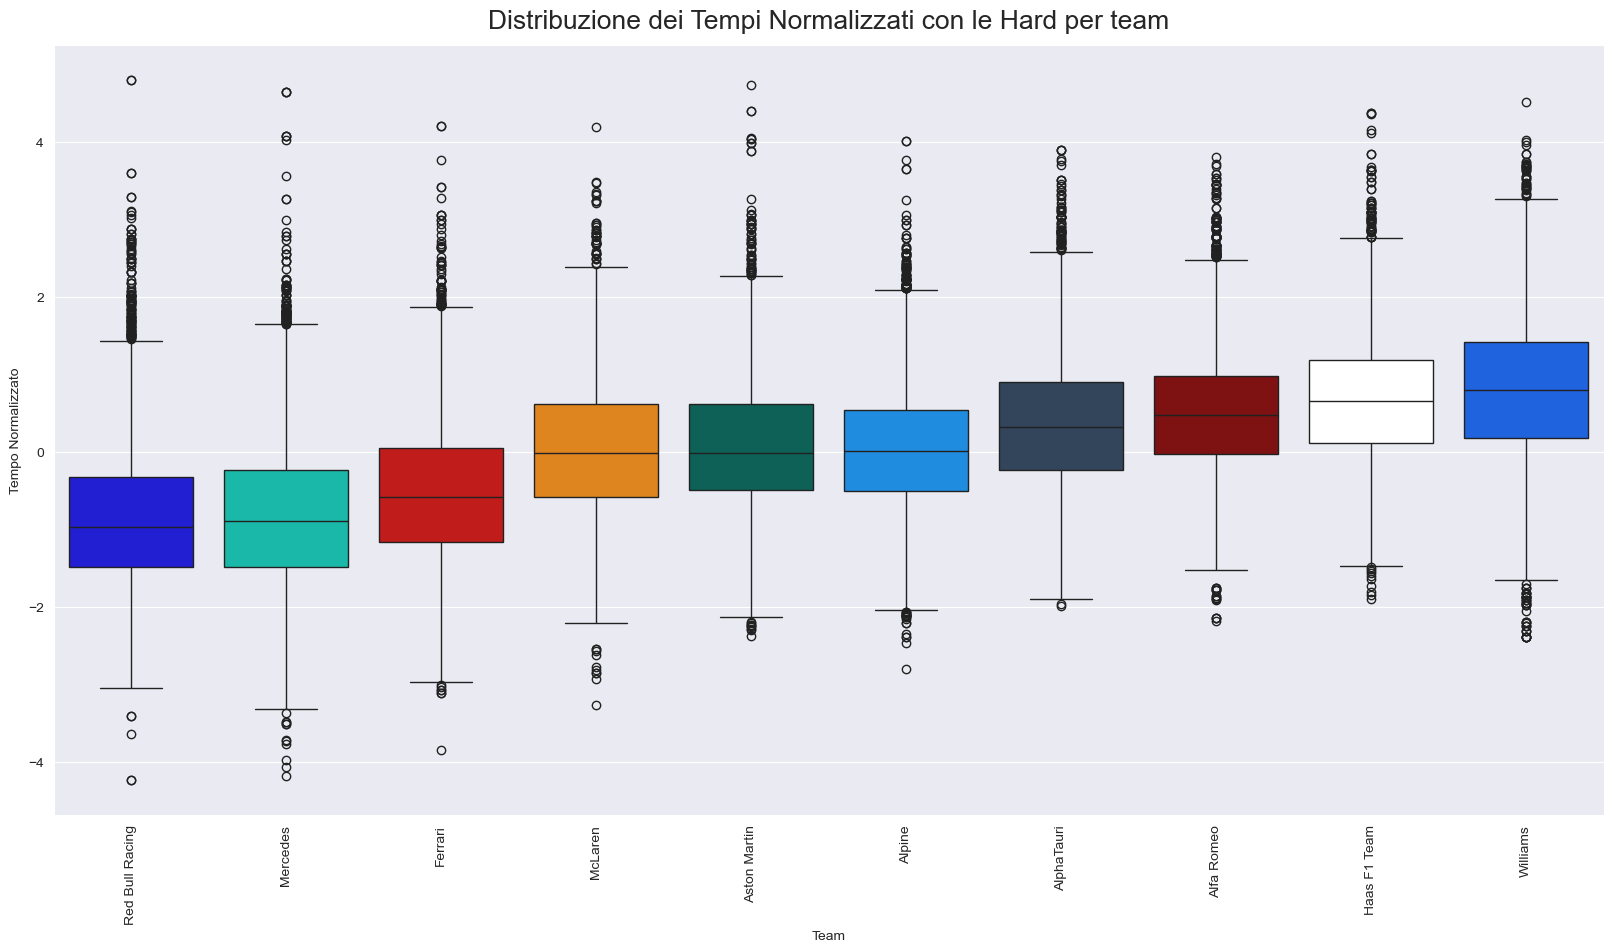

In [330]:
# Visualizza la distribuzione dei tempi standardizzati per pilota
plt.figure(figsize=(20, 10))

# order
order = df_tempi_hd.groupby('Team')['Ratio_to_mean'].median().sort_values().index

sns.boxplot(
    data=df_tempi.loc[df_tempi['Compound'] == 'HARD'], 
    x='Team', y='Ratio_to_mean', hue = 'Team', 
    palette = team_palette, 
    order = order
)

plt.title('Distribuzione dei Tempi Normalizzati con le Hard per team')
plt.xlabel('Team')
plt.ylabel('Tempo Normalizzato')
plt.xticks(rotation=90)
plt.show()

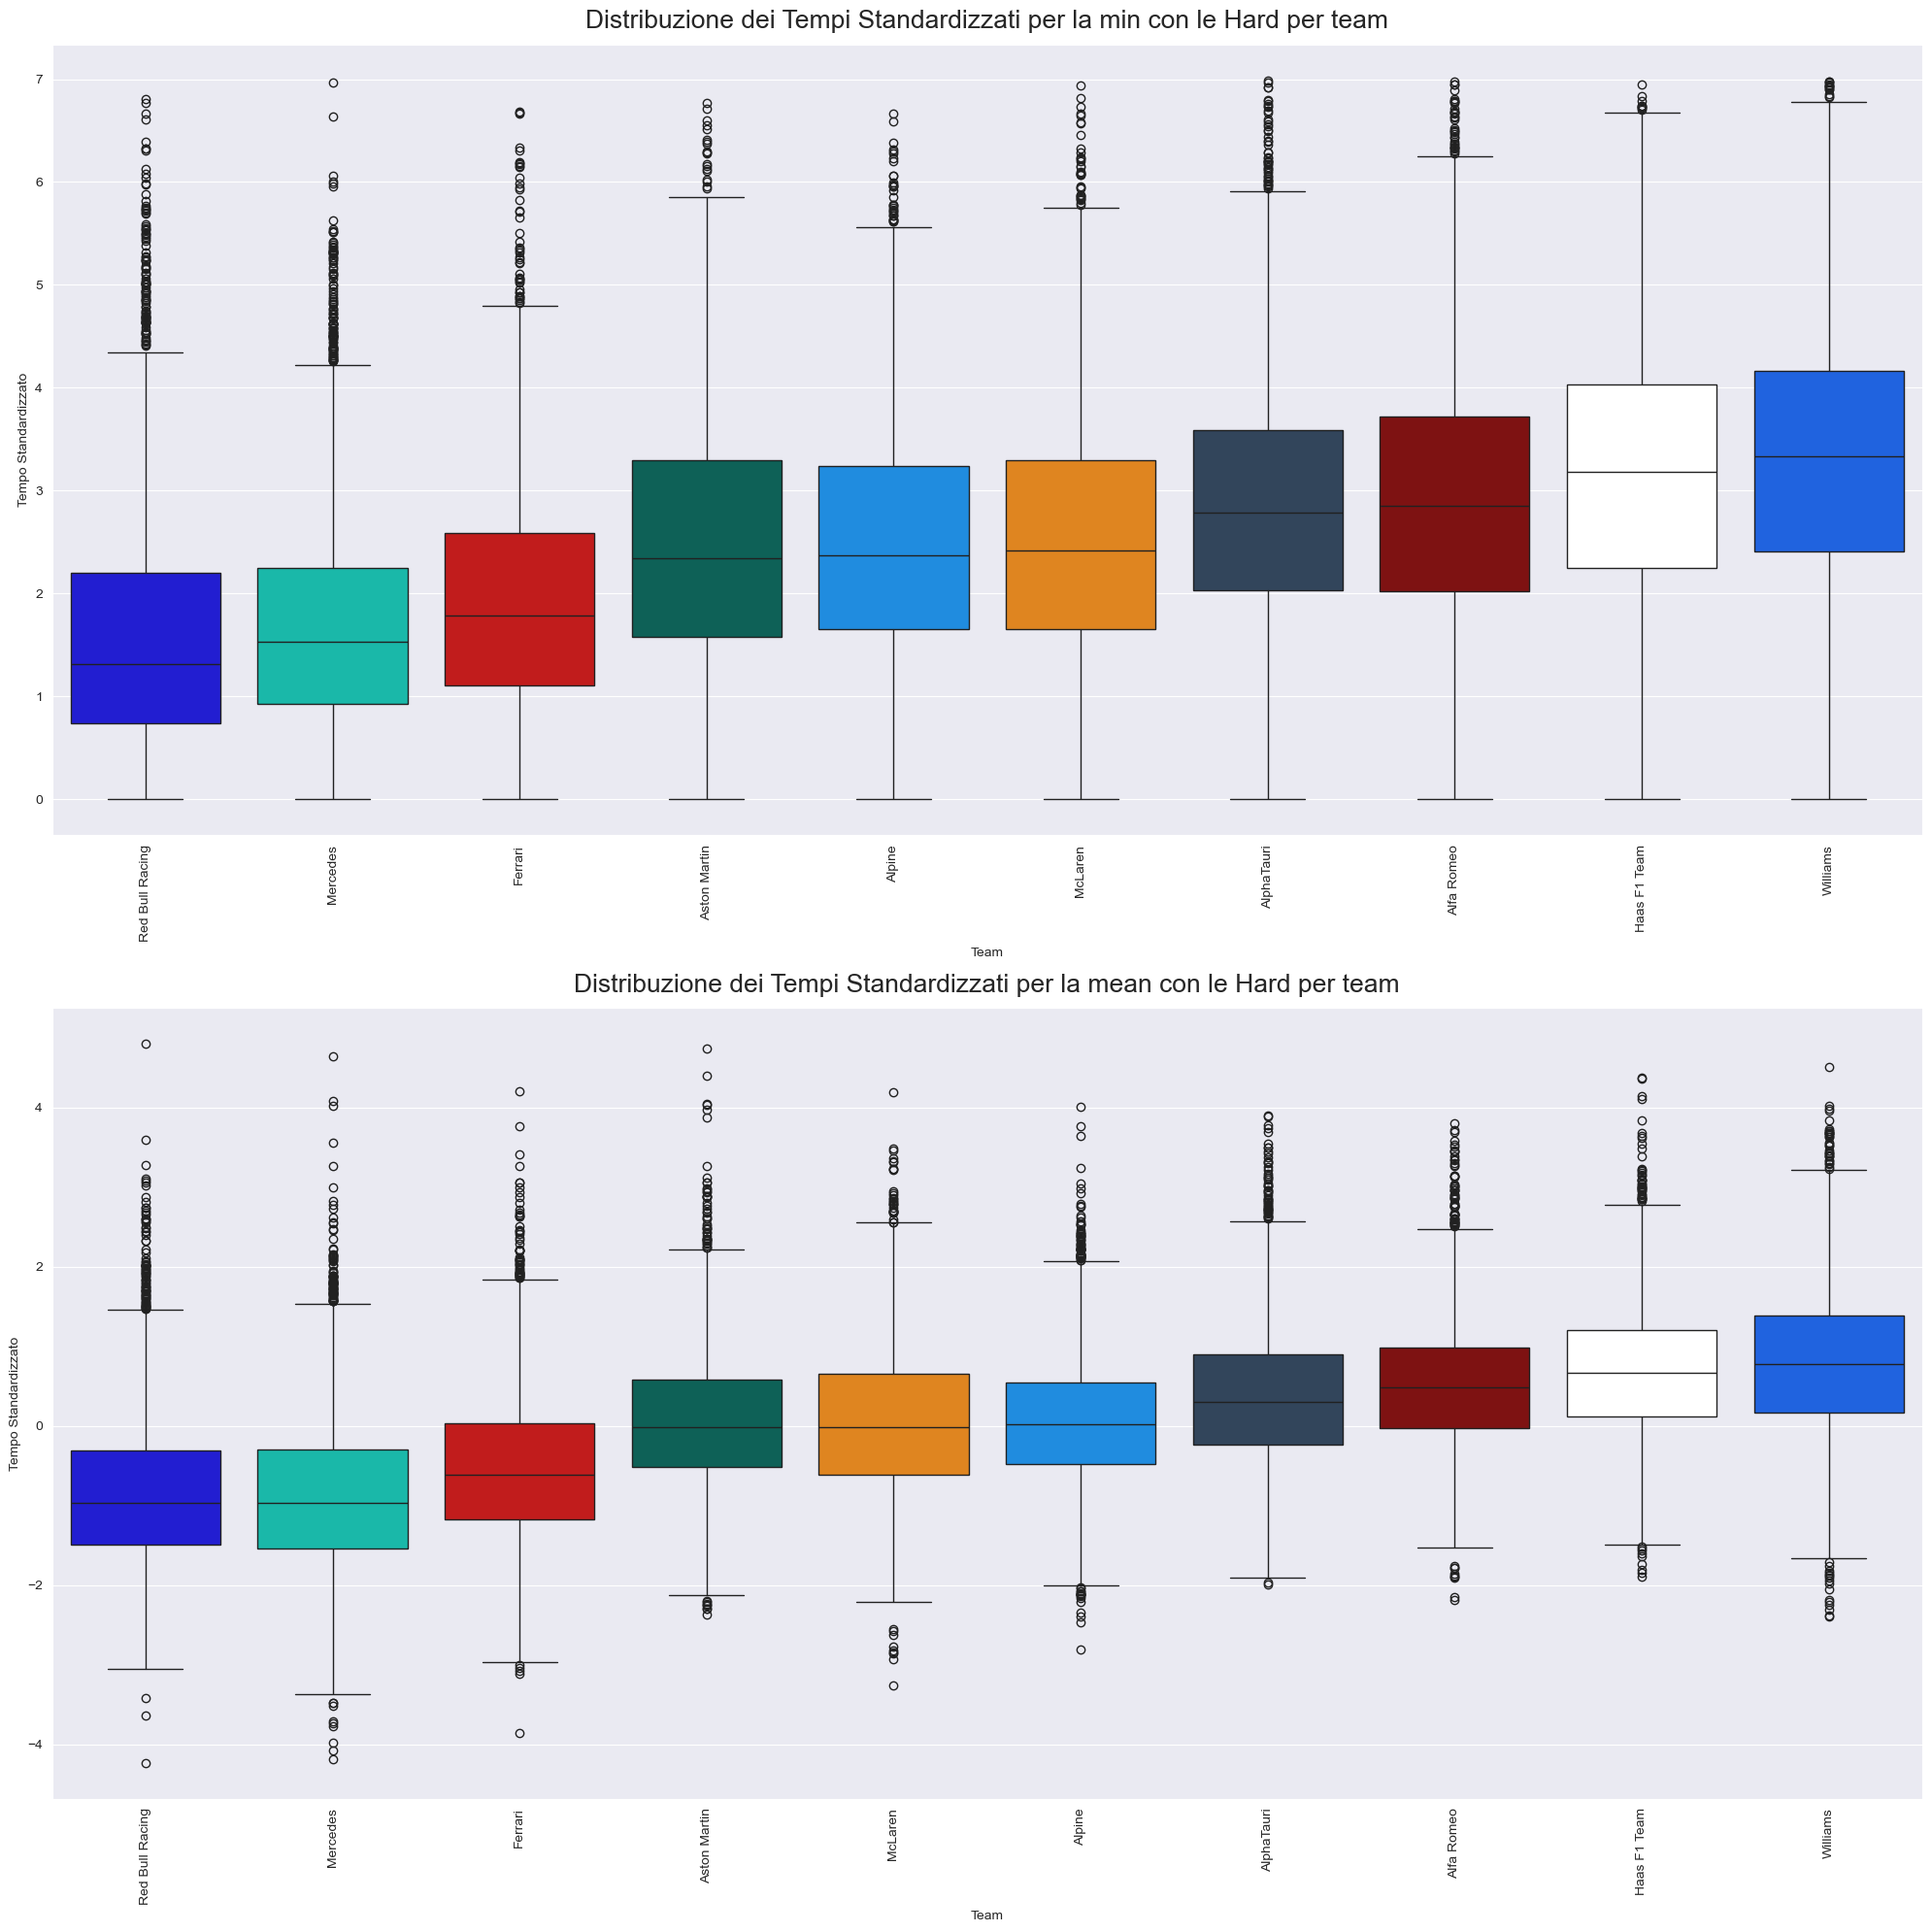

In [152]:
fig, axes = plt.subplots(2, 1, figsize=(20, 20))

order_min = df_tempi.loc[df_tempi['Compound'] == 'HARD'].groupby('Team')['Ratio_to_min'].median().sort_values().index

# Primo subplot per i tempi con le HARD
sns.boxplot(
    data=df_tempi.loc[df_tempi['Compound'] == 'HARD'], 
    x='Team', y='Ratio_to_min', hue='Team', 
    palette=team_palette, 
    order=order_min, 
    ax=axes[0]
)

axes[0].set_title('Distribuzione dei Tempi Standardizzati per la min con le Hard per team')
axes[0].set_xlabel('Team')
axes[0].set_ylabel('Tempo Standardizzato')
axes[0].tick_params(axis='x', rotation=90)
#axes[0].legend_.remove()  # Rimuovi la leggenda duplicata

order_mean = df_tempi.loc[df_tempi['Compound'] == 'HARD'].groupby('Team')['Ratio_to_mean'].median().sort_values().index

# Secondo subplot per i tempi con le SOFT (o un altro compound)
sns.boxplot(
    data=df_tempi.loc[df_tempi['Compound'] == 'HARD'], 
    x='Team', y='Ratio_to_mean', hue='Team', 
    palette=team_palette, 
    order=order_mean, 
    ax=axes[1]
)

axes[1].set_title('Distribuzione dei Tempi Standardizzati per la mean con le Hard per team')
axes[1].set_xlabel('Team')
axes[1].set_ylabel('Tempo Standardizzato')
axes[1].tick_params(axis='x', rotation=90)
#axes[1].legend_.remove()  # Rimuovi la leggenda duplicata

# Mostra il plot
plt.tight_layout()
plt.show()

###
### Medium

In [241]:
df_tempi_md = df_tempi.loc[df_tempi['Compound'] == 'MEDIUM']

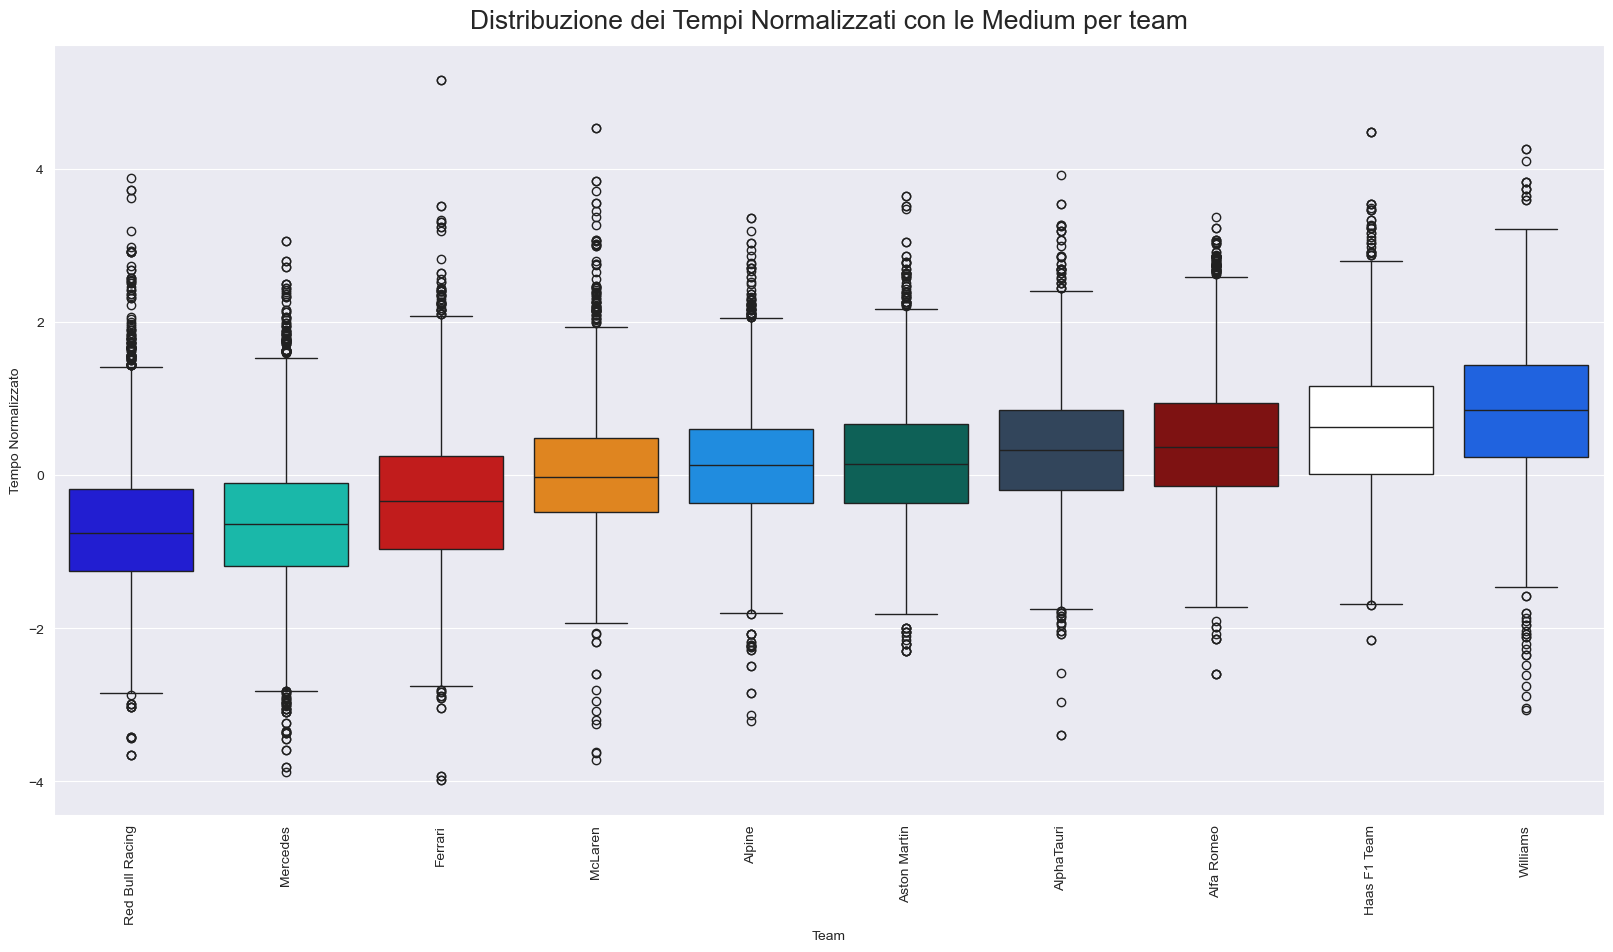

In [332]:
# Visualizza la distribuzione dei tempi standardizzati per pilota
plt.figure(figsize=(20, 10))

# order
order = df_tempi_md.groupby('Team')['Ratio_to_mean'].median().sort_values().index

sns.boxplot(
    data=df_tempi.loc[df_tempi['Compound'] == 'MEDIUM'], 
    x='Team', y='Ratio_to_mean', hue = 'Team', 
    palette = team_palette, 
    order = order
)

plt.title('Distribuzione dei Tempi Normalizzati con le Medium per team')
plt.xlabel('Team')
plt.ylabel('Tempo Normalizzato')
plt.xticks(rotation=90)
plt.show()

###
### Soft

In [245]:
df_tempi_sf = df_tempi.loc[df_tempi['Compound'] == 'SOFT']

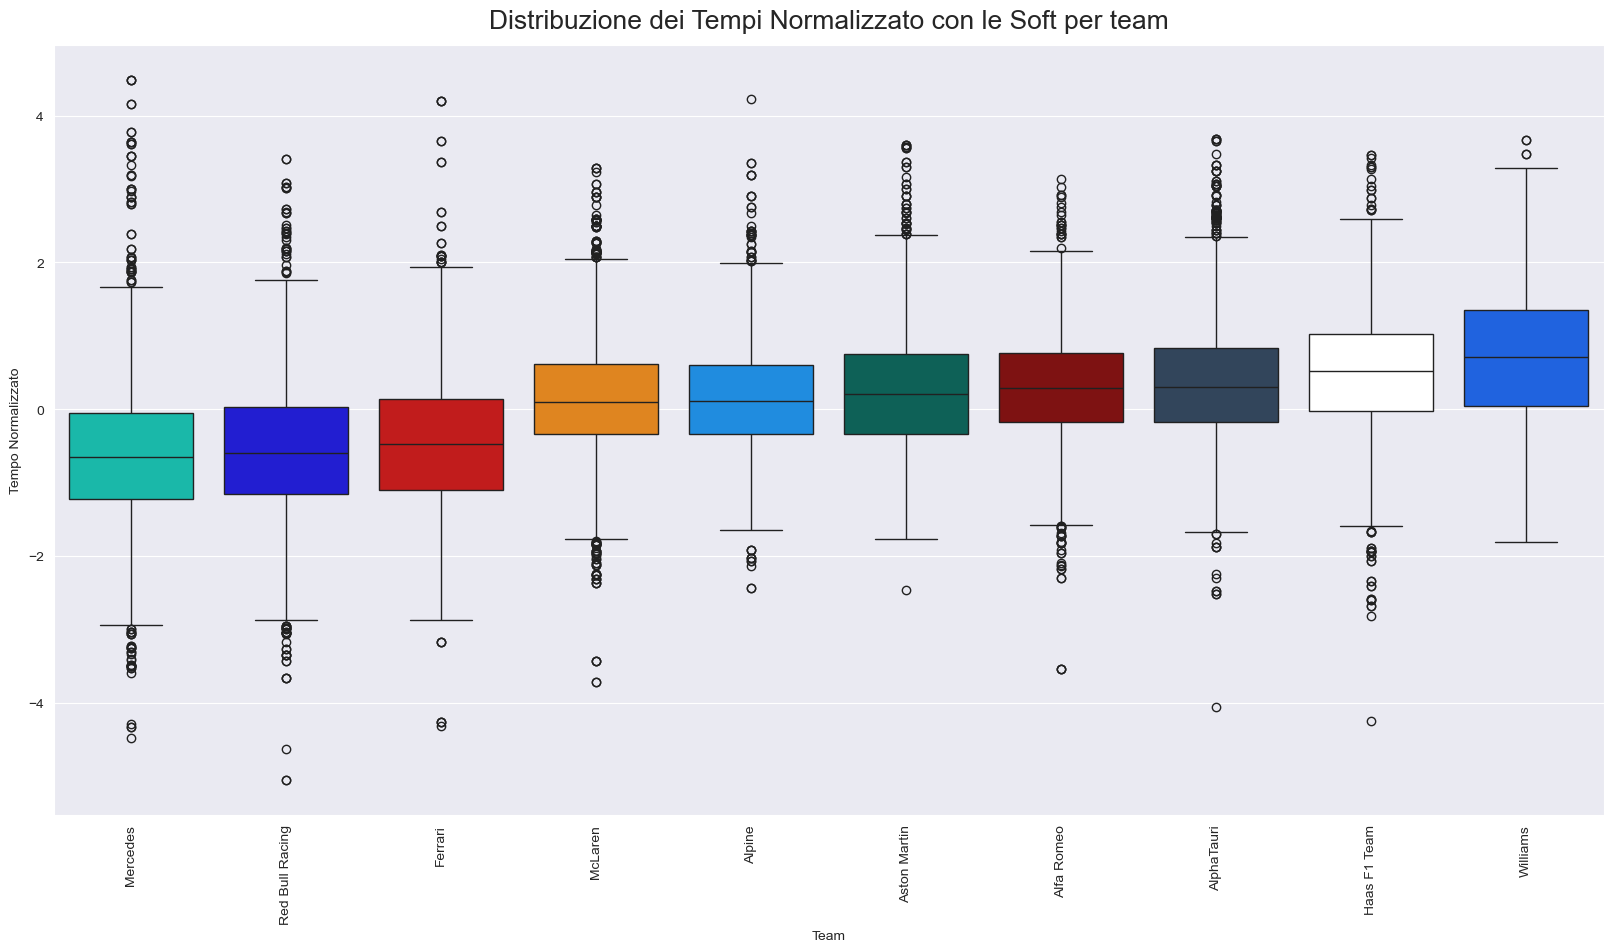

In [333]:
# Visualizza la distribuzione dei tempi standardizzati per pilota
plt.figure(figsize=(20, 10))

# order
order = df_tempi_sf.groupby('Team')['Ratio_to_mean'].median().sort_values().index

sns.boxplot(
    data=df_tempi.loc[df_tempi['Compound'] == 'SOFT'], 
    x='Team', y='Ratio_to_mean', hue = 'Team', 
    palette = team_palette, 
    order = order
)

plt.title('Distribuzione dei Tempi Normalizzato con le Soft per team')
plt.xlabel('Team')
plt.ylabel('Tempo Normalizzato')
plt.xticks(rotation=90)
plt.show()

###
### Crescita nel corso degli anni

#### Hard

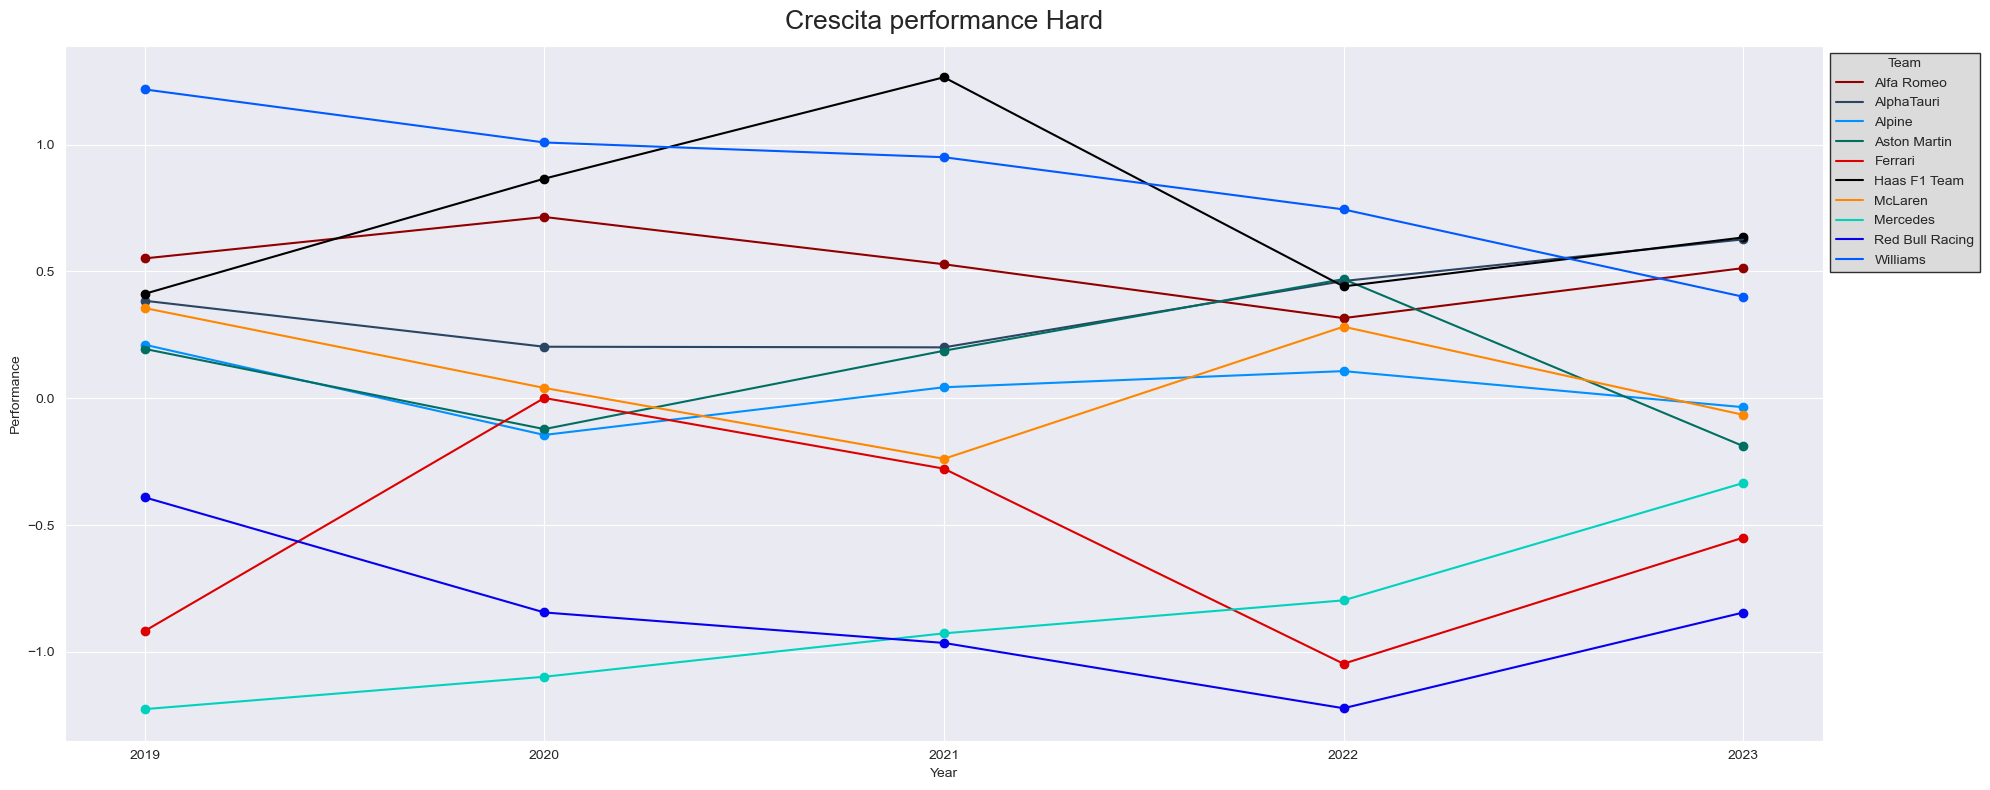

In [343]:
# Calcolo delle mediane per ogni team e anno
hd_growth = df_tempi_hd.groupby(['Team', 'Year'], as_index=False)['Ratio_to_mean'].mean()

# Grafico con punti
fig, ax = plt.subplots(figsize=(20, 8))

for team in pd.unique(hd_growth['Team']):
    team_laps = hd_growth[hd_growth['Team'] == team]
    abb = team_laps['Team'].iloc[0]
    color = team_palette[team]

    ax.plot(team_laps['Year'], team_laps['Ratio_to_mean'], label=abb, color=color)
    
    # Aggiungi i punti per ogni anno
    ax.scatter(team_laps['Year'], team_laps['Ratio_to_mean'], color=color)

ax.set_xlabel('Year')
ax.set_ylabel('Performance')
ax.set_title('Crescita performance Hard')

# Aggiunta della legenda
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Team', facecolor='lightgrey', edgecolor='black')

# Imposta l'asse x con una scala di 1
plt.xticks(np.arange(min(hd_growth['Year']), max(hd_growth['Year']) + 1, 1))

plt.tight_layout()
plt.show()

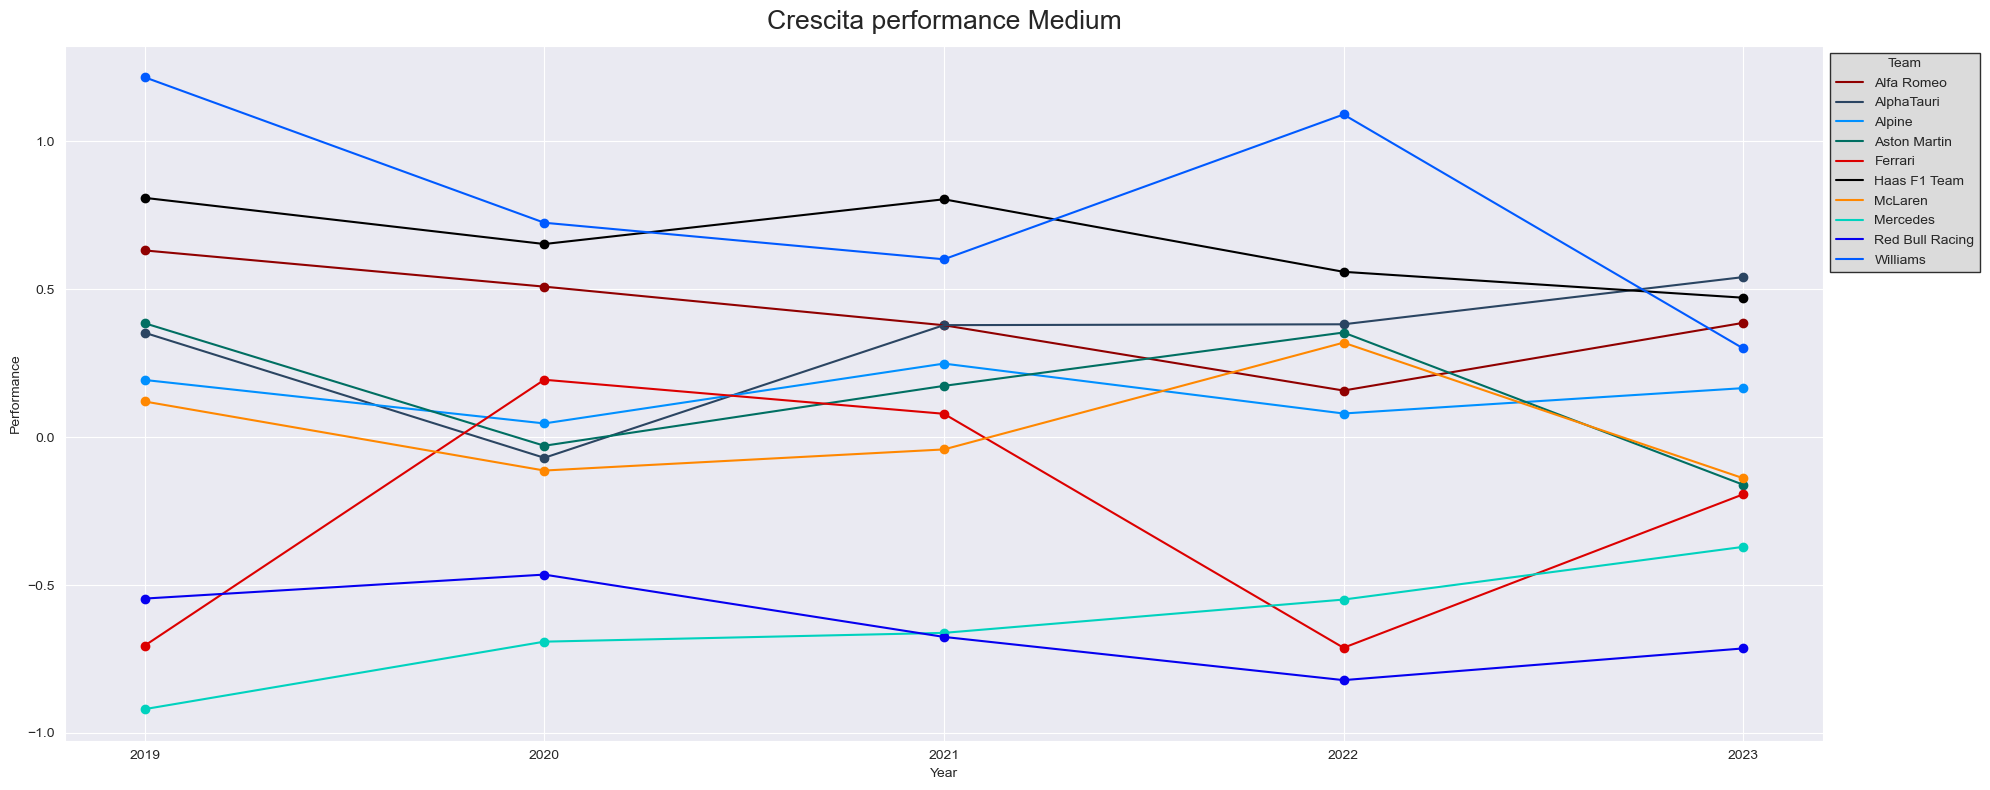

In [345]:
# Calcolo delle mediane per ogni team e anno
md_growth = df_tempi_md.groupby(['Team', 'Year'], as_index=False)['Ratio_to_mean'].mean()

# Grafico con punti
fig, ax = plt.subplots(figsize=(20, 8))

for team in pd.unique(hd_growth['Team']):
    team_laps = md_growth[hd_growth['Team'] == team]
    abb = team_laps['Team'].iloc[0]
    color = team_palette[team]

    ax.plot(team_laps['Year'], team_laps['Ratio_to_mean'], label=abb, color=color)
    
    # Aggiungi i punti per ogni anno
    ax.scatter(team_laps['Year'], team_laps['Ratio_to_mean'], color=color)

ax.set_xlabel('Year')
ax.set_ylabel('Performance')
ax.set_title('Crescita performance Medium')

# Aggiunta della legenda
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Team', facecolor='lightgrey', edgecolor='black')

# Imposta l'asse x con una scala di 1
plt.xticks(np.arange(min(md_growth['Year']), max(md_growth['Year']) + 1, 1))

plt.tight_layout()
plt.show()

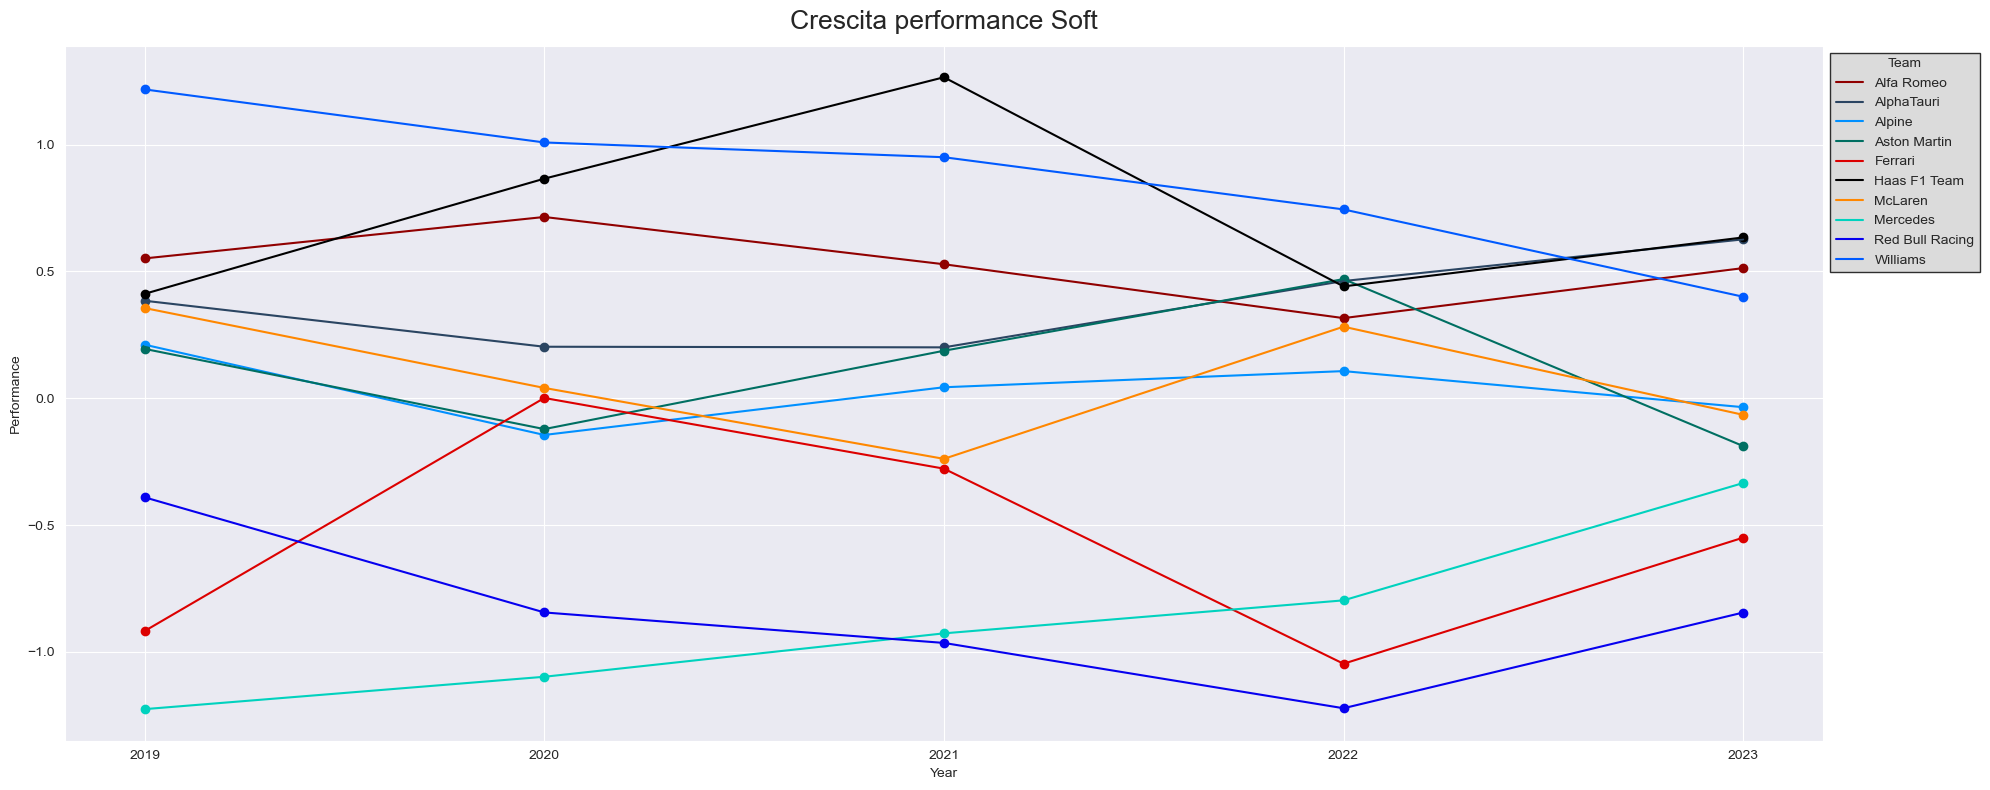

In [346]:
# Calcolo delle mediane per ogni team e anno
sf_growth = df_tempi_sf.groupby(['Team', 'Year'], as_index=False)['Ratio_to_mean'].mean()

# Grafico con punti
fig, ax = plt.subplots(figsize=(20, 8))

for team in pd.unique(sf_growth['Team']):
    team_laps = hd_growth[hd_growth['Team'] == team]
    abb = team_laps['Team'].iloc[0]
    color = team_palette[team]

    ax.plot(team_laps['Year'], team_laps['Ratio_to_mean'], label=abb, color=color)
    
    # Aggiungi i punti per ogni anno
    ax.scatter(team_laps['Year'], team_laps['Ratio_to_mean'], color=color)

ax.set_xlabel('Year')
ax.set_ylabel('Performance')
ax.set_title('Crescita performance Soft')

# Aggiunta della legenda
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Team', facecolor='lightgrey', edgecolor='black')

# Imposta l'asse x con una scala di 1
plt.xticks(np.arange(min(sf_growth['Year']), max(sf_growth['Year']) + 1, 1))

plt.tight_layout()
plt.show()

###
### Correlazioni

In [158]:
df_weather = pd.read_csv('df_weather.csv', sep = ';')

In [160]:
df_weather = df_weather.rename(columns={'LapTime_seconds': 'LapTime_mean'})

df_tempi = df_tempi.merge(df_weather, on = ['Year', 'GP', 'Team', 'Compound'])

In [174]:
df_distanze = pd.read_csv('distanze.csv', sep = ',')

In [176]:
df_tempi = df_tempi.merge(df_distanze, on = ['GP'])

df_tempi['Distanza_percorsa'] = df_tempi['LapNumber'] * df_tempi['Distanza']

distanza_max = df_tempi.groupby(['Year', 'GP', 'Stint', 'Team', 'Compound'])['Distanza_percorsa'].max()

distanza_max = distanza_max.rename('Distanza_max')

df_tempi = df_tempi.merge(distanza_max, on = ['Year', 'GP', 'Team', 'Compound'])

In [207]:
columns_of_interest = ['Ratio_to_mean', 'Distanza_max', 'AirTemp', 'Humidity', 'Pressure', 'TrackTemp']
correlation_matrix = df_tempi.loc[df_tempi['Compound'] != 'WET'].groupby('Compound')[columns_of_interest].corr().round(3)
correlation_matrix

Ratio_to_mean  Distanza_max  AirTemp  Humidity  \
Compound                                                                     
HARD         Ratio_to_mean          1.000        -0.092    0.004    -0.005   
             Distanza_max          -0.092         1.000    0.046    -0.012   
             AirTemp                0.004         0.046    1.000    -0.250   
             Humidity              -0.005        -0.012   -0.250     1.000   
             Pressure               0.009        -0.088    0.066     0.229   
             TrackTemp              0.002         0.064    0.603    -0.485   
INTERMEDIATE Ratio_to_mean          1.000        -0.042    0.003    -0.000   
             Distanza_max          -0.042         1.000   -0.198    -0.076   
             AirTemp                0.003        -0.198    1.000     0.979   
             Humidity              -0.000        -0.076    0.979     1.000   
             Pressure               0.015        -0.578    0.012    -0.193   
             TrackTemp              0.004        -0.242    0.997     0.960   
MEDIUM       Ratio_to_mean          1.000        -0.036   -0.023     0.009   
             Distanza_max          -0.036         1.000   -0.133     0.042   
             AirTemp               -0.023        -0.133    1.000    -0.392   
             Humidity               0.009         0.042   -0.392     1.000   
             Pressure              -0.018         0.033    0.057     0.255   
             TrackTemp             -0.009        -0.115    0.662    -0.514   
SOFT         Ratio_to_mean          1.000        -0.001   -0.001     0.003   
             Distanza_max          -0.001         1.000   -0.089     0.098   
             AirTemp               -0.001        -0.089    1.000    -0.675   
             Humidity               0.003         0.098   -0.675     1.000   
             Pressure              -0.014        -0.020    0.050     0.073   
             TrackTemp             -0.016        -0.041    0.602    -0.372   

                            Pressure  TrackTemp  
Compound                                         
HARD         Ratio_to_mean     0.009      0.002  
             Distanza_max     -0.088      0.064  
             AirTemp           0.066      0.603  
             Humidity          0.229     -0.485  
             Pressure          1.000     -0.244  
             TrackTemp        -0.244      1.000  
INTERMEDIATE Ratio_to_mean     0.015      0.004  
             Distanza_max     -0.578     -0.242  
             AirTemp           0.012      0.997  
             Humidity         -0.193      0.960  
             Pressure          1.000      0.088  
             TrackTemp         0.088      1.000  
MEDIUM       Ratio_to_mean    -0.018     -0.009  
             Distanza_max      0.033     -0.115  
             AirTemp           0.057      0.662  
             Humidity          0.255     -0.514  
             Pressure          1.000     -0.307  
             TrackTemp        -0.307      1.000  
SOFT         Ratio_to_mean    -0.014     -0.016  
             Distanza_max     -0.020     -0.041  
             AirTemp           0.050      0.602  
             Humidity          0.073     -0.372  
             Pressure          1.000     -0.395  
             TrackTemp        -0.395      1.000

In [322]:
session = fastf1.get_session(2019, 'Bahrain', 'L1')

ValueError: Invalid session type 'L1'